# Modules

In [1]:


import pandas as pd
import numpy as np
#import urllib2
import folium
import json

import scipy
import scipy.stats as sp
import scipy.optimize as op
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import stats
#from pandas.stats.api import ols
from datetime import date, timedelta

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

rcParams.update(inline_rc)


#from matplotlib.pyplot import cm 
import platform
import sys
import glob



import pyproj
from pyproj import Proj
import simplekml

#import matplotlib



C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import wellapplication as wa
#import pyfinance

In [3]:
import plotly 
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='PaulInkenbrandt', api_key='bwg1urnzdi')
plotly.offline.init_notebook_mode(connected=True)

In [4]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
print("Well Application Version " + str(wa.__version__))
print("Scipy Version " +str(scipy.__version__))

Operating System Windows 10
Python Version 3.6.2 |Continuum Analytics, Inc.| (default, Jul 20 2017, 12:30:02) [MSC v.1900 64 bit (AMD64)]
Pandas Version 0.22.0
Numpy Version 1.13.3
Matplotlib Version 2.0.2
Well Application Version 0.5.4
Scipy Version 0.19.1


# Directories

In [5]:
#if platform.system() == 'Windows':
#    if platform.system() + " " + platform.release() == 'Windows 7':
#        drive = 'E:/Google Drive/WORK/'
#    else:
#        drive = 'E:/PROJECTS/'
#else:
#    drive = '/media/pi/Transcend/PROJECTS/'
drive = 'G:/My Drive/WORK/'
#fileplace =  drive + '/PROJECTS/Round_Valley/'

#fileLocation = fileplace + 'URVH/URVH/'

fileplace = drive + 'Round_Valley/Data/Hydrology_Data/'
figplace = drive + 'Round_Valley/Writing/Figures/'
shpplace = drive + 'Round_Valley/Data/GIS/'

# Functions

In [6]:
def ratingCurve(transducer, manual, bounds = None):
    """Computes rating curve based on discharge measurements coupled with stage
    readings.
    discharge = array of measured discharges;
    stage = array of corresponding stage readings;
    Returns coefficients a, b for the rating curve in the form y = a * x**b
    https://github.com/hydrogeog/hydro/blob/master/hydro/core.py
    """
    from scipy.optimize import curve_fit

    MFQ = []

    for j in manual.index:
        MFQ.append(wa.transport.fcl(transducer, j))

    yn = manual.values
    x = MFQ
        
    def func(x, a, b, c):
        return a*(x)**(b) + c
    
    if bounds:

            popt, pcov = curve_fit(func, x, yn,  bounds = bounds, max_nfev = 800000, method='trf')

    else:

            popt, pcov = curve_fit(func, x, yn, maxfev = 800000)


    sterr = np.sqrt(np.diag(pcov))
    

    #plt.savefig(figplace + 'DischargeStage.svg')
    
    
    
    return popt, pcov, sterr, x, yn

In [7]:
def crosscorr(datax, datay, lag=0):
    ''' 
    http://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    '''
    return datax.corr(datay.shift(lag))

def scatterColor(x0,y,w):
    """Creates scatter plot with points colored by variable.
    All input arrays must have matching lengths

    Arg:
        x0 (array): 
            array of x values
        y (array): 
            array of y values
        w (array): 
            array of scalar values

    Returns:
        slope and intercept of best fit line
    
    """
    import matplotlib as mpl
    import matplotlib.cm as cm
    cmap = plt.cm.get_cmap('RdYlBu')
    norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array(w)
    sc = plt.scatter(x0, y, label='', color = m.to_rgba(w))

    xa = sm.add_constant(x0)

    est = sm.RLM(y, xa).fit()
    r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
    slope = est.params[1]

    x_prime = np.linspace(np.min(x0),np.max(x0),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)

    const = est.params[0]
    y2 = [i*slope + const for i in x0]

    plt.xlabel('Barometric Pressure (ft water)')
    plt.ylabel('Transducer Pressure (ft water)')
    lin = linregress(x0,y)
    x1 = np.arange(np.min(x0), np.max(x0),0.1)
    y1 = [i*lin[0]+lin[1] for i in x1]
    y2 = [i*slope+const for i in x1]
    plt.plot(x1,y1,c='g',label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(lin[0],lin[1],lin[2]**2))
    plt.plot(x1,y2,c='r',label='rlm regression m = {:.2f} b = {:.0f}, r2 = {:.2f}'.format(slope,const,r2))
    plt.legend()
    cbar = plt.colorbar(m)

    cbar.set_label('Julian Date')

    return slope,const

In [8]:
import arcpy
arcpy.CheckOutExtension("spatial")
from arcpy import env 
from arcpy.sa import *

In [9]:
def df2PntShp(df,x,y,plc,espg):
    import shapefile
    import urllib
    # https://glenbambrick.com/2016/01/24/reproject-shapefile/

    w = shapefile.Writer(shapefile.POINT)

    typeDict = {'int64':'N','float64':'N','object':'C','datetime64[ns]':'D'}
    for col in df.columns:
        w.field(str(col), fieldType=typeDict[df[col].dtype.name])
    for i in list(df.index):
        w.point(df.ix[i,x], df.ix[i,y])
        w.record(*list(df.ix[i,:].values))

    w.save(str(plc))

    prj = open(plc + ".prj", "w")
    wkt = urllib.urlopen("http://spatialreference.org/ref/epsg/{0}/prettywkt/".format(epsg))
    remove_spaces = wkt.read().replace(" ","")
    proESPG = remove_spaces.replace("\n", "")
    prj.write(proESPG)
    prj.close()
    print("file saved at {}".format(plc))
    
def df2PntShpAP(df,x,y,plc,epsg):
    import shapefile
    
    w = shapefile.Writer(shapefile.POINT)

    typeDict = {'int64':'N','float64':'N','object':'C','datetime64[ns]':'D'}
    for col in df.columns:
        w.field(str(col), fieldType = typeDict[df[col].dtype.name])

    for i in list(df.index):
        w.point(df.ix[i,x], df.ix[i,y])
        w.record(*list(df.ix[i,:].values))

    w.save(str(plc))
    sr = arcpy.SpatialReference(epsg) #NAD83 zone 12
    arcpy.DefineProjection_management(plc+'.shp', sr)
    
    

def df2PntFt(df,x,y,shpplace,shpname,gdb,epsg):
    '''
    input is Pandas Dataframe
    df = dataframe to input
    x = column name of x coordinates
    y = column name of y coordinates
    shpplace = directory to store gis files (directory where the gdb is); do not include gdb name in this string
    gdb = name of geodatabase to store file
    epsg = integer epsg itentifier of projection
    '''
    import arcpy
    arcpy.env.overwriteOutput = True
    df2PntShpAP(df,x,y,shpplace+shpname,epsg)
    arcpy.FeatureClassToFeatureClass_conversion(shpplace + shpname +'.shp', shpplace+gdb, shpname)
    print("file saved at {}".format(shpplace+gdb+"/"+shpname))
    
def xl2PntFt(xlfile,x,y,shpplace,shpname,gdb,epsg,sheetname='Sheet1'):
    '''
    Converts excel file into shapefile and feature class.  
    Input should be excel file that has 1 row of column headers on the first row of the spreadsheet.
    Output is a point feature class, a shapefile, and Pandas dataframe of the data
    
    xlfile = string of file and diretory (include extension)
    x = column name of x coordinates
    y = column name of y coordinates
    shpplace = directory to store gis files (directory where the gdb is); do not include gdb name in this string
    gdb = name of geodatabase to store file
    epsg = integer epsg itentifier of projection
    sheetname = optional; name of sheet in excel file where data are stored
    '''
    df = pd.read_excel(xlfile,sheetname)
    df2PntFt(df,x,y,shpplace,shpname,gdb,epsg)
    return df

def baroget(d,stn):
    '''
    returns barometric pressure data from Mesowest
    token = token from Mesowest
    stn = station string
    start = start date YYYYMMDDHHMM
    end = end date YYYYMMDDHHMM; optional, defaults to beginning of current day
    '''
    
    token = "1ab92e63dd924c6189e6d5e1015c2645"
    begdate = datetime.strftime(d.index[0],"%Y%m%d%H%M")
    enddate = datetime.strftime(d.index[-1],"%Y%m%d%H%M")
    addrs = 'https://api.mesowest.net/v2/stations/timeseries?token={:}&stid={:}&start={:}&end={:}&units=pres|mb&output=csv'
    html = addrs.format(token, stn, begdate, enddate)
    baro = pd.read_csv(html,skiprows=8,usecols=[1,2,15],index_col=0,parse_dates=True,names=['datetime','pressure_pascals','precip_mm'])
    
    return baro

# Surface Data

## Existing Data

### Main Creek

Import USGS Data from NWIS Site.

In [227]:
nw = wa.nwis('dv',[10158500],'sites')
MainUSGS = nw.data
MainUSGS.loc[:,'month'] = MainUSGS.index.month
MainUSGS.loc[:,'doy'] = MainUSGS.index.dayofyear

connection successful


Group by day of year and plot the median discharge.

Median Q = 8420 ac-ft/yr
Average Q = 9626 ac-ft/yr
Mean Baseflow Discharge (Jul-Nov) = 4.6 cfs
Max Q = 19384 ac-ft/yr
Min Q = 3369 ac-ft/yr



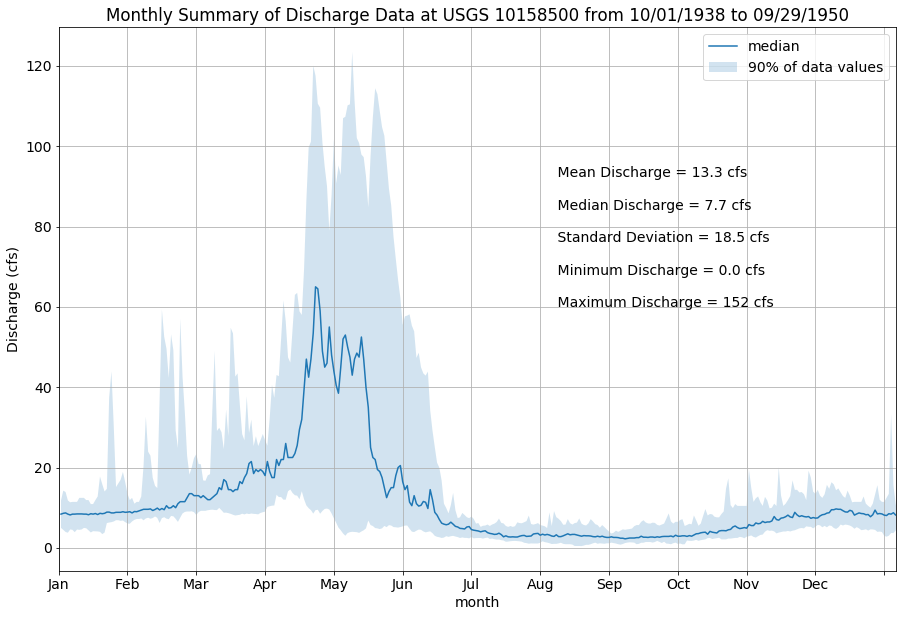

In [228]:
grpd = MainUSGS.groupby(['doy'])['value']
xm = grpd.median().index
ym = grpd.median()
ya = grpd.mean()
y1 = grpd.quantile(q=0.05)
y2 = grpd.quantile(q=0.95)
maincrkUSGS = ym
meanBF = grpd.mean()[182:334].mean()
med_q = np.sum(ym*86400.00)*2.29569e-5 #cfs to cfd to ac-ft/yr
avg_q = np.sum(ya*86400.00)*2.29569e-5 #cfs to cfd to ac-ft/yr
high_q = np.sum(y2*86400.00)*2.29569e-5 #cfs to cfd to ac-ft/yr
low_q = np.sum(y1*86400.00)*2.29569e-5 #cfs to cfd to ac-ft/yr
print("""Median Q = {:0.0f} ac-ft/yr
Average Q = {:0.0f} ac-ft/yr
Mean Baseflow Discharge (Jul-Nov) = {:0.1f} cfs
Max Q = {:0.0f} ac-ft/yr
Min Q = {:0.0f} ac-ft/yr
""".format(med_q,avg_q,meanBF,high_q,low_q))

rcParams.update(inline_rc)
rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 14
rcParams['pdf.fonttype'] = 42

plt.figure()
plt.plot(xm,ym, label='median')
#plt.plot(xm,ya, label='mean')
plt.fill_between(xm,y1,y2, label='90% of data values', alpha=0.2, linewidth=0)

plt.title("Monthly Summary of Discharge Data at {:} from {:%m/%d/%Y} to {:%m/%d/%Y}".format('USGS 10158500', 
                                                                                           MainUSGS.index.min(),
                                                                                           MainUSGS.index.max()))

minQ = min(MainUSGS['value'])
maxQ = max(MainUSGS['value'])
meanQ = np.mean(MainUSGS['value'])
medianQ = np.median(MainUSGS['value'])
stdQ = np.std(MainUSGS['value'])


plt.legend()
plt.grid()

plt.xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)
plt.text(200, 60,
         """
         Mean Discharge = {:0.1f} cfs\n
         Median Discharge = {:0.1f} cfs\n
         Standard Deviation = {:0.1f} cfs\n
         Minimum Discharge = {:0.1f} cfs\n
         Maximum Discharge = {:0.0f} cfs""".format(meanQ,medianQ,stdQ,minQ,maxQ))
plt.ylabel('Discharge (cfs)')
plt.show()
plt.savefig(figplace + 'MainCreekMonthlyHydroGraph.svg')
plt.savefig(figplace + 'MainCreekMonthlyHydroGraph.pdf')

In [229]:
nw = wa.nwis('dv',[10158500],'sites')
MainUSGS = nw.data
MainUSGS.loc[:,'month'] = MainUSGS.index.month
MainUSGS.loc[:,'doy'] = MainUSGS.index.dayofyear
MainUSGS['water year'] = MainUSGS.index.shift(-9,freq='M').year+1
#MainUSGS['water year doy'] = 0
MainUSGS.loc[MainUSGS.index[0],'water year doy'] = int(1)
for i in range(1,len(MainUSGS.index)):
    if MainUSGS.loc[MainUSGS.index[i],'water year'] == MainUSGS.loc[MainUSGS.index[i-1],'water year']:  
        MainUSGS.loc[MainUSGS.index[i],'water year doy'] = int(MainUSGS.loc[MainUSGS.index[i-1],'water year doy'] + 1)
    else:
        MainUSGS.loc[MainUSGS.index[i],'water year doy'] = int(1)

connection successful


In [230]:
MainUSGS['cfd'] = MainUSGS['value']*86400.0
year_Main_summary = MainUSGS.groupby(MainUSGS.index.year)['cfd'].sum()*2.29569e-5
wateryear_Main_summary = MainUSGS.groupby(MainUSGS['water year'])['cfd'].sum()*2.29569e-5
wateryear_Main_summary.to_clipboard()

(0, 365)

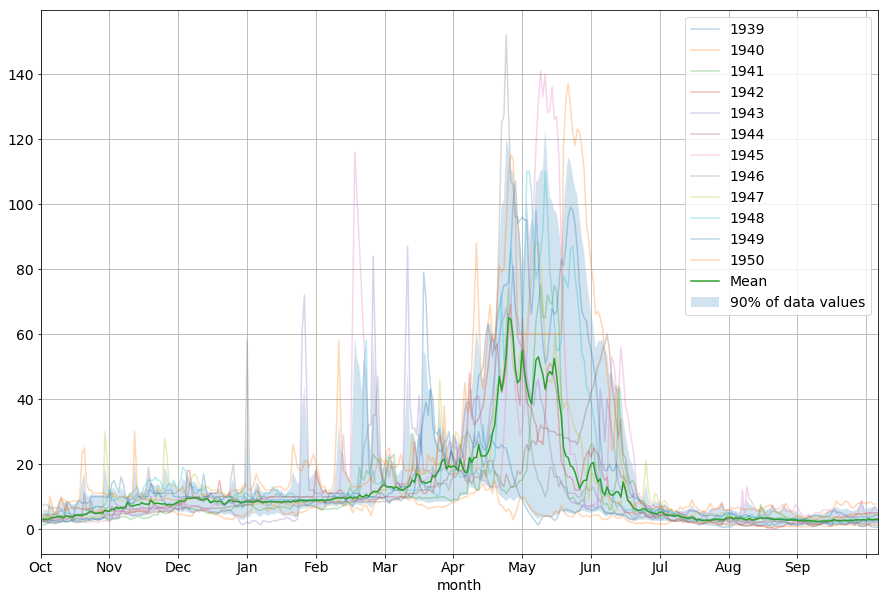

In [231]:
grpd = MainUSGS.groupby(['water year doy'])['value']
xm = grpd.median().index
ym = grpd.median()
y1 = grpd.quantile(q=0.05)
y2 = grpd.quantile(q=0.95)

for year in MainUSGS['water year'].unique():
    xyr = MainUSGS[MainUSGS['water year'] == year]['water year doy']
    yyr = MainUSGS[MainUSGS['water year'] == year]["value"]
    plt.plot(xyr,yyr,alpha=0.3,label=year)
plt.plot(xm,ym,label='Mean')


plt.fill_between(xm,y1,y2, label='90% of data values', alpha=0.2, linewidth=0)

plt.legend()
plt.grid()

plt.xlabel('month')
dtrng = pd.date_range('10/1/2014','9/30/2015',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)

Median Q = 8413 ac-ft/yr
Average Q = 9617 ac-ft/yr
Mean Baseflow Discharge (Jul-Nov) = 18.9 cfs
Max Q = 19370 ac-ft/yr
Min Q = 3361 ac-ft/yr



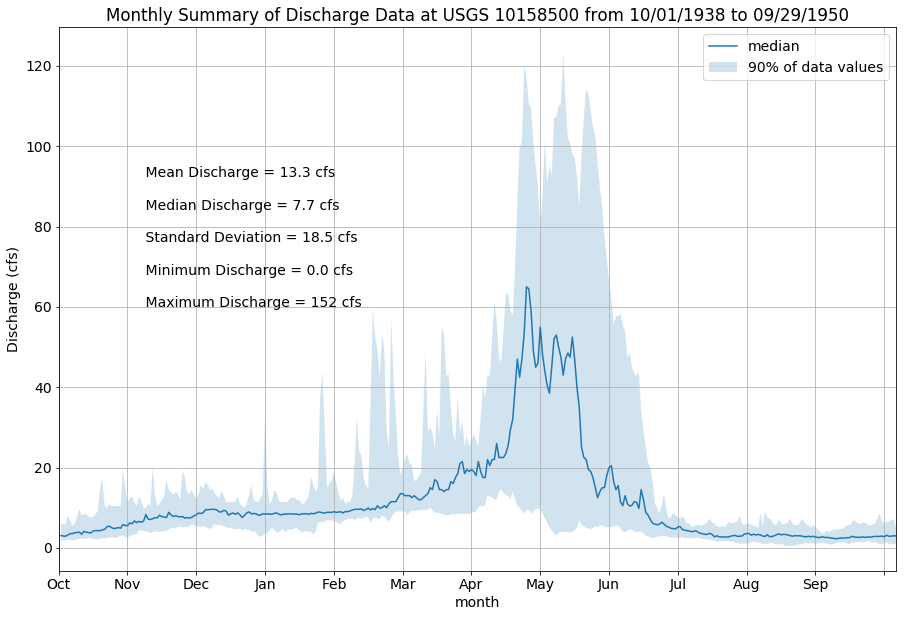

In [232]:
grpd = MainUSGS.groupby(['water year doy'])['value']
xm = grpd.median().index
ym = grpd.median()
ya = grpd.mean()
y1 = grpd.quantile(q=0.05)
y2 = grpd.quantile(q=0.95)
maincrkUSGS = ym
meanBF = grpd.mean()[182:334].mean()
med_q = np.sum(ym*86400.00)*2.29569e-5 #cfs to cfd to ac-ft/yr
avg_q = np.sum(ya*86400.00)*2.29569e-5 #cfs to cfd to ac-ft/yr
high_q = np.sum(y2*86400.00)*2.29569e-5 #cfs to cfd to ac-ft/yr
low_q = np.sum(y1*86400.00)*2.29569e-5 #cfs to cfd to ac-ft/yr
print("""Median Q = {:0.0f} ac-ft/yr
Average Q = {:0.0f} ac-ft/yr
Mean Baseflow Discharge (Jul-Nov) = {:0.1f} cfs
Max Q = {:0.0f} ac-ft/yr
Min Q = {:0.0f} ac-ft/yr
""".format(med_q,avg_q,meanBF,high_q,low_q))

rcParams.update(inline_rc)
rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 14
rcParams['pdf.fonttype'] = 42

plt.figure()
plt.plot(xm,ym, label='median')
#plt.plot(xm,ya, label='mean')
plt.fill_between(xm,y1,y2, label='90% of data values', alpha=0.2, linewidth=0)

plt.title("Monthly Summary of Discharge Data at {:} from {:%m/%d/%Y} to {:%m/%d/%Y}".format('USGS 10158500', 
                                                                                           MainUSGS.index.min(),
                                                                                           MainUSGS.index.max()))

minQ = min(MainUSGS['value'])
maxQ = max(MainUSGS['value'])
meanQ = np.mean(MainUSGS['value'])
medianQ = np.median(MainUSGS['value'])
stdQ = np.std(MainUSGS['value'])


plt.legend()
plt.grid()

plt.xlabel('month')
dtrng = pd.date_range('10/1/2014','9/30/2015',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)
plt.text(20, 60,
         """
         Mean Discharge = {:0.1f} cfs\n
         Median Discharge = {:0.1f} cfs\n
         Standard Deviation = {:0.1f} cfs\n
         Minimum Discharge = {:0.1f} cfs\n
         Maximum Discharge = {:0.0f} cfs""".format(meanQ,medianQ,stdQ,minQ,maxQ))
plt.ylabel('Discharge (cfs)')
plt.show()
plt.savefig(figplace + 'MainCreekMonthlyHydroGraph.svg')
plt.savefig(figplace + 'MainCreekMonthlyHydroGraph.pdf')

7.7
13.272318576


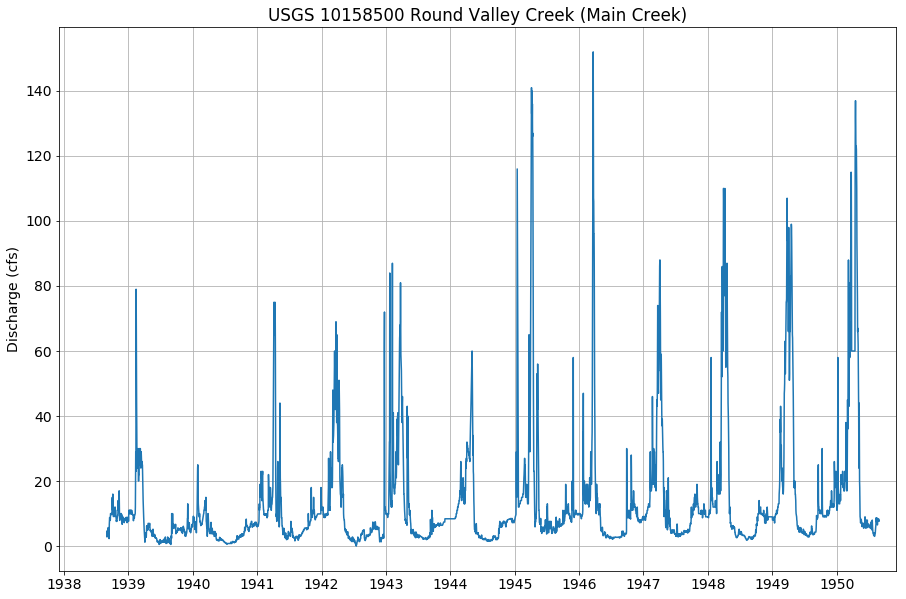

In [233]:
x = MainUSGS.index
y = MainUSGS['value']
plt.plot(x,y)
plt.xlim()
plt.ylabel('Discharge (cfs)')
plt.title('USGS 10158500 Round Valley Creek (Main Creek)')

y1 = MainUSGS['value'].rolling(window=185,center=True).median()
x1 = y1.index
print(MainUSGS['value'].median())
print(MainUSGS['value'].mean())
#plt.plot(x1,y1,color='red')
plt.xlim(pd.datetime(1938,1,1),pd.datetime(1951,1,1))
date_range = pd.date_range('1938-01-01', '1951-01-01', freq='12M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
plt.xticks(date_range)
plt.grid()
plt.savefig(figplace+'MainCreekHydroGraph.svg')
plt.savefig(figplace+'MainCreekHydroGraph.pdf')

48.0%
58.6%


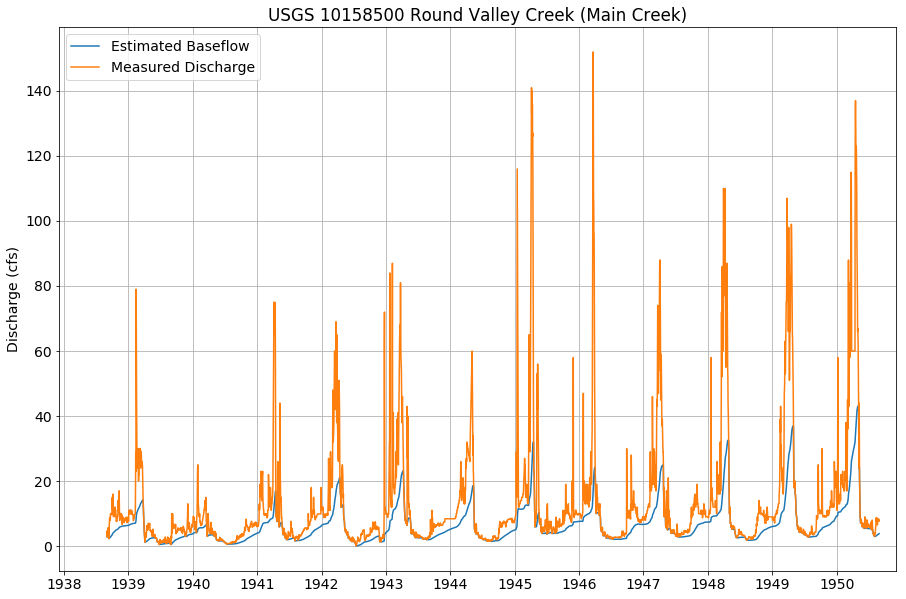

In [237]:
MainUSGS['baseflow_Eck'] = wa.Eckhardt(MainUSGS['value'],alpha=0.997)
MainUSGS['baseflow_Eck_cfd'] = MainUSGS['baseflow_Eck']*86400.0
plt.figure()
plt.plot(MainUSGS['baseflow_Eck'].index,MainUSGS['baseflow_Eck'],label='Estimated Baseflow')
plt.plot(MainUSGS['value'].index,MainUSGS['value'],label='Measured Discharge')
print('{:.1%}'.format(MainUSGS['baseflow_Eck'].mean()/MainUSGS['value'].mean()))
print('{:.1%}'.format(MainUSGS['baseflow_Eck'].median()/MainUSGS['value'].median()))
plt.xlim(pd.datetime(1938,1,1),pd.datetime(1951,1,1))
date_range = pd.date_range('1938-01-01', '1951-01-01', freq='12M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
plt.xticks(date_range)
plt.grid()
plt.legend(loc=2)
plt.ylabel('Discharge (cfs)')
plt.title('USGS 10158500 Round Valley Creek (Main Creek)')

In [244]:
engineroute = "G:/My Drive/WORK/Round_Valley/Data/"
#engineroute = "C:/Users/Brooke/Downloads/"
sys.path.append(engineroute)
import enginegetter

engine = enginegetter.getEngine()


In [247]:
sql = MainUSGS.groupby(pd.Grouper(freq='M')).sum()
sql['Year'] = sql.index.year
sql['Month'] = sql.index.month
sql['YearMonth'] = sql[['Year','Month']].apply(lambda x: str(x[0])+str(x[1]).zfill(2),1)
sql['volume_acft'] = 2.29569e-5 * sql['cfd']
sql['datav'] = 'Q'
sql['SOURCE'] = 'USGS Gage'
sql['AreaName'] = 'Watershed'
sql['baseflow_acft'] = 2.29569e-5 * sql['baseflow_Eck_cfd']
sql.drop(['value','month','cfd','doy','water year','water year doy',
          'baseflow_Eck','baseflow_Eck_cfd'],axis=1,inplace=True)

sql2 = sql.copy(deep=True)
sql2['datav'] = 'BFQ'
sql2['volume_acft'] = sql2['baseflow_acft']

sql2.drop(['baseflow_acft'],axis=1,inplace=True)
sql.drop(['baseflow_acft'],axis=1,inplace=True)

tabname = 'roundvalley2'
sql2.to_sql(con=engine, name=tabname, if_exists='append', index=False)
tabname = 'roundvalley2'
sql.to_sql(con=engine, name=tabname, if_exists='append', index=False)

In [33]:
MainUSGS.to_csv(fileplace+"Main_Creek_Flow_USGS.csv")

Median Q = 4440 ac-ft/yr
Average Q = 4616 ac-ft/yr
Mean Baseflow Discharge (Jul-Nov) = 2.6 cfs
Std. Dev. of Baseflow = 2023 ac-ft/yr

Vol. of median baseflow 3594 ac-ft


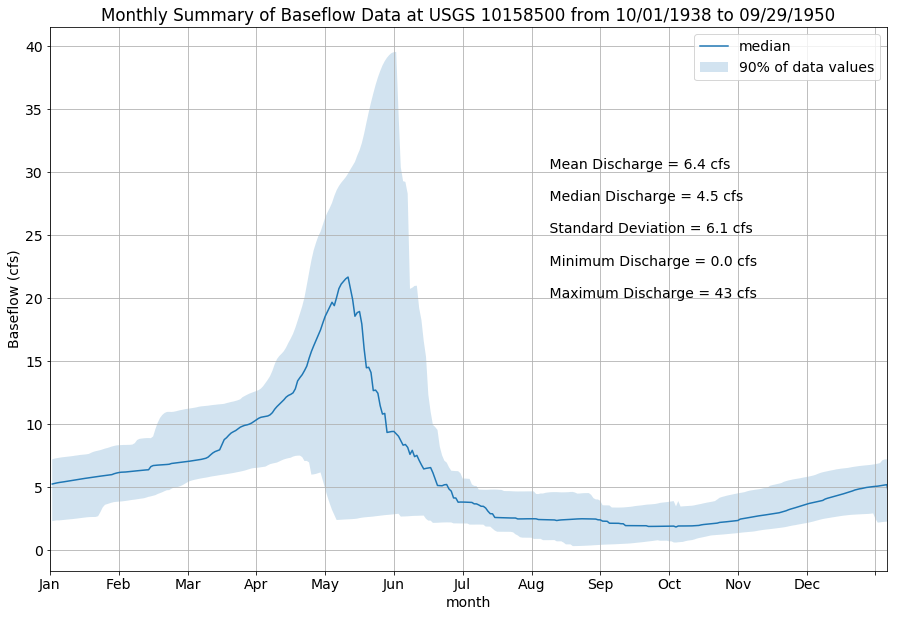

In [65]:
grpd = MainUSGS.groupby(['doy'])['baseflow_Eck']
xm = grpd.median().index
ym = grpd.median()
ya = grpd.mean()
ys = grpd.std()
y1 = grpd.quantile(q=0.05)
y2 = grpd.quantile(q=0.95)


meanBF = grpd.mean()[182:334].mean()
med_q = np.sum(ym*86400.00)*2.29569e-5 #cfs to cfd to ac-ft/yr
avg_q = np.sum(ya*86400.00)*2.29569e-5 #cfs to cfd to ac-ft/yr
stdBF = np.sum(ys*86400.00)*2.29569e-5
print("""Median Q = {:0.0f} ac-ft/yr
Average Q = {:0.0f} ac-ft/yr
Mean Baseflow Discharge (Jul-Nov) = {:0.1f} cfs
Std. Dev. of Baseflow = {:0.0f} ac-ft/yr
""".format(med_q,avg_q,meanBF,stdBF))

rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 14
rcParams['pdf.fonttype'] = 42

plt.plot(xm,ym, label='median')
#plt.plot(xm,ya, label='mean')
plt.fill_between(xm,y1,y2, label='90% of data values', alpha=0.2, linewidth=0)

plt.title("Monthly Summary of Baseflow Data at {:} from {:%m/%d/%Y} to {:%m/%d/%Y}".format('USGS 10158500', 
                                                                                           MainUSGS.index.min(),
                                                                                           MainUSGS.index.max()))
print('Vol. of median baseflow {:0.0f} ac-ft'.format(ym.median()*365.25*24*60*60*2.296E-5))
minQ = min(MainUSGS['baseflow_Eck'])
maxQ = max(MainUSGS['baseflow_Eck'])
meanQ = np.mean(MainUSGS['baseflow_Eck'])
medianQ = np.median(MainUSGS['baseflow_Eck'])
stdQ = np.std(MainUSGS['baseflow_Eck'])

plt.legend()
plt.grid()

plt.xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)
plt.text(200, 20,
         """
         Mean Discharge = {:0.1f} cfs\n
         Median Discharge = {:0.1f} cfs\n
         Standard Deviation = {:0.1f} cfs\n
         Minimum Discharge = {:0.1f} cfs\n
         Maximum Discharge = {:0.0f} cfs""".format(meanQ,medianQ,stdQ,minQ,maxQ))
plt.ylabel('Baseflow (cfs)')

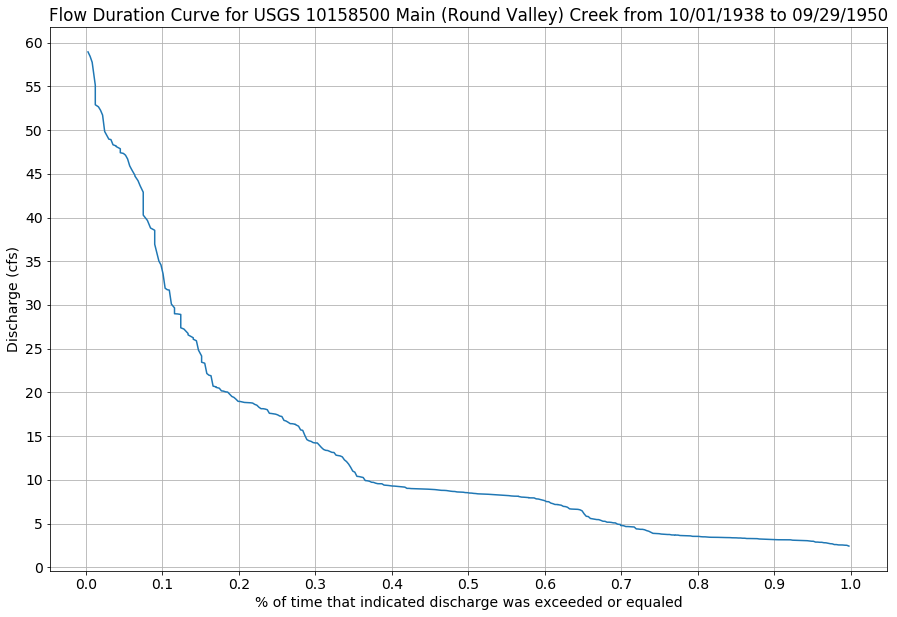

In [43]:
wa.fdc(MainUSGS,'value')
plt.grid()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(range(0,65,5))
plt.title('Flow Duration Curve for USGS 10158500 Main (Round Valley) Creek from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(MainUSGS.index.min(),MainUSGS.index.max()))
plt.savefig(figplace + 'fdcMainCreek.svg')
plt.savefig(figplace + 'fdcMainCreek.pdf')

### Deer Creek Res

Read in data

From: http://www.usbr.gov/rsvrWater/faces/rvrOSMP.xhtml

In [44]:
DeerCreek = pd.read_csv(fileplace+'DeerCreekData_Historic.csv', index_col='Date',parse_dates=True)

Add month and day of year columns to data.

In [45]:
DeerCreek.loc[:,'month'] = DeerCreek.index.month
DeerCreek.loc[:,'doy'] = DeerCreek.index.dayofyear

278.0


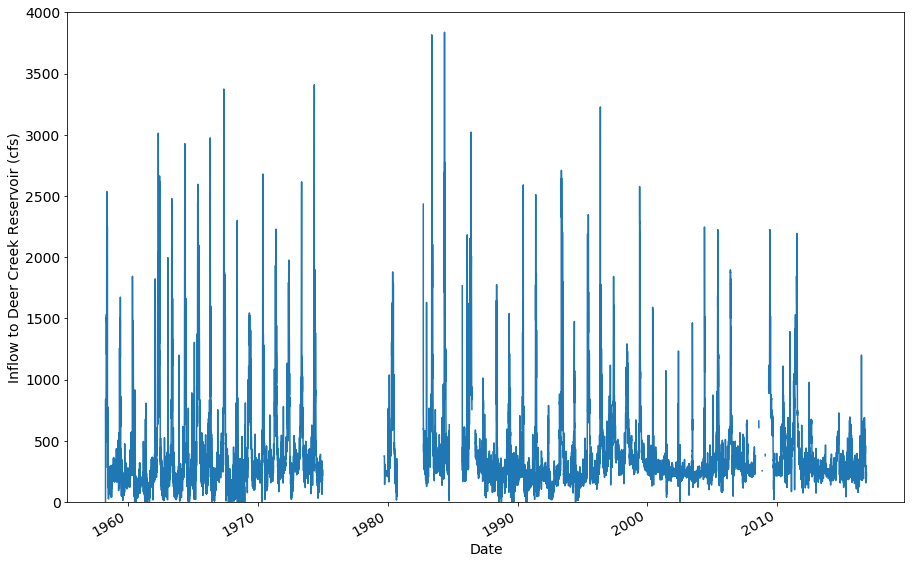

In [46]:
DeerCreek[u'Computed Inflow (cfs)'].plot()
print(DeerCreek[u'Computed Inflow (cfs)'].median())
plt.ylim(0,4000)
plt.ylabel('Inflow to Deer Creek Reservoir (cfs)')

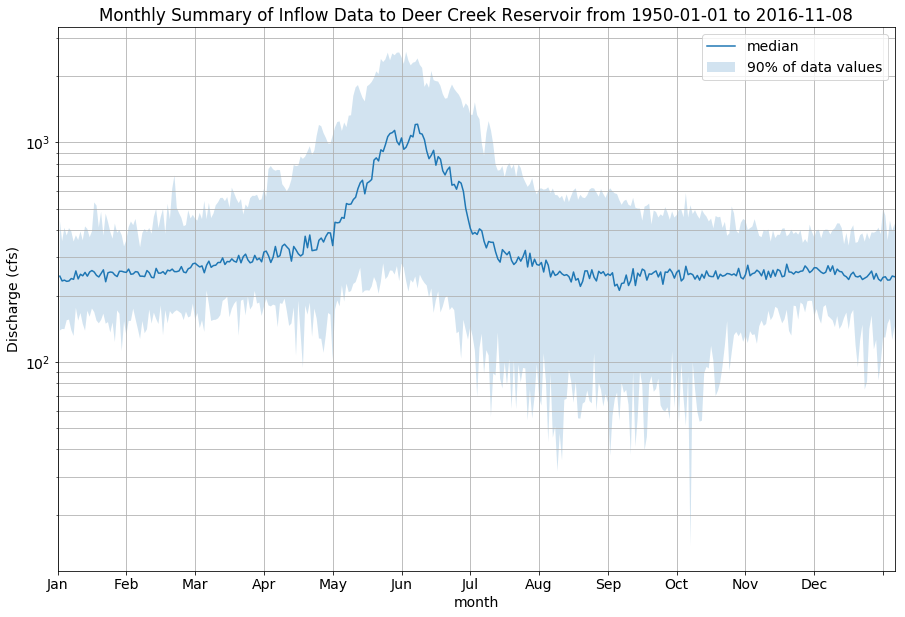

In [47]:
grpd1 = DeerCreek.groupby(['doy'])[u'Computed Inflow (cfs)']
dcx = grpd1.median().index
dcy = grpd1.median()
dcx1 = grpd1.quantile(q=0.05, interpolation='linear').index
dcy1 = grpd1.quantile(q=0.05)
dcx2 = grpd1.quantile(q=0.95).index
dcy2 = grpd1.quantile(q=0.95)

plt.plot(dcx,dcy, label='median')
plt.fill_between(dcx,dcy1,dcy2, label='90% of data values',alpha=0.2)
#plt.plot(dcx,dcy1, label='10th percentile')
#plt.plot(dcx,dcy2, label='90th percentile')

plt.title("Monthly Summary of Inflow Data to %s from %s to %s" %('Deer Creek Reservoir', 
                                                                    datetime.datetime.strftime(DeerCreek[u'Computed Inflow (cfs)'].index.min(),
                                                                                      "%Y-%m-%d"), 
                                                                    datetime.datetime.strftime(DeerCreek[u'Computed Inflow (cfs)'].index.max(),
                                                                                      "%Y-%m-%d")))
plt.xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)
plt.yscale('log')
plt.legend()
plt.grid(which='both')

plt.ylabel('Discharge (cfs)')
plt.savefig(figplace+'DeerCreekMonthlyHydroGraph.svg')

0.0292398811085


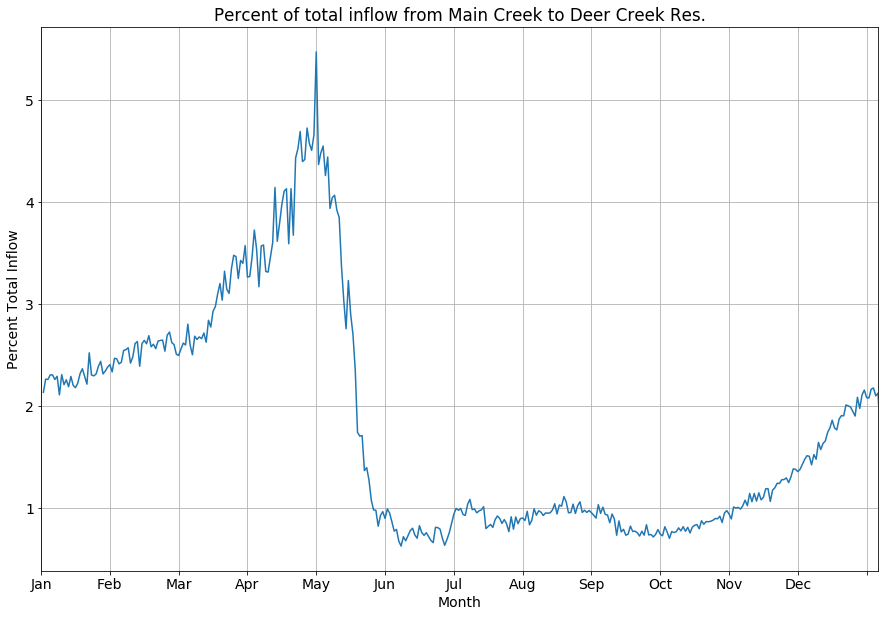

In [48]:
plt.plot(xm, [100*i for i in ym/dcy])
plt.grid()
plt.xlabel('Month')
print(np.median(maincrkUSGS/dcy))
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)
plt.ylabel('Percent Total Inflow')
plt.title("Percent of total inflow from Main Creek to Deer Creek Res.")
plt.savefig(figplace+'PercMonthlyDeerCreekInflow.svg')
plt.savefig(figplace+'PercMonthlyDeerCreekInflow.pdf')

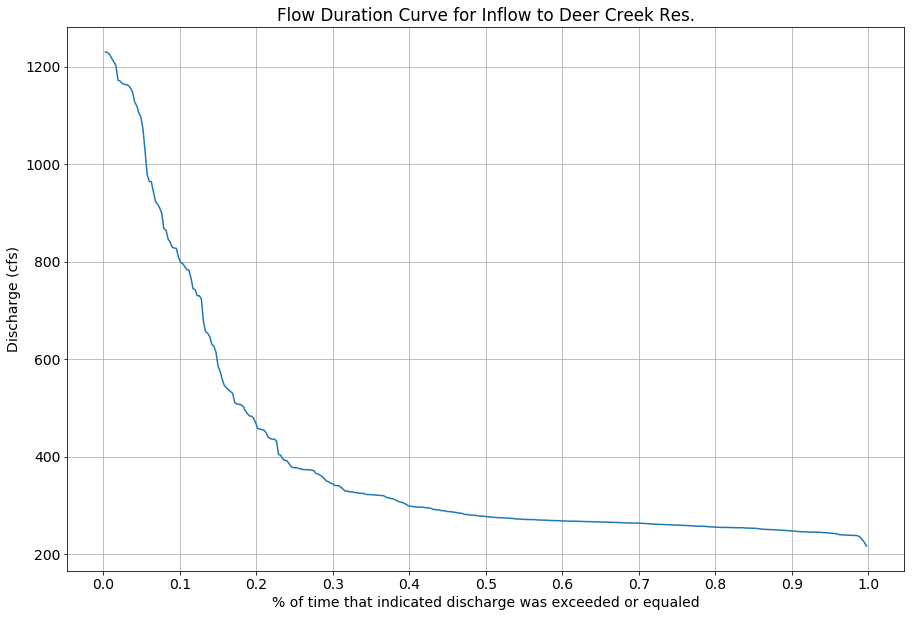

In [49]:
wa.fdc(DeerCreek,u'Computed Inflow (cfs)')
plt.grid()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.xticks(np.arange(0,1.1,0.1))
#plt.yticks(range(0,65,5))
plt.title('Flow Duration Curve for Inflow to Deer Creek Res.')
plt.savefig(figplace+'fdcDeerCreek.svg')
plt.savefig(figplace+'fdcDeerCreek.pdf')

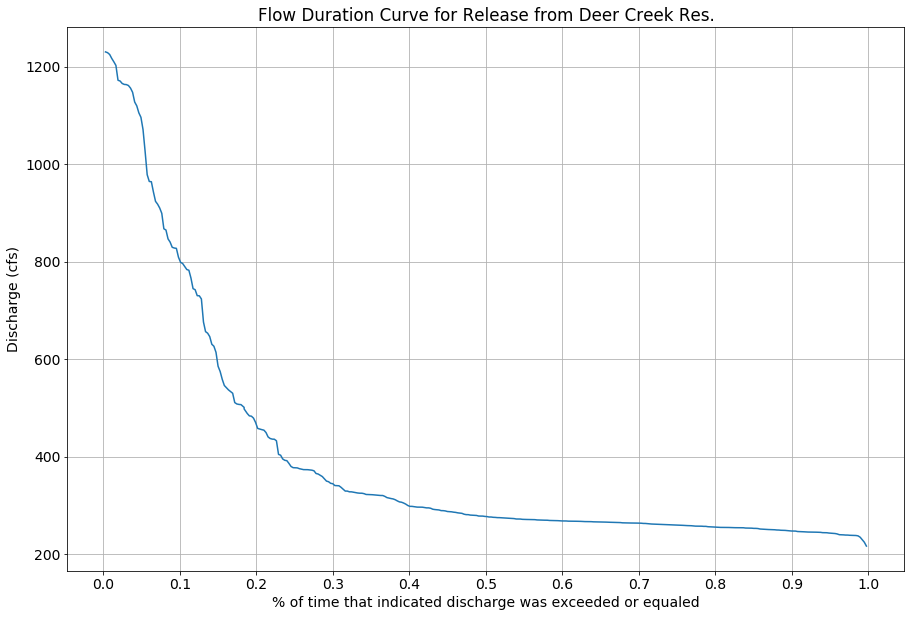

In [50]:
wa.fdc(DeerCreek,u'Computed Inflow (cfs)')
plt.grid()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.xticks(np.arange(0,1.1,0.1))
#plt.yticks(range(0,65,5))
plt.title('Flow Duration Curve for Release from Deer Creek Res.')
plt.savefig(figplace+'fdcOutDeerCreek.svg')
plt.savefig(figplace+'fdcOutDeerCreek.pdf')

## USGS Stations on Contributaries

connection successful
Gage height, feet skipped!
Gage height, feet skipped!
Gage height, feet skipped!


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\matplotlib\colors.py:496: RuntimeWarning:

invalid value encountered in less



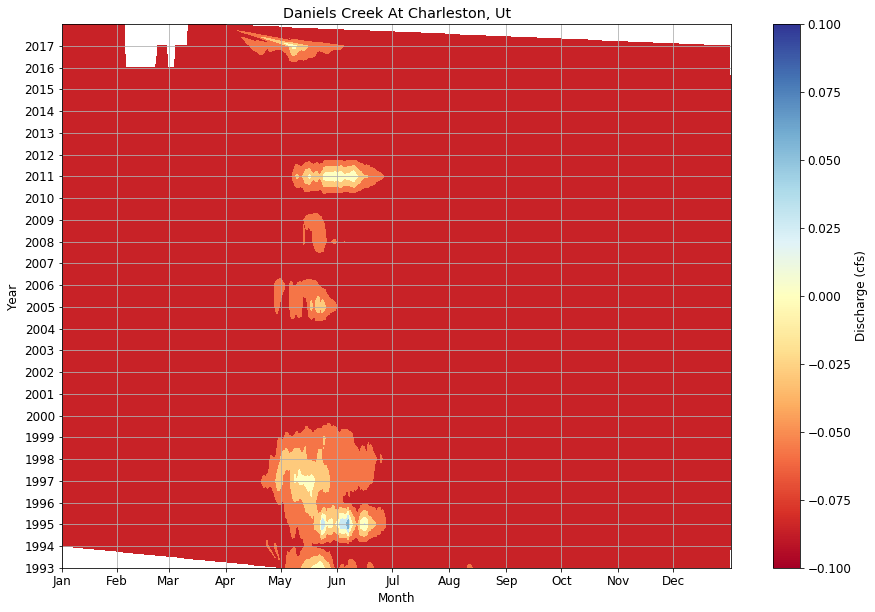

In [51]:
nw = wa.nwis('dv',10157500,'sites',startDT='1992-01-01')
rcParams['font.size'] = 12
nw.nwis_heat_map()

connection successful
Gage height, feet skipped!
Gage height, feet skipped!
Gage height, feet skipped!
Gage height, feet skipped!
Gage height, feet skipped!
Gage height, feet skipped!
2018-03-25 00:00:00


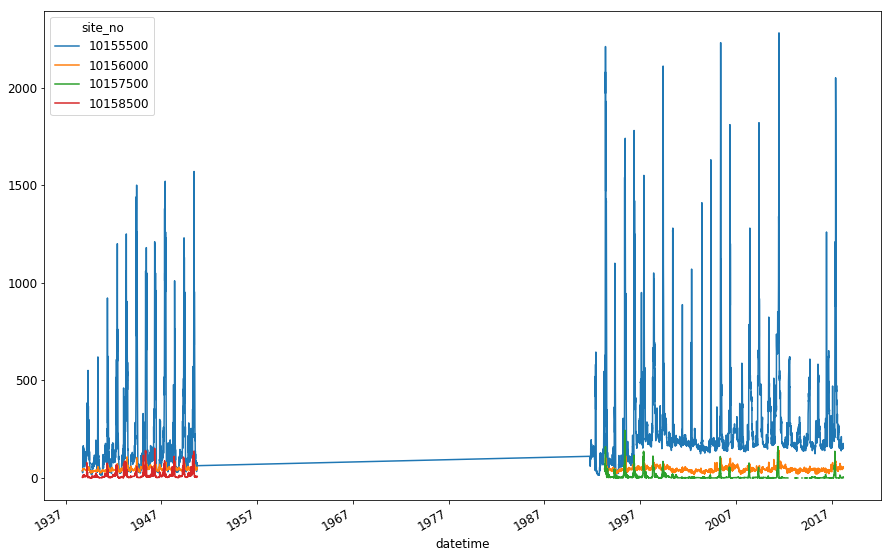

In [52]:
dcstr = wa.nwis('dv',[10155500,10157500,10156000,10158500],'sites')
cont = dcstr.data
cont.drop('qualifiers',axis=1, inplace=True)
cont = cont[cont['value']>0]
contpiv = cont.unstack(level=0)
contpiv = contpiv['value']
contpiv.plot()
contpiv.index = pd.to_datetime(contpiv.index)
print(contpiv['10155500'].last_valid_index())

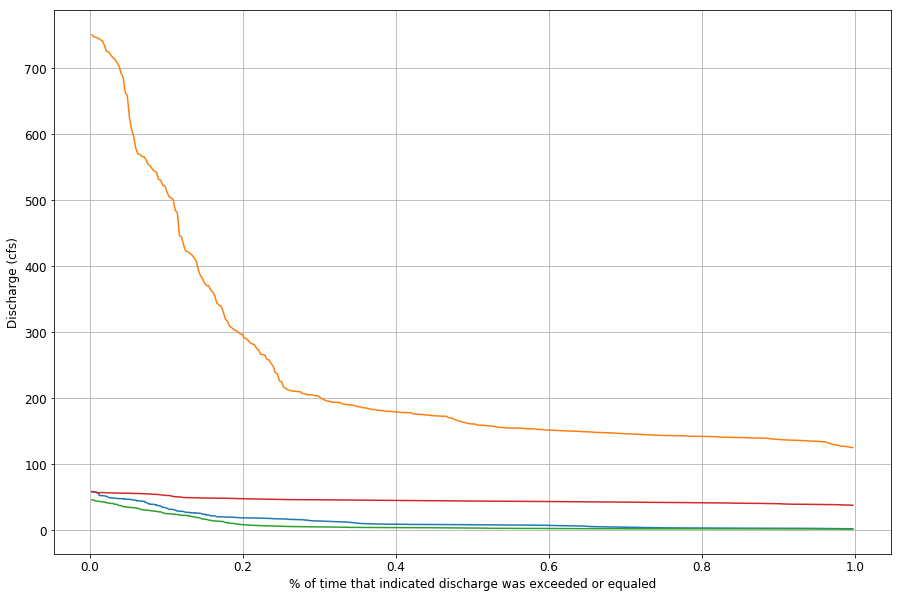

In [53]:
p8500,d8500 = wa.fdc(contpiv,'10158500')
p5500,d5500 = wa.fdc(contpiv,'10155500')
p7500,d7500 = wa.fdc(contpiv,'10157500')
p6000,d6000 = wa.fdc(contpiv,'10156000')
plt.grid()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')

### Contributaries

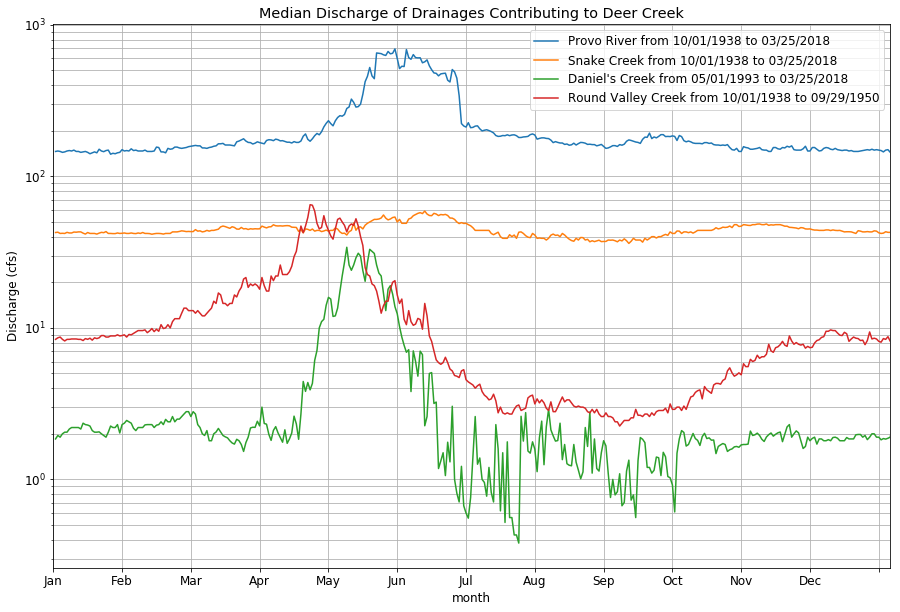

In [54]:
contpiv['doy'] = contpiv.index.dayofyear
statCols = [u'10155500', u'10156000', u'10157500', u'10158500']

LabDict = {'10158500':'Round Valley Creek','10155500':'Provo River',
           '10157500':'Daniel\'s Creek','10156000':'Snake Creek'}


def norm(x):
    return (x-np.mean())


for stat in statCols:
    grpnorm = contpiv.groupby(['doy'])[stat].median()
    plt.plot(grpnorm.index,grpnorm, label="{} from {:%m/%d/%Y} to {:%m/%d/%Y}".format(LabDict[stat],
                                                                                    contpiv[stat].first_valid_index(),
                                                                                    contpiv[stat].last_valid_index()))
    
plt.xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)
plt.yscale('log')
plt.legend()
plt.grid(which='both')
plt.title('Median Discharge of Drainages Contributing to Deer Creek')
plt.ylabel('Discharge (cfs)')
plt.savefig(figplace+'DeerCreekMonthlyHydroGraph.svg')

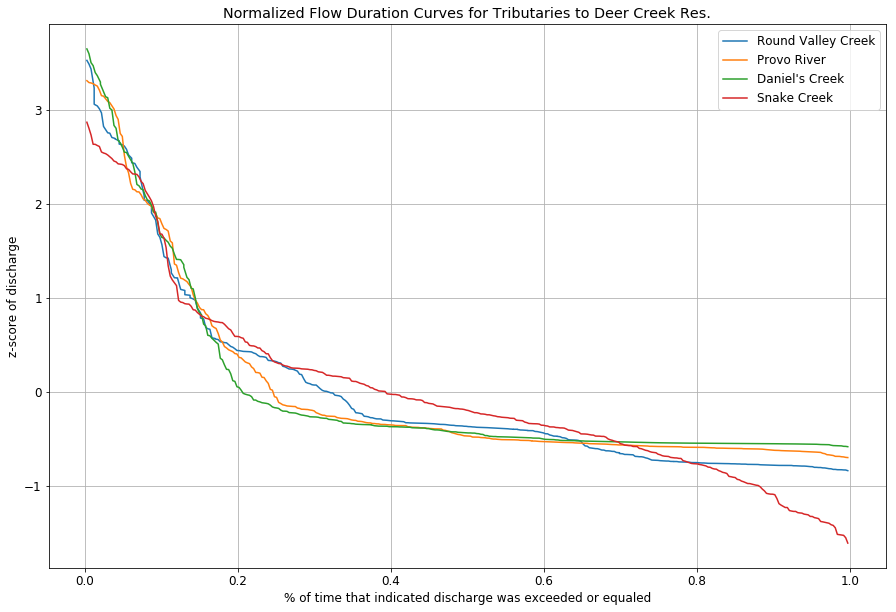

In [55]:
probdata = [p8500,p5500,p7500,p6000] 
flowdata = [d8500,d5500,d7500,d6000]
Labels = ['Round Valley Creek','Provo River','Daniel\'s Creek','Snake Creek']
normdata = []

plt.figure()
plt.title("Normalized Flow Duration Curves for Tributaries to Deer Creek Res.")
for data in flowdata:
    normdata.append((data-np.mean(data))/np.std(data))

for i in range(len(probdata)):
    plt.plot(probdata[i],normdata[i],label=Labels[i])
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.ylabel('z-score of discharge')
plt.legend()
plt.grid()

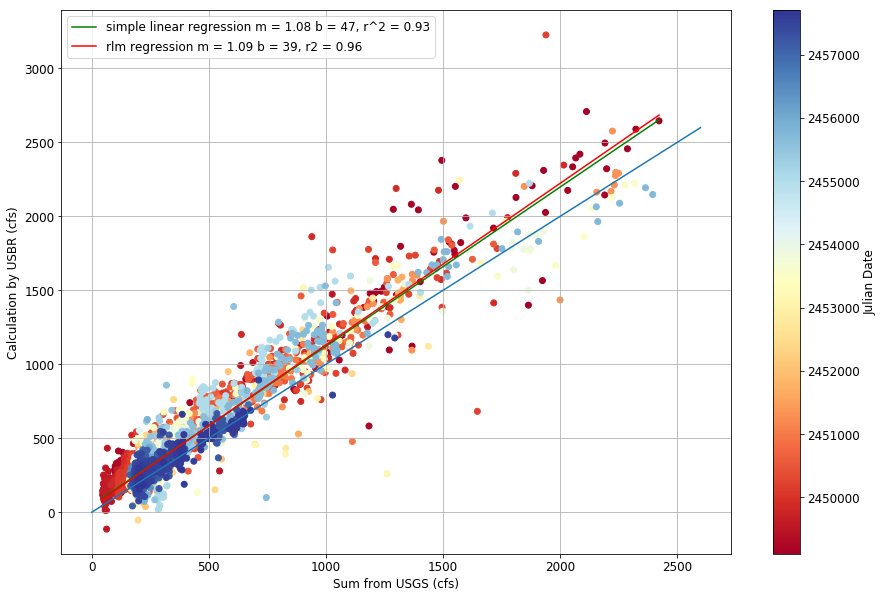

In [58]:
DrCrk = pd.merge(contpiv,DeerCreek,left_index=True,right_index=True)
DrCrk['HeberSum'] = DrCrk[['10155500','10156000','10157500']].apply(lambda x: x[0]+x[1]+x[2],1)

InChk = DrCrk.dropna(subset=['HeberSum','Computed Inflow (cfs)'])
x = InChk['HeberSum']
y = InChk['Computed Inflow (cfs)']
w = InChk.index.to_julian_date()

scatterColor(x,y,w)
plt.xlabel('Sum from USGS (cfs)')
plt.ylabel('Calculation by USBR (cfs)')
plt.plot(range(0,2700,100),range(0,2700,100))
plt.grid()

In [60]:
DrCrk.columns
DrCrk['USBR_In_afd'] = DrCrk[u'Computed Inflow (cfs)'] * 86400.193536 * 2.29569e-5
DrCrk['USGS_In_afd'] = DrCrk[u'HeberSum'] * 86400.193536 * 2.29569e-5
DrCrk['del_Stor_afd'] = DrCrk[u'Storage (a-f)'].diff()
DrCrk['Tot_Out_afd'] = DrCrk[u'Releases (cfs)'] * 86400.193536 * 2.29569e-5
DrCrk['In_sub_Out_afd'] = DrCrk['USBR_In_afd'] - DrCrk['Tot_Out_afd'] 
DrCrk['agency_diff'] = DrCrk['USBR_In_afd'] - DrCrk['USGS_In_afd']
DrCrk['doy'] = DrCrk.index.dayofyear
#DrCrk['Tot_Out_cfd'] = DrCrk[[u'Releases (cfs)',u'Power Releases (cfs)']].apply(lambda x: (x[0]+x[1])* 86400.193536,1)

In [62]:
DrCrk.groupby(DrCrk.index.dayofyear)['agency_diff'].mean().sum()

50768.775977318335

In [32]:
DrCrkStr = DrCrk[DrCrk.index > pd.datetime(1992,10,1)]

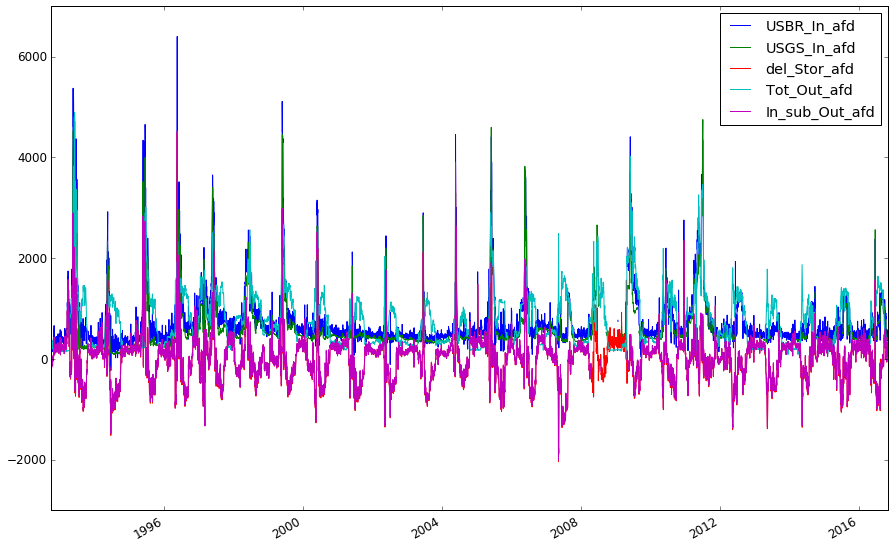

In [33]:
DrCrkStr[['USBR_In_afd','USGS_In_afd','del_Stor_afd','Tot_Out_afd','In_sub_Out_afd']].plot()

(0, 300)

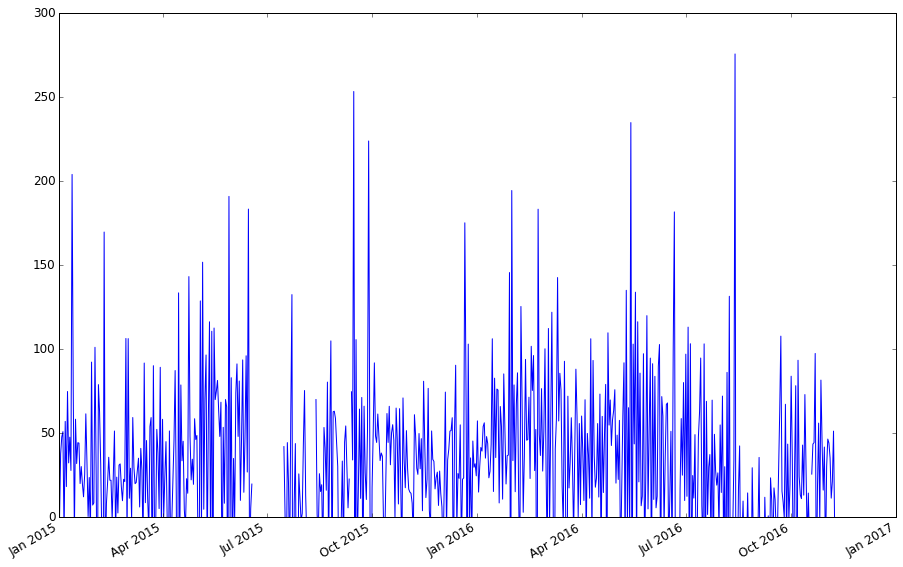

In [34]:
estMC = (DrCrkStr['USBR_In_afd'] - DrCrkStr['USGS_In_afd'])*0.504166
estMC.plot()
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
#plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(pd.datetime(2015,1,1),pd.datetime(2017,1,1))
plt.ylim(0,300)

In [35]:
grpd1 = DrCrkStr.groupby(['doy']).median()

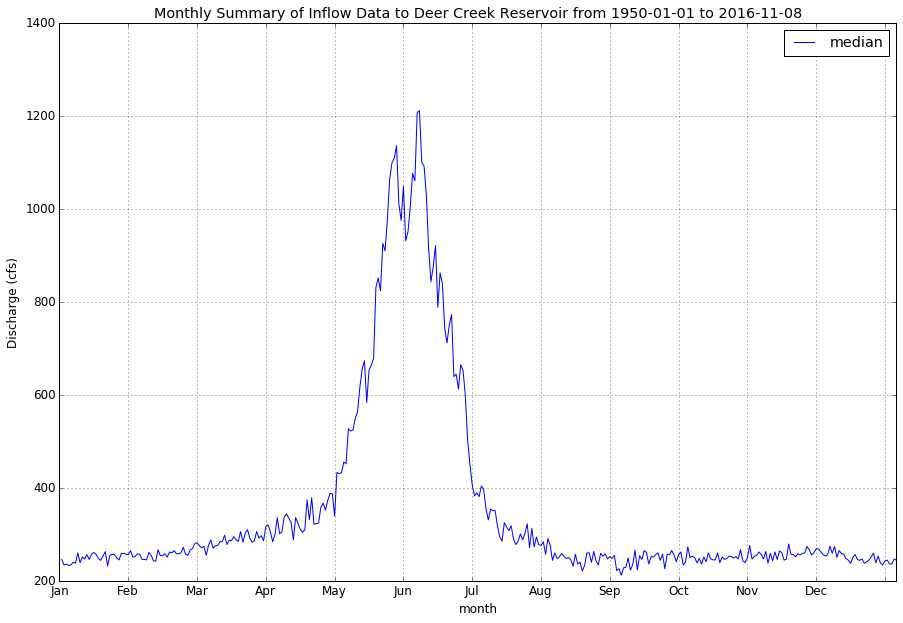

In [36]:
colm_headers = ['USBR_In_afd','USGS_In_afd','del_Stor_afd','Tot_Out_afd','In_sub_Out_afd']
grpd1 = DrCrkStr.groupby(['doy']).median()
dcx1 = grpd1.median().index
dcy1 = grpd1.median()
dcx1 = grpd1.quantile(q=0.1, interpolation='linear').index
dcy1 = grpd1.quantile(q=0.1)
dcx2 = grpd1.quantile(q=0.90).index
dcy2 = grpd1.quantile(q=0.90)

plt.plot(dcx,dcy, label='median')
#plt.plot(dcx,dcy1, label='10th percentile')
#plt.plot(dcx,dcy2, label='90th percentile')

plt.title("Monthly Summary of Inflow Data to %s from %s to %s" %('Deer Creek Reservoir', 
                                                                    datetime.datetime.strftime(DeerCreek[u'Computed Inflow (cfs)'].index.min(),
                                                                                      "%Y-%m-%d"), 
                                                                    datetime.datetime.strftime(DeerCreek[u'Computed Inflow (cfs)'].index.max(),
                                                                                      "%Y-%m-%d")))
plt.xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)

plt.legend()
plt.grid()

plt.ylabel('Discharge (cfs)')
plt.savefig(figplace+'DeerCreekMonthlyHydroGraph.svg')

## DEQ Data

### DEQ Flow Data

Import DEQ transducer data from file provided by Sandy Wingert.

In [10]:
raw_DEQ0 = pd.read_excel(fileplace+"Main Creek Continuous Temperature Data.xlsx",sheetname='5913460_040914_042215', 
                         skiprows=71, index_col='Date and Time',parse_cols=4)
raw_DEQ2 = pd.read_excel(fileplace+"042215_062116_5910619.xlsx",skiprows=71, index_col='Date and Time',parse_cols=4)


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

the 'parse_cols' keyword is deprecated, use 'usecols' instead

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning:

The `sheetname` keyword is deprecated, use `sheet_name` instead

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

the 'parse_cols' keyword is deprecated, use 'usecols' instead



In [11]:
raw_DEQ = pd.concat([raw_DEQ2,raw_DEQ0])
raw_DEQ.sort_index(inplace=True)
raw_DEQ.drop_duplicates(inplace=True)

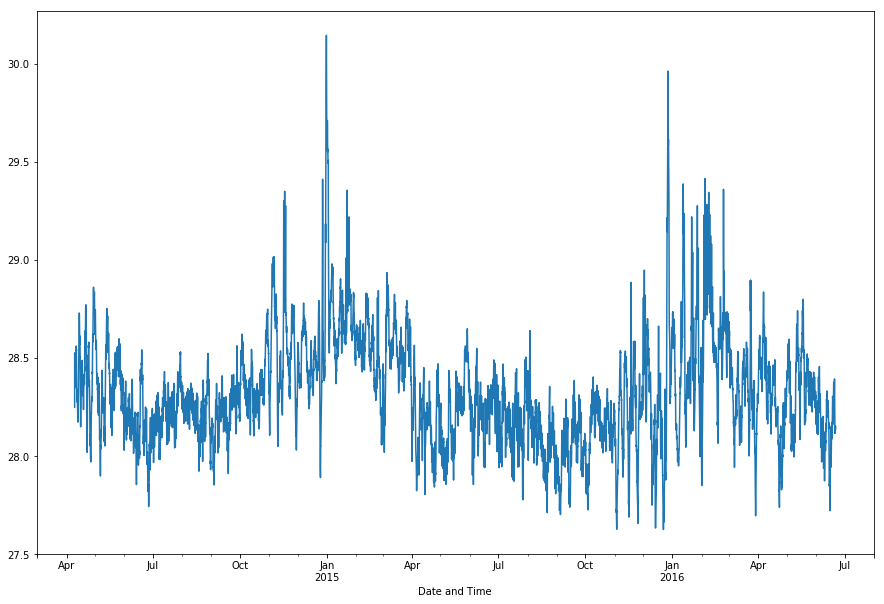

In [12]:
raw_DEQ.columns = [i.strip() for i in raw_DEQ.columns]
raw_DEQ['dDepth'] = raw_DEQ['Depth (ft)'].diff()
DEQ = raw_DEQ.groupby(level=0).first()
DEQdepth = wa.hourly_resample(DEQ, minutes=60)
DEQdepth['Depth (ft)'].plot()

Import barometric data from Heber Valley airport Mesowest station.

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\wellapplication\transport.py:90: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



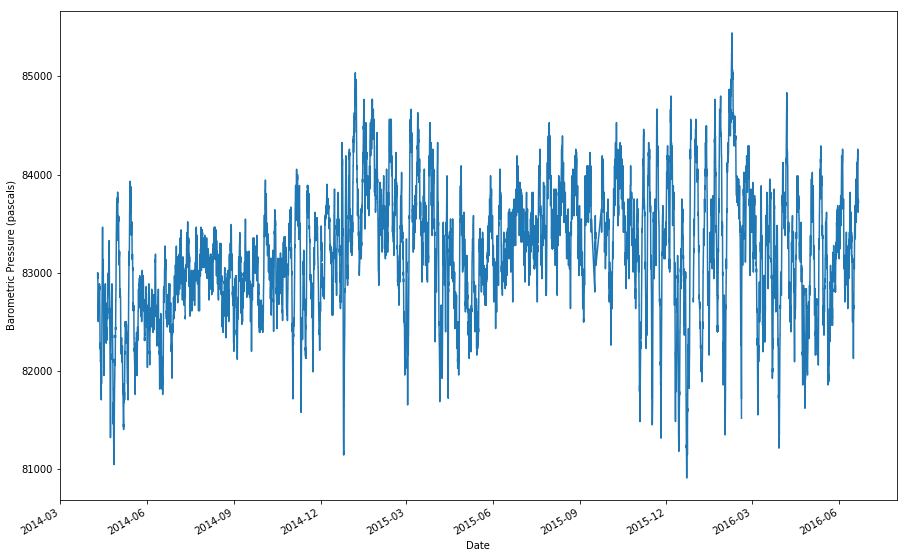

In [13]:
station = 'KHCR'
token = "1ab92e63dd924c6189e6d5e1015c2645"
begdate1 = datetime.datetime.strftime(DEQdepth.index[0],"%Y%m%d%H%M")
enddate1 = datetime.datetime.strftime(DEQdepth.index[int(len(DEQdepth)/2)],"%Y%m%d%H%M")
enddate2 = datetime.datetime.strftime(DEQdepth.index[-1],"%Y%m%d%H%M")
begdate2 = datetime.datetime.strftime(DEQdepth.index[int(len(DEQdepth)/2)],"%Y%m%d%H%M")

def getbaro(begdate,enddate,station,token):
    addrs = 'https://api.mesowest.net/v2/stations/timeseries?token={:}&stid={:}&state=ut&start={:}&end={:}&units=pres|mb&output=csv'
    html = addrs.format(token,station,begdate,enddate)
    baro = pd.read_csv(html,skiprows=8,usecols=[1,2,15],index_col=0,parse_dates=True,names=['datetime','pressure_pascals','precip_mm'])
    return baro

baro1 = getbaro(begdate1,enddate1,station,token)
baro2 = getbaro(begdate2,enddate2,station,token)

baro = pd.concat([baro1,baro2])


baro = wa.jumpfix(baro,'pressure_pascals',threashold=10000)
baro['pressure_pascals'].plot()
barores = wa.hourly_resample(baro, minutes=60)

barores['baro (ft)'] = barores['pressure_pascals']*0.000334562
barores['d_baro_ft'] = barores['baro (ft)'].diff()
plt.ylabel('Barometric Pressure (pascals)')
plt.xlabel('Date')

In [14]:
DEQfl = pd.concat([barores,DEQdepth], axis=1)
DEQfl.sort_index(inplace=True)
DEQfl.dropna(subset=['dDepth','d_baro_ft'],how='any',inplace=True)

Check for lag between Heber Valley weather station and Round Valley transducer data.

In [15]:
datax = DEQfl['d_baro_ft']
datay = DEQfl['dDepth']

xcov = [crosscorr(datax, datay, lag=i) for i in range(60)]
print(xcov[:20])

[0.041710874642055688, 0.068006968384898628, 0.10653075679527485, 0.18045080985403497, 0.26156106809781005, 0.35077739456448281, 0.47848500033845859, 0.48997092258358976, 0.34975078809829035, 0.19731622902438731, 0.095082362899726006, 0.010612424602490908, -0.041043608414510817, -0.053437386133232949, -0.047871411253270477, -0.031790253042397972, -0.012552435667854019, -0.0046667899801360645, -0.0041800357686824921, -0.0029576472177933193]


8.46427129342 0.713406957477


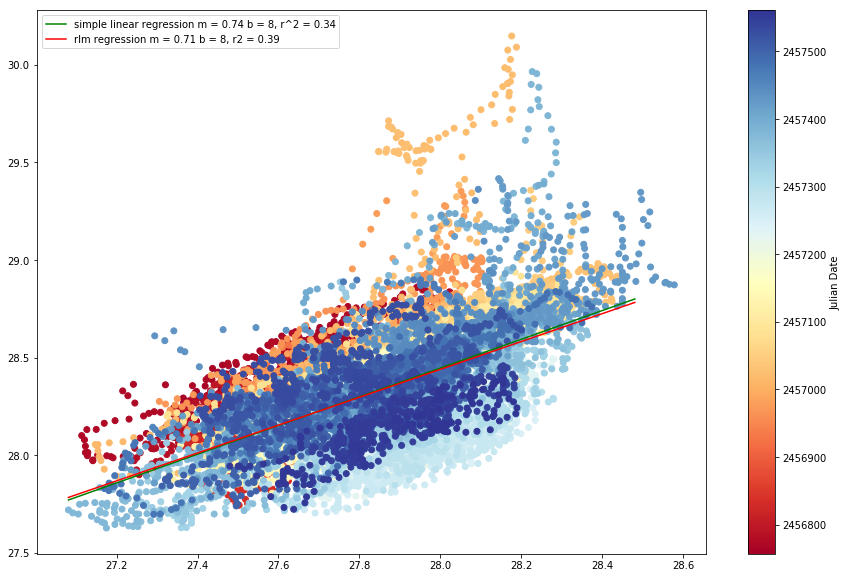

In [16]:
x0 = DEQfl['baro (ft)']
y = DEQfl['Depth (ft)']
w = DEQfl.index.to_julian_date()

slope, const = wa.scatterColor(x0, y, w)
print(const, slope)

def pfilt(x):
    '''
    filtered out measured pressure if temperature is below 0
    '''
    if x[1] <= 0:
        return np.nan
    else:
        return x[0]

DEQfl['filt_Press']  = DEQfl[['Depth (ft)','Temperature (C)']].apply(lambda x: pfilt(x), 1)

DEQfl['waterDepth'] = DEQfl[['baro (ft)','Depth (ft)']].apply(lambda x: x[1] - (x[0]*slope + const),1)

In [17]:
awqmsFile = fileplace + r'Standard Export 16567.xlsx'
awqms = pd.read_excel(awqmsFile,skiprows=1)

dropcols = []
for column in list(awqms.describe().columns):
    if awqms.describe().loc['count',column] == 0:
        dropcols.append(column)
        
awqms.drop(dropcols, axis=1, inplace=True)

awqms['datetime'] = awqms[["Activity Start Date","Activity Start Time"]].apply(lambda x: pd.to_datetime(str(x[0])[:11]+str(x[1])[-8:],
                                                                                                                  format='%Y-%m-%d %H:%M:%S',
                                                                                                                  errors='coerce'),1)
flowvalues = awqms[awqms[u'Characteristic Name']==u'Flow']
flowvalues.set_index('datetime',inplace=True)
flowvalues2 = flowvalues[(flowvalues['Monitoring Location Name']==u'MAIN CK AB DEER CK RES AT US 189 XING')|(flowvalues['Monitoring Location Name']==u'Main Creek 0.4 mile AB U.S. Highway 189 at driveway bridge')]
flowvalues3 =flowvalues2[(flowvalues2.index < pd.datetime(2016,6,22))&(flowvalues2.index > pd.datetime(2014,4,20))]

In [18]:
def eqn(x, a,b,c):
    return a*x+b+c

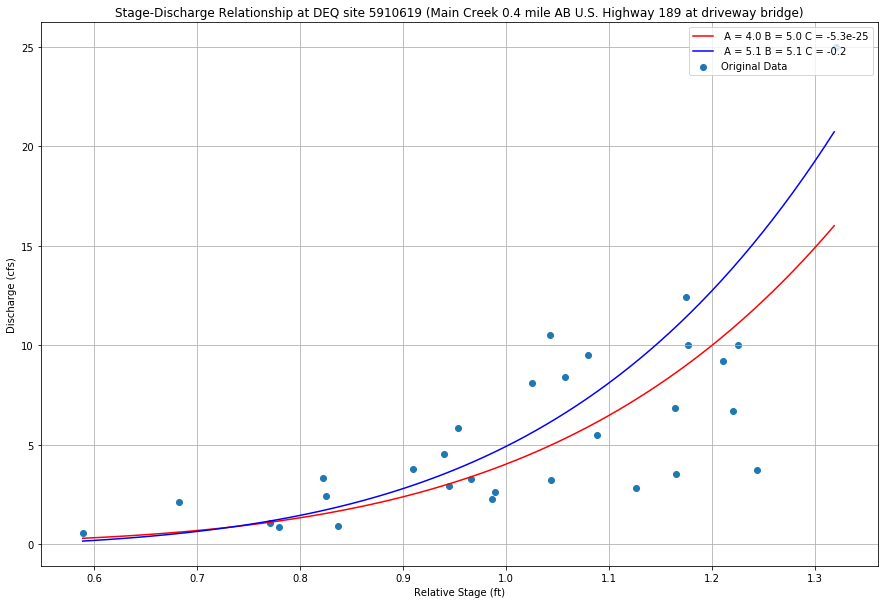

In [19]:
stage = flowvalues3['Result Value']
Q = DEQfl[(DEQfl['waterDepth']<0.4)&(DEQfl['waterDepth']<0.4)]['waterDepth'].rolling(window=24).mean()


def func(x, a, b, c):
    return a*(x)**(b) + c



MFQ = []

for j in stage.index:
    MFQ.append(wa.transport.fcl(Q, j)+1)
    
yn = stage.values
x = MFQ

bounds = ([0.75,5.0, -10.0],[30.0,10.0,0.0]) # ([1.0,0.0,1.0],[50.0, 5.0, 10.0])


popt, pcov = curve_fit(func, x, yn, bounds=bounds, max_nfev = 800000) #, method='trf')

sterr = np.sqrt(np.diag(pcov))


equation = 'Fitted Curve ' + r'$f(x)= (A \dot (x)^{B} + C)$ '
eqlab = ' A = {:.2} B = {:.2} C = {:.2}'


plt.figure()
plt.scatter(x, yn, label="Original Data")
xb = np.arange(np.min(x),np.max(x),0.01)
plt.plot(xb, [func(i, popt[0],popt[1],popt[2]) for i in xb], 'r-', label= eqlab.format(popt[0],popt[1],popt[2]))

p = [5.1,5.1,-0.2]
plt.plot(xb, [func(i, *p) for i in xb], 'b-', label= eqlab.format(*p))


plt.legend(loc=1,scatterpoints=1)
plt.ylabel('Discharge (cfs)')
plt.xlabel('Relative Stage (ft)')
plt.grid()
plt.title('Stage-Discharge Relationship at DEQ site 5910619 (Main Creek 0.4 mile AB U.S. Highway 189 at driveway bridge)')
plt.savefig(figplace + 'stageDischarge.svg')
plt.savefig(figplace + 'stageDischarge.pdf')


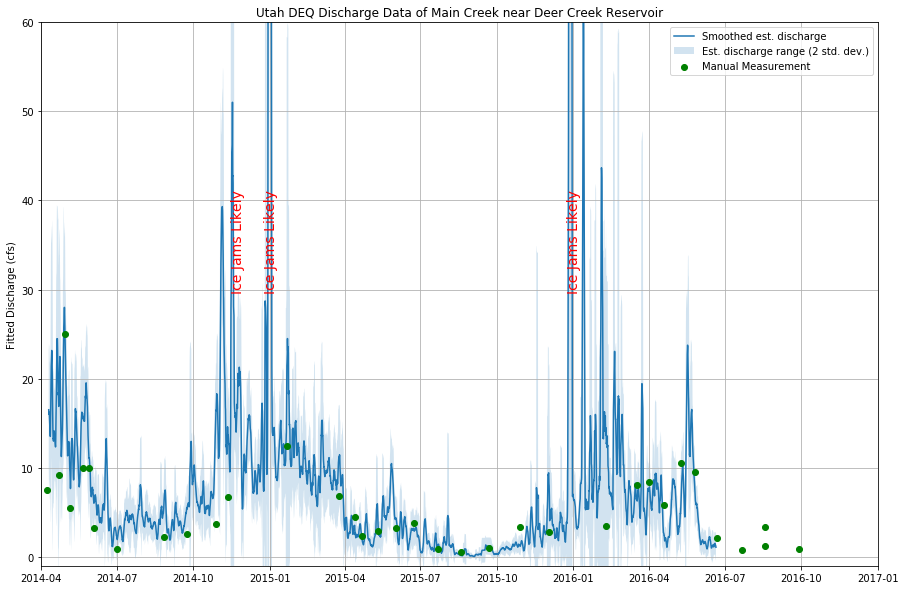

In [20]:
#p = popt
x = flowvalues2.index
y = flowvalues2['Result Value']
x1 = DEQfl.index
y1 = DEQfl.waterDepth
DEQfl['flow'] = DEQfl['waterDepth'].apply(lambda x: func(x+1.0, *p), 1)

y3 = DEQfl['flow'].rolling(50,center=True).mean()
y2 = y3+DEQfl['flow'].rolling(50,center=True).std()*2
y4 = y3-DEQfl['flow'].rolling(50,center=True).std()*2

plt.fill_between(x1,y2,y4,alpha=.2,zorder=1, label='Est. discharge range (2 std. dev.)')
plt.plot(x1,y3, label='Smoothed est. discharge')
plt.scatter(x, y, zorder=10, color='green', label='Manual Measurement')
plt.xlim('4/1/2014','1/1/2017')
plt.ylim(-1,60)
plt.ylabel('Fitted Discharge (cfs)')
plt.grid()
plt.title('Utah DEQ Discharge Data of Main Creek near Deer Creek Reservoir')
plt.text('11/15/2014',40,'Ice Jams Likely',rotation=90, fontsize=14, color='red')
plt.text('12/25/2014',40,'Ice Jams Likely',rotation=90, fontsize=14, color='red')
plt.text('12/25/2015',40,'Ice Jams Likely',rotation=90, fontsize=14, color='red')
plt.legend(scatterpoints=1)

plt.savefig(figplace + 'estDischarge.svg')

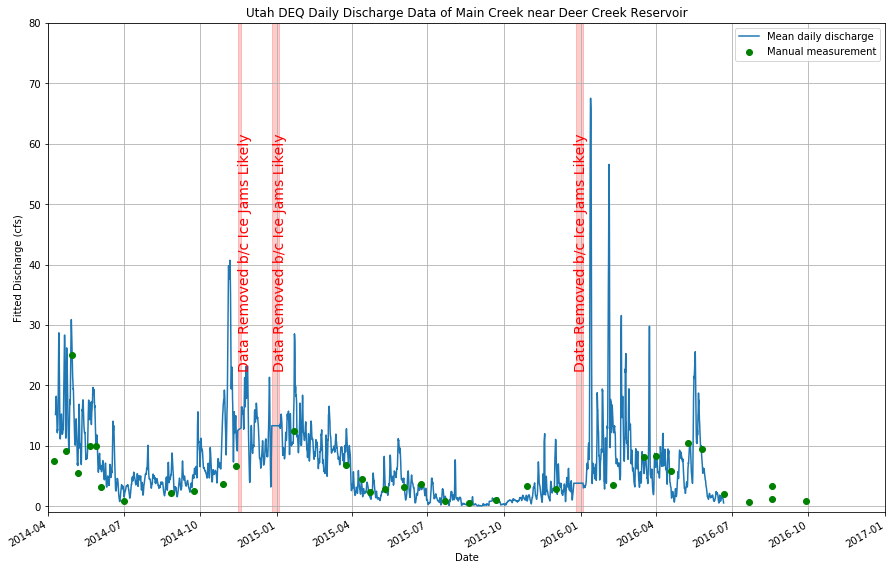

In [21]:
DEQflClip = DEQfl[(DEQfl.index < pd.datetime(2014,11,15))|(DEQfl.index > pd.datetime(2014,11,19))]
DEQflClip = DEQflClip[(DEQflClip.index < pd.datetime(2014,12,26))|(DEQflClip.index > pd.datetime(2015,1,4))]
DEQflClip = DEQflClip[(DEQflClip.index < pd.datetime(2015,12,24))|(DEQflClip.index > pd.datetime(2016,1,4))]
DEQflClip['flow'].rolling(24,center=True).mean().plot(label='Mean daily discharge')

x = flowvalues2.index
y = flowvalues2['Result Value']
plt.scatter(x, y, zorder=10, color='green', label='Manual measurement')
plt.axvspan('11/15/2014','11/19/2014',color='red',alpha=0.2)
plt.axvspan('12/26/2014','1/4/2015',color='red',alpha=0.2)
plt.axvspan('12/26/2015','1/4/2016',color='red',alpha=0.2)
plt.xlim('4/1/2014','1/1/2017')
plt.ylim(-1,80)
plt.ylabel('Fitted Discharge (cfs)')
plt.xlabel('Date')
plt.grid()
plt.title('Utah DEQ Daily Discharge Data of Main Creek near Deer Creek Reservoir')
plt.text('11/15/2014',60,'Data Removed b/c Ice Jams Likely',rotation=90, fontsize=14, color='red')
plt.text('12/27/2014',60,'Data Removed b/c Ice Jams Likely',rotation=90, fontsize=14, color='red')
plt.text('12/24/2015',60,'Data Removed b/c Ice Jams Likely',rotation=90, fontsize=14, color='red')
plt.legend(scatterpoints=1)
plt.savefig(figplace + 'estDailyDEQDischarge.svg')
plt.savefig(figplace + 'estDailyDEQDischarge.pdf')

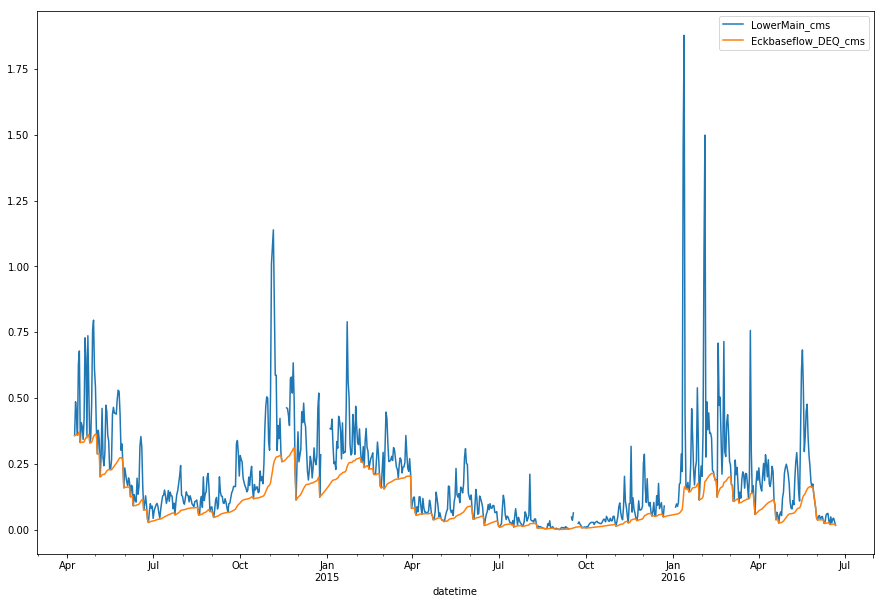

In [22]:
DEQmeandly = DEQflClip['flow'].resample('1D').mean().to_frame()
DEQmeandly['flow_int'] = DEQmeandly['flow'].interpolate(method='time')

DEQmeandly.loc[:,'Eckbaseflow_DEQ'] = wa.Eckhardt(DEQmeandly['flow_int'].values, alpha=0.997, BFI=0.90)

DEQmeandly.loc[:,'LowerMain_cms'] = DEQmeandly['flow'].apply(lambda x: round(x * 0.0283168,3),1)
DEQmeandly.loc[:,'Eckbaseflow_DEQ_cms'] = DEQmeandly['Eckbaseflow_DEQ'] * 0.0283168

DEQmeandly[['LowerMain_cms','Eckbaseflow_DEQ_cms']].plot()
DEQmeandly[['LowerMain_cms','Eckbaseflow_DEQ_cms']].to_clipboard()

In [23]:
DEQmeandly.to_pickle(fileplace+"deqmeandaily.pickle")

In [24]:
acftQ = np.sum(DEQmeandly.groupby(DEQmeandly.index.dayofyear)['LowerMain_cms'].mean()*86400.0)*0.000810714
acftBF = np.sum(DEQmeandly.groupby(DEQmeandly.index.dayofyear)['Eckbaseflow_DEQ_cms'].mean()*86400.0)*0.000810714

wy_2015 = DEQmeandly.loc[pd.datetime(2014,10,1):pd.datetime(2015,10,1),['LowerMain_cms','Eckbaseflow_DEQ_cms']]
wy_2015['LowerMain_cmd'] = wy_2015['LowerMain_cms']*86400.0
wy_2015['Eckbaseflow_DEQ_cmd'] = wy_2015['Eckbaseflow_DEQ_cms']*86400.0
Q_wy_2015_acft = wy_2015['LowerMain_cmd'].sum()*0.000810714
BF_wy_2015_acft = wy_2015['Eckbaseflow_DEQ_cmd'].sum()*0.000810714

print('DEQ Meas Volume Main Crk = {:0.0f} ac-ft/yr'.format(acftQ))
print('DEQ Meas Volume Baseflow Main Crk = {:0.0f} ac-ft/yr'.format(acftBF))

print('DEQ Meas Volume Main Crk water year 2015 = {:0.0f} ac-ft/yr'.format(Q_wy_2015_acft))
print('DEQ Meas Volume Baseflow Main Crk water year 2015 = {:0.0f} ac-ft/yr'.format(BF_wy_2015_acft))

DEQ Meas Volume Main Crk = 4802 ac-ft/yr
DEQ Meas Volume Baseflow Main Crk = 2707 ac-ft/yr
DEQ Meas Volume Main Crk water year 2015 = 4604 ac-ft/yr
DEQ Meas Volume Baseflow Main Crk water year 2015 = 2853 ac-ft/yr


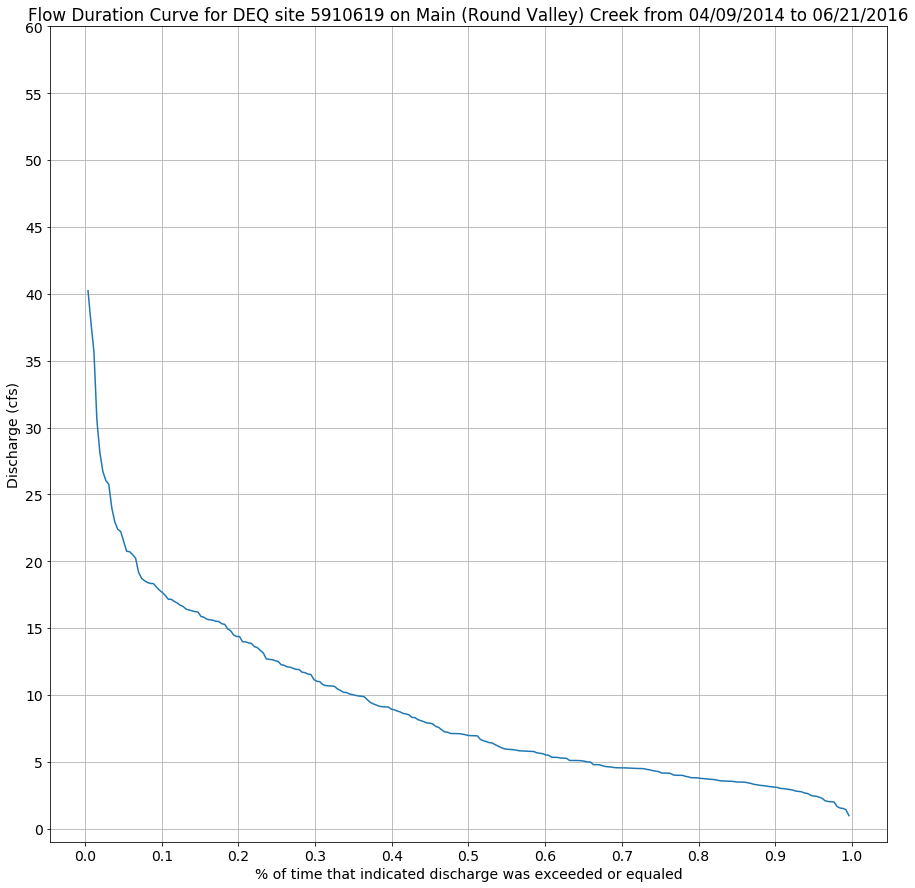

In [162]:
wa.fdc(DEQflClip, 'flow')
plt.grid()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(range(0,65,5))
plt.title('Flow Duration Curve for DEQ site 5910619 on Main (Round Valley) Creek from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(DEQflClip.index.min(),DEQflClip.index.max()))
plt.savefig(figplace + 'fdcMainCreekDEQ.svg')
plt.savefig(figplace + 'fdcMainCreekDEQ.svg')

In [163]:
def fdc_simple(df, site, begyear=1900, endyear=2018, normalizer=1, plot=True):
    '''
    Generate flow duration curve for hydrologic time series data

    PARAMETERS:
        df = pandas dataframe of interest; must have a date or date-time as the index
        site = pandas column containing discharge data; must be within df
        begyear = beginning year of analysis; defaults to 1900
        endyear = end year of analysis; defaults to 2015
        normalizer = value to use to normalize discharge; defaults to 1 (no normalization)

    RETURNS:
        matplotlib plot displaying the flow duration curve of the data

    REQUIRES:
        numpy as np
        pandas as pd
        matplotlib.pyplot as plt
        scipy.stats as sp
    '''
    # limit dataframe to only the site
    df = df[[site]]

    # filter dataframe to only include dates of interest
    data = df[(df.index.to_datetime() > pd.datetime(begyear,1,1))&(df.index.to_datetime() < pd.datetime(endyear,1,1))]

    # remove na values from dataframe
    data = data.dropna()

    # take average of each day of year (from 1 to 366) over the selected period of record
    data['doy']=data.index.dayofyear
    dailyavg = data[site].groupby(data['doy']).mean()
    dailymed = data[site].groupby(data['doy']).median()
    dailystdp = data[site].groupby(data['doy']).mean() + data[site].groupby(data['doy']).std()*2
    dailystdm = data[site].groupby(data['doy']).mean() - data[site].groupby(data['doy']).std()*2
    data = np.sort(dailyavg)
    datastdp = np.sort(dailystdp)
    datastdm = np.sort(dailystdm)
    datastdm = [0 if i < 0 else i for i in datastdm]
    datamed = np.sort(dailymed)
    ## uncomment the following to use normalized discharge instead of discharge
    #mean = np.mean(data)
    #std = np.std(data)
    #data = [(data[i]-np.mean(data))/np.std(data) for i in range(len(data))]
    data = [(data[i])/normalizer for i in range(len(data))]

    # ranks data from smallest to largest
    ranks = sp.rankdata(data, method='average')

    # reverses rank order
    ranks = ranks[::-1]

    # calculate probability of each rank
    prob = [(ranks[i]/(len(data)+1)) for i in range(len(data)) ]

    # plot data via matplotlib
    if plot == True:
        plt.plot(prob,data,label=site+' '+str(begyear)+'-'+str(endyear))
    else:
        pass
    return prob, data, datastdp, datastdm, datamed

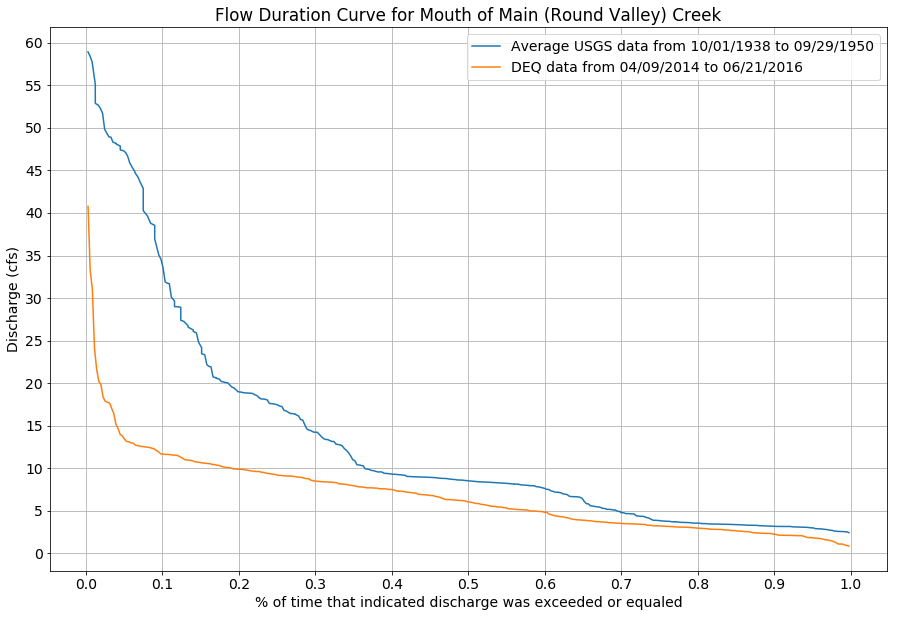

In [164]:
p1, d1, stdp1, stdm1, med1 = fdc_simple(MainUSGS,'value',plot=False)
p2, d2, stdp2, stdm2, med2 = fdc_simple(DEQflClip,'flow',plot=False)

rcParams['figure.figsize'] = 15, 10
plt.title('Flow Duration Curve for Mouth of Main (Round Valley) Creek')
plt.plot(p1,d1,label='Average USGS data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(MainUSGS.index.min(),MainUSGS.index.max()))
plt.plot(p2,d2,label='DEQ data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(DEQflClip.index.min(),DEQflClip.index.max()))
#plt.fill_between(p1,stdm1,stdp1,alpha=.3)
plt.grid()
plt.legend()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.xticks(np.arange(0,1.1,0.1))

plt.yticks(range(0,65,5))
plt.savefig(figplace + 'fdc_all_MainCreek.svg')
plt.savefig(figplace + 'fdc_all_MainCreek.pdf')

In [165]:
DEQflClip['doy'] = DEQflClip.index.dayofyear

### DEQ Long-Term Flow

In [25]:
DEQ_long_flow = pd.read_excel(fileplace+'flow_check_wqp.xlsx','Sheet1')
DEQ_long_flow.set_index('datetime',inplace=True)
DEQ_long_flow.drop_duplicates(inplace=True)

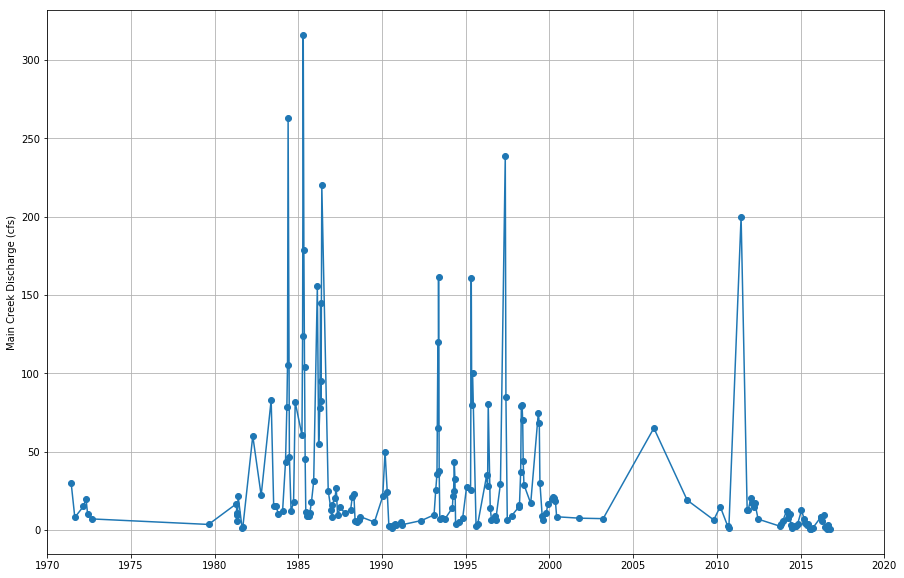

In [26]:
DEQ_long_flow = pd.read_excel(fileplace+'flow_check_wqp.xlsx','Sheet1')
DEQ_long_flow.set_index('datetime',inplace=True)
DEQ_long_flow.drop_duplicates(inplace=True)

plt.figure()
x = DEQ_long_flow.index
y = DEQ_long_flow.Flow_cfs
y0 = y*60.3307
plt.plot(x,y,'o-')
plt.ylabel('Main Creek Discharge (cfs)')
plt.xlim('1/1/1970','1/1/2020')
plt.grid()
plt.savefig(figplace+'DEQ_long_term.pdf')
#plt.xticks()



In [168]:
DEQ_long_flow.to_pickle(fileplace+"deq_long_flow.pickle")

In [169]:
stats

<module 'scipy.stats' from 'C:\\Program Files\\ArcGIS\\Pro\\bin\\Python\\envs\\arcgispro-py3\\lib\\site-packages\\scipy\\stats\\__init__.py'>

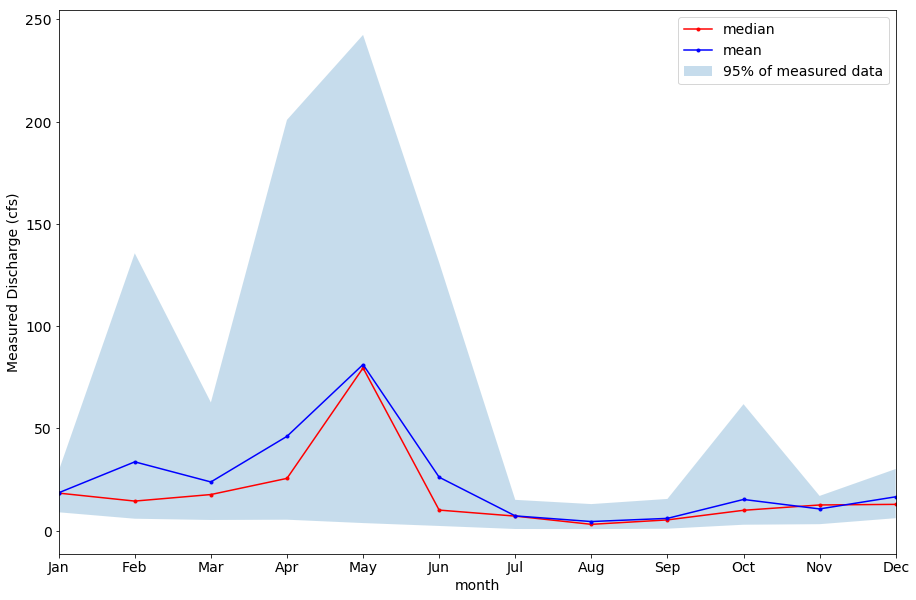

In [170]:
medQ = DEQ_long_flow.groupby(DEQ_long_flow.index.month).median()
avgQ = DEQ_long_flow.groupby(DEQ_long_flow.index.month).mean()
stdQ = DEQ_long_flow.groupby(DEQ_long_flow.index.month).std()
lowQ = DEQ_long_flow.groupby(DEQ_long_flow.index.month).agg(lambda x: np.percentile(x,2.5))
highQ = DEQ_long_flow.groupby(DEQ_long_flow.index.month).agg(lambda x: np.percentile(x,97.5))
stats = pd.concat([medQ,avgQ,stdQ,lowQ,highQ],axis=1)
stats.columns = ['medQ','avgQ','stdQ','lowQ','highQ']


plt.figure()
plt.plot(medQ.index,medQ,'r.-',label='median')
plt.plot(avgQ.index,avgQ,'b.-',label= 'mean')
plt.fill_between(stats.index, stats.lowQ, stats.highQ,alpha=0.25,label='95% of measured data')
plt.xlim(1,12)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13),months)
plt.xlabel('month')
plt.ylabel('Measured Discharge (cfs)')
plt.legend()

### DEQ Temperature Data

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



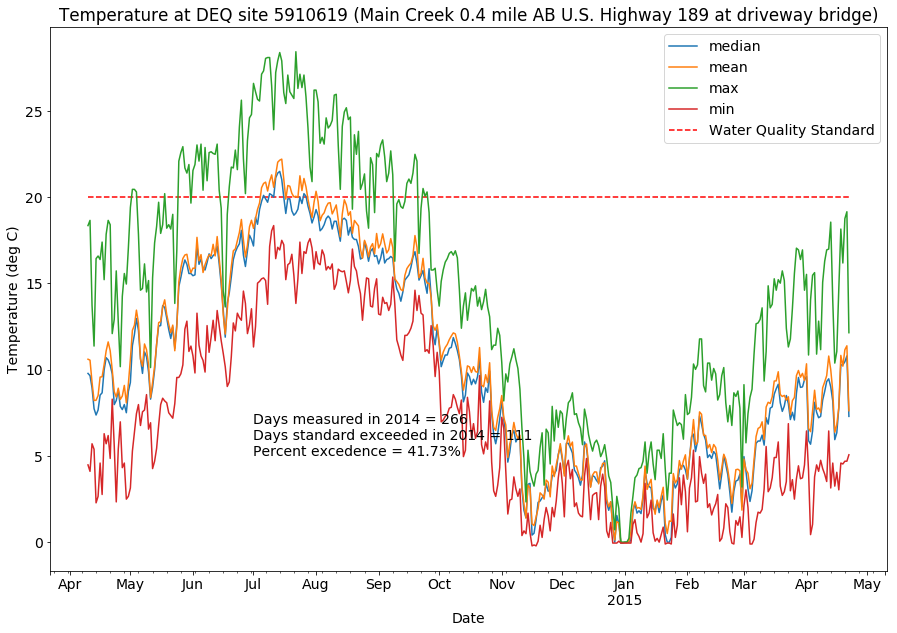

In [171]:
fileplace= 'G:/My Drive/WORK/Round_Valley/Data/Hydrology_Data/'
raw_DEQ = pd.read_excel(fileplace+"Main Creek Continuous Temperature Data.xlsx", skiprows=71, index_col='Date and Time')
raw_DEQ.columns = [i.strip() for i in raw_DEQ.columns]
dailyDEQ = raw_DEQ.groupby(pd.TimeGrouper('D'))['Temperature (C)'].agg({'max':max, 'mean':np.mean, 'median':np.median, 'min':min})
dailyDEQ.drop(pd.datetime(2014,4,9), axis=0, inplace=True)
dailyDEQ['Threshold'] = dailyDEQ['max'].apply(lambda x: int(x > 20), 1)
dailyDEQ['CumulThresh'] = dailyDEQ['Threshold'].cumsum()
dailyDEQ[['median', 'mean','max','min']].plot()
plt.hlines(20,dailyDEQ.index[0],dailyDEQ.index[-1], label='Water Quality Standard', color='red', linestyles='dashed')
plt.legend()
plt.ylabel('Temperature (deg C)')
plt.xlabel('Date')
plt.title('Temperature at DEQ site 5910619 (Main Creek 0.4 mile AB U.S. Highway 189 at driveway bridge)')

dailyDEQ2014 = dailyDEQ[dailyDEQ.index.year == 2014]
n = dailyDEQ2014['Threshold'].count()
more20 = dailyDEQ2014[dailyDEQ2014['Threshold']==1]['Threshold'].count()  
prcnt = round(((float(more20)/float(n))*100.0),2)

plt.text('7/1/2014',5,'Days measured in 2014 = {0} \nDays standard exceeded in 2014 = {1} \nPercent excedence = {2}%'.format(n, more20, prcnt))
plt.savefig(figplace + 'DEQTemperature.pdf')

## UGS Data

### Raw Stream Data

In [126]:
names = ['UpperMain','LowerMain','SpringCreek','LittleHobble','Barometer'] #Strings in file names

dfs={}
for name in names:
    df = {}
    filelist = glob.glob(fileplace+'TransducerFiles/'+'*'+name+'*'+'.xle') # select all files with name string
    for i in range(len(filelist)): #iterate through all files with same name (should have different dates)
            df[str(i)+'_raw'] = wa.transport.new_xle_imp(filelist[i]) #import
            df[str(i)] = wa.transport.dataendclean(df[str(i)+'_raw'],'Level')['Level'] #clean ends
            df[str(i)] = wa.transport.hourly_resample(df[str(i)],bse=0,minutes=30) #resample to match times

    dfs[name] = pd.concat([df[str(i)] for i in range(len(filelist))],axis=0) #combine all files of the same name
    dfs[name].sort_index(inplace=True) #sort to make in chronological order
    dfs[name] = dfs[name].groupby(level=0).first().to_frame() #remove duplicate datetime index values
    print(name)
    #dfs[name] = wa.transport.jumpfix(dfs[name],'Level',0.15)['Level'] #remove jumps from moving the transducer
    dfs[name].dropna(inplace=True) #drop null values
d = pd.concat([dfs[name] for name in names], axis=1, keys=names) #combine all the data
d.columns = d.columns.droplevel(1)


UpperMain
LowerMain
SpringCreek
Units in psi, converting 20160802_LittleHobble.xle to ft...
LittleHobble
Units in psi, converting 20170201_Barometer.xle to ft...
Dropped from end to 2017-02-03 07:30:00
Dropped from end to 2017-02-03 08:00:00
Dropped from end to 2017-02-03 09:30:00
Units in psi, converting 20161102_Barometer.xle to ft...
Barometer


In [127]:
screwpeaks = d[(d.index >pd.datetime(2017,2,1,6))&(d.index <pd.datetime(2017,3,4))]['LittleHobble'].rolling(14, center=True).max()
d.loc['2017-02-01 06:00:00':'2017-03-04 01:00:00','LittleHobble'] = screwpeaks
hobjump = 0.8559-27.73622
d.loc['2017-02-01 06:00:00':,'LittleHobble'] = d.loc['2017-03-04 01:00:00':,'LittleHobble']+hobjump
d.loc['2016-08-16 15:30:00','LittleHobble'] = 0.75

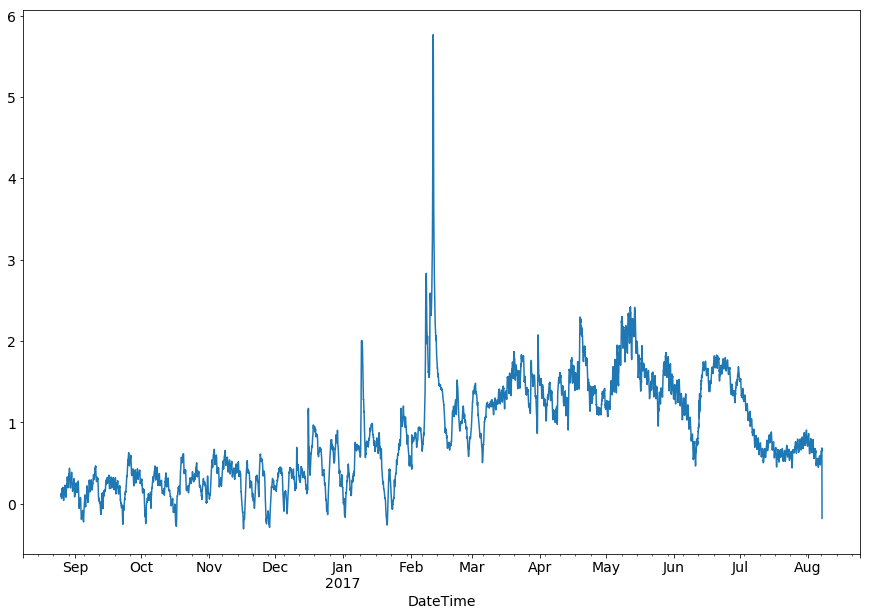

In [128]:
d['LowerMain'].plot()

Import and concatonate transducer data. Remove jumps and end (out of water) measurements. Remove na measurement values. Sort data.

In [129]:
token = "1ab92e63dd924c6189e6d5e1015c2645"
station = 'KHCR'
token = "1ab92e63dd924c6189e6d5e1015c2645"
begdate = datetime.datetime.strftime(d.index[0],"%Y%m%d%H%M")
enddate = datetime.datetime.strftime(d.index[-1],"%Y%m%d%H%M")
addrs = 'https://api.mesowest.net/v2/stations/timeseries?token={:}&stid={:}&state=ut&start={:}&end={:}&units=pres|mb&output=csv'
html = addrs.format(token,station,begdate,enddate)
print(html)
baro = pd.read_csv(html,skiprows=8,usecols=[1,2],index_col=0,
                   parse_dates=True,
                   names=['datetime','pressure_pascals'])
#baro['precip_in'] = baro['precip_mm'].apply(lambda x: pd.to_numeric(x)/254.0,1)

https://api.mesowest.net/v2/stations/timeseries?token=1ab92e63dd924c6189e6d5e1015c2645&stid=KHCR&state=ut&start=201608161030&end=201708071000&units=pres|mb&output=csv


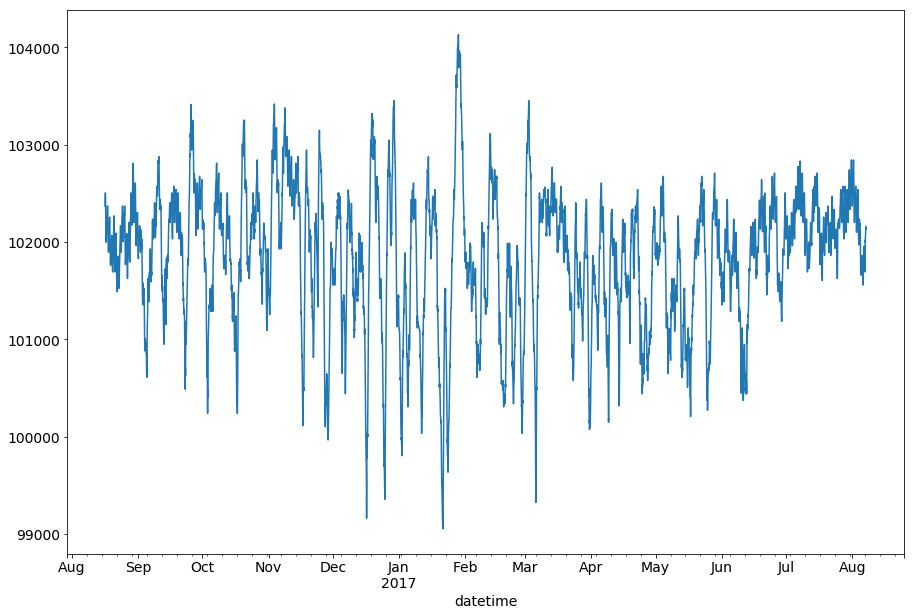

In [130]:
barores = baro.resample('1min').mean()
barores = barores.interpolate(how='time')
barores = barores.resample('15min').mean()
barores['pressure_pascals'].plot()
baro = pd.read_csv(html,skiprows=8,usecols=[1,2],index_col=0,parse_dates=True,names=['datetime','pressure_pascals'])
baro = wa.transport.jumpfix(baro,'pressure_pascals',threashold=10000)
barores = wa.transport.hourly_resample(baro, minutes=60).shift(-6) #UTC to MDT
barores['baro (ft)'] = barores['pressure_pascals']*0.000334562

barores['StatBaro'] =barores['baro (ft)'] - (barores['baro (ft)'].mean()-d['Barometer'].mean())
bar = barores[u'StatBaro'].to_frame()

dd = pd.merge(d,bar,right_index=True,left_index=True)

def fillB(x):
    if np.isnan(x[0]):
        return x[1]
    else:
        return x[0]

dd['Barometer'] = dd[['Barometer','StatBaro']].apply(lambda x: fillB(x),1)

Remove barometric pressure (non-vented transducers)

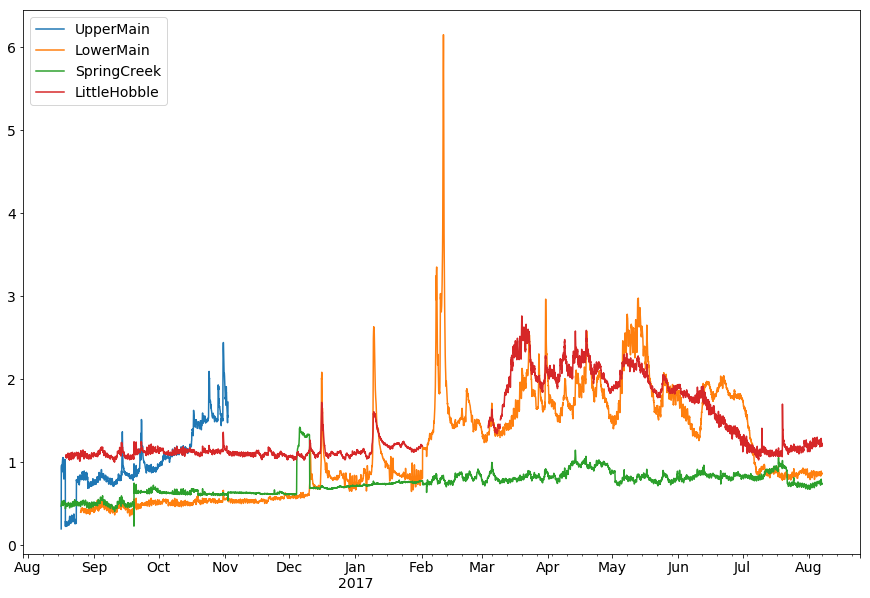

In [131]:
Qcolumns = [u'UpperMain', u'LowerMain', u'SpringCreek', u'LittleHobble']
# Reference determined using linear interpolation (intercept value); slope is 1.0

for i in range(len(Qcolumns)):
    dd['adj'+ Qcolumns[i]] = dd[[Qcolumns[i],'Barometer']].apply(lambda x: x[0] - (x[1]- 27.9889),1)
    dd['adj'+ Qcolumns[i]].plot(label=Qcolumns[i])

plt.legend(loc=2)
#plt.xlim('8/15/2016','11/2/2016')

Manually adjust jumps in data

In [132]:
dd.loc['2016-12-04 13:00:00':'2016-12-10 17:00:00','adjSpringCreek'] = None
dd.loc['2016-12-04 13:00:00':,'adjSpringCreek'] = dd.loc['2016-12-04 13:00:00':,'adjSpringCreek'] - 0.08
dd.loc['2016-09-19 13:00:00':,'adjSpringCreek'] = dd.loc['2016-09-19 13:00:00':,'adjSpringCreek'] - 0.14
dd.loc['2016-11-02 09:00:00':,'adjSpringCreek'] = dd.loc['2016-11-02 09:00:00':,'adjSpringCreek']- 0.025
#dd.loc['2017-07-21 19:00:00':,'adjSpringCreek']=dd.loc['2017-07-21 19:00:00':,'adjSpringCreek']+0.17
dd['adjSpringCreek'] = dd['adjSpringCreek'] - 0.08

dd.loc['2017-02-01 09:00:00':,'adjLowerMain'] = dd.loc['2017-02-01 09:00:00':,'adjLowerMain'] - 0.36

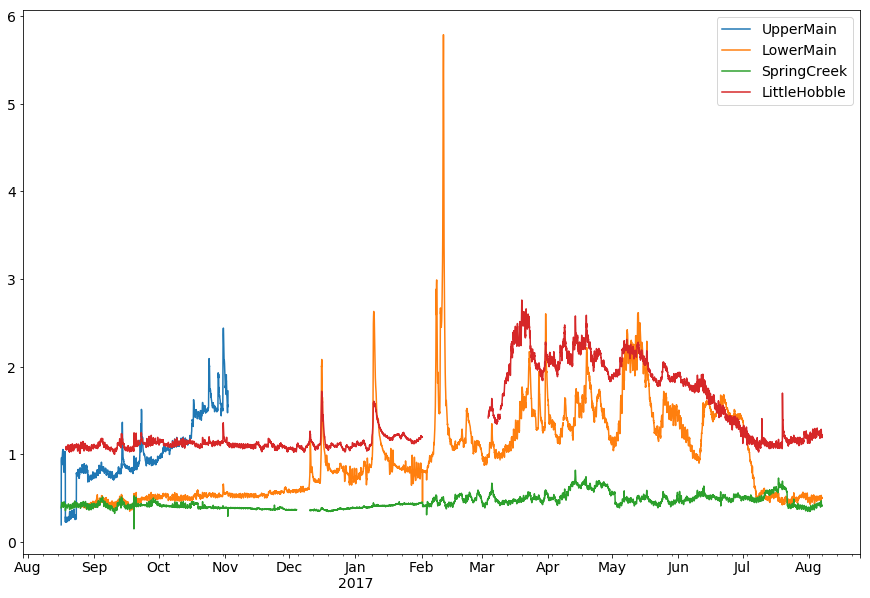

In [133]:
Qcolumns = [u'UpperMain', u'LowerMain', u'SpringCreek', u'LittleHobble']
# Reference determined using linear interpolation (intercept value); slope is 1.0

for i in range(len(Qcolumns)):
    dd['adj'+ Qcolumns[i]].plot(label=Qcolumns[i])
plt.legend()

### Little Hobble

[ 1.00000001  3.7        -0.95620298]


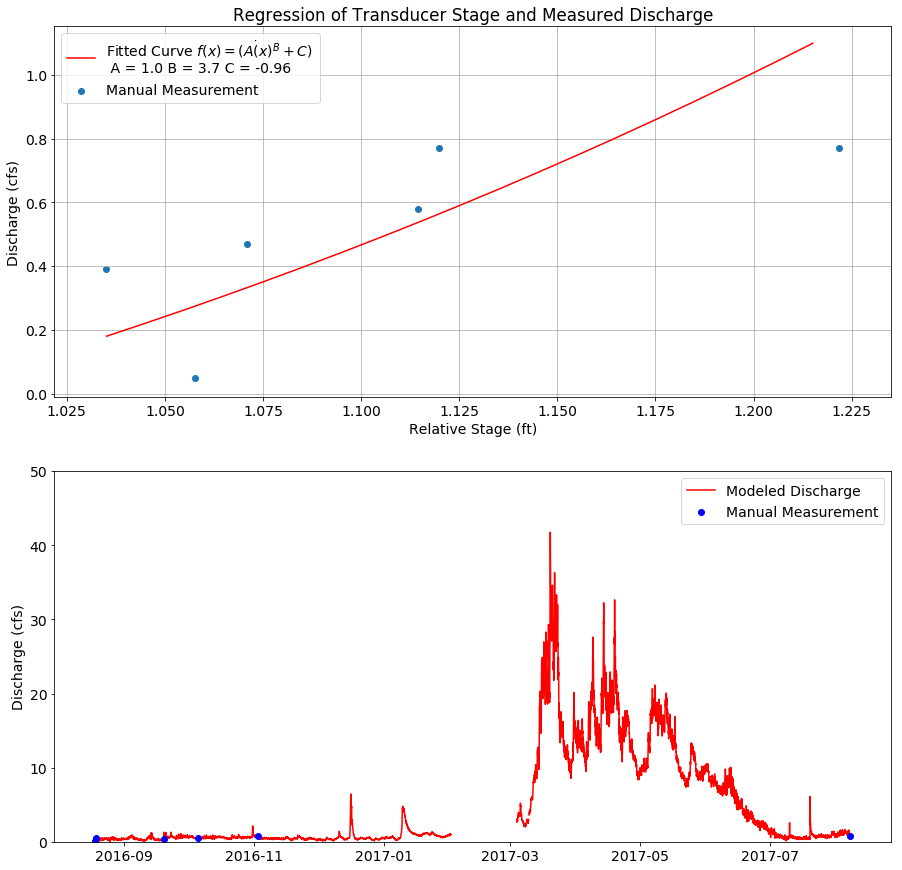

In [134]:
Qcolumns = [u'LittleHobble']
forks = [u'LittleHobble']
flow = pd.read_csv(fileplace+'ManualMeasurements.csv',index_col=0,parse_dates=True)
rcParams['figure.figsize'] = 15, 15
i=0

dfSub = dd['adj' + Qcolumns[i]].to_frame()
dfSub.dropna(inplace=True)
MFflow = flow[flow.Fork==forks[i]]
MFQ = []
for j in range(len(MFflow)):
    MFQ.append(wa.transport.fcl(dfSub, MFflow.index[j])['adj' + Qcolumns[i]])


x = MFQ
yn = MFflow.CFS

def func(x, a, b, c):
    return a*(x)**(b) + c

popt, pcov = curve_fit(func, x, yn, bounds = ([1.0,3.7,-10.0],[30.0,50.0,10.0]),
                      max_nfev=80000)

sterr = np.sqrt(np.diag(pcov))
print(popt)

gs = gridspec.GridSpec(2, 1)
rcParams['figure.figsize'] = 15, 15
plt.figure()
ax1 = plt.subplot(gs[0, 0])
ax1.set_title('Regression of Transducer Stage and Measured Discharge')
ax2 = plt.subplot(gs[1, 0])

ax1.scatter(x, yn, label='Manual Measurement')
xb = np.arange(np.min(x),np.max(x),0.01)
yb = [func(j, popt[0],popt[1],popt[2]) for j in xb]
equation = 'Fitted Curve ' + r'$f(x)= (A \dot (x)^{B} + C)$ '
eqlab = ' A = {:.2} B = {:.2} C = {:.2}'
ax1.plot(xb, yb, 'r-', label= equation+'\n'+eqlab.format(*popt))

ax1.legend(loc=2, scatterpoints=1)
ax1.grid()
ax1.set_ylabel('Discharge (cfs)')
ax1.set_xlabel('Relative Stage (ft)')

dd[forks[i] + '_cfs'] = dd['adj' + Qcolumns[i]].apply(lambda x: func(x, *popt), 1)


x = dd.index
y = dd[forks[i] + '_cfs']

x1 = MFflow.index
y1 = MFflow.CFS


ax2.plot(x,y,color='red',label='Modeled Discharge',zorder=0)
ax2.scatter(x1,y1,color='blue',label='Manual Measurement',zorder=1)
#plt.fill_between(x,dd[forks[i] + '_cfs_min'],dd[forks[i] + '_cfs_max'],alpha=0.5)
ax2.legend(scatterpoints=1)
ax2.set_ylabel('Discharge (cfs)')
ax2.set_ylim(0,50)
#ax2.title(forks[i])
plt.savefig(figplace + 'DischargeStage.svg')
plt.savefig(figplace + 'DischargeStage.pdf')


In [135]:
x = dd.index
y = dd['LittleHobble_cfs']
lhcfs = dd.dropna(subset=['LittleHobble_cfs'])['LittleHobble_cfs'].resample('1D').mean().to_frame()
hcflow = lhcfs.values
hcindex = lhcfs.index

lhcfs.loc[:,'Eckbaseflow_UGS'] = wa.Eckhardt(hcflow, alpha=0.997, BFI=0.80)

lhcfs.loc[:,'Eckbaseflow_UGS_cfd'] = lhcfs['Eckbaseflow_UGS'] * 86400
lhcfs.loc[:,'LittleHobble_cms'] = lhcfs['LittleHobble_cfs'].apply(lambda x: round(x * 0.0283168,3),1)
lhcfs.loc[:,'Eckbaseflow_UGS_cms'] = lhcfs['Eckbaseflow_UGS'] * 0.0283168
lhcfs.to_clipboard()

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\wellapplication\usgs.py:567: RuntimeWarning:

invalid value encountered in greater



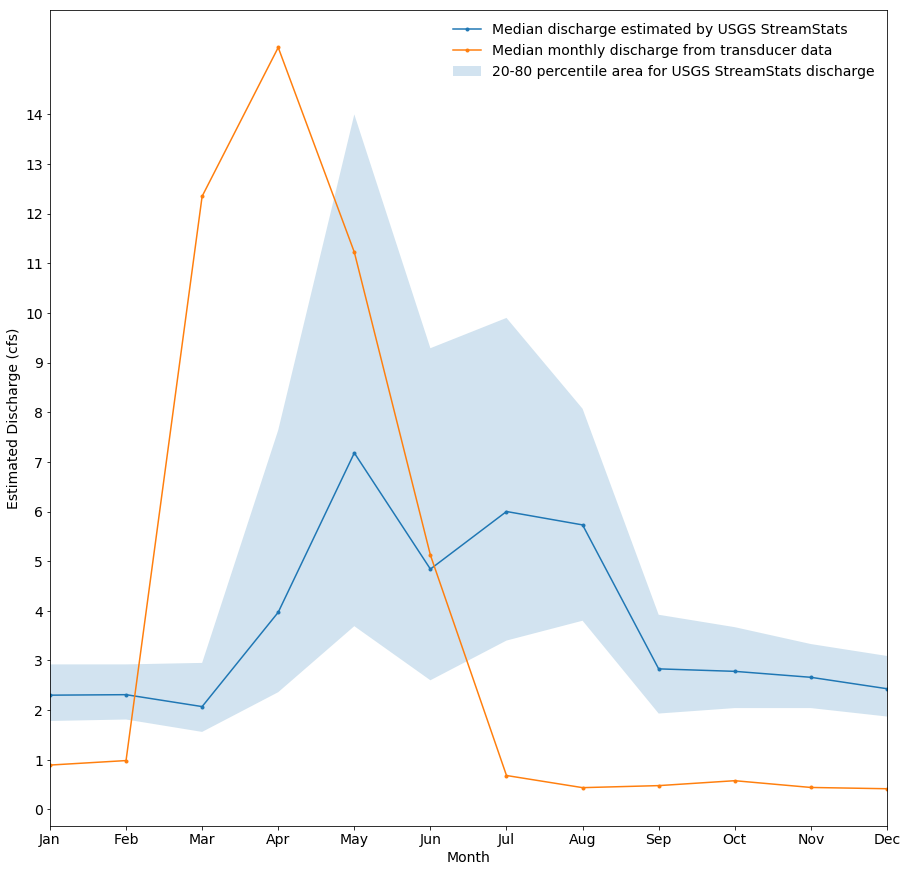

In [136]:
lh_stream_stats = pd.read_excel(fileplace+'LittleHobbleStreamStats.xlsx','Flows',index_col=[0,1])
lh_stream_stats.drop(['SEp'],inplace=True,axis=1)
lh_stream_stats=lh_stream_stats.unstack(level=-1)
lh_stream_stats.columns=lh_stream_stats.columns.droplevel(0)

plt.plot(lh_stream_stats.index,lh_stream_stats[50], '.-',label='Median discharge estimated by USGS StreamStats')
plt.fill_between(lh_stream_stats.index,lh_stream_stats[20],lh_stream_stats[80],alpha=0.20, label = '20-80 percentile area for USGS StreamStats discharge')
lhmed = dd['LittleHobble_cfs'].groupby(dd.index.month).median()
plt.plot(lhmed.index,lhmed,'.-',label='Median monthly discharge from transducer data')
plt.xlim(1,12)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13),months)
plt.yticks(range(0,15))
plt.xlabel('Month')
plt.ylabel('Estimated Discharge (cfs)')
plt.legend(frameon=False)
plt.savefig(figplace+'StreamStatsComparison_LH.pdf')

### Spring Creek (Wallsburg Spring)

http://www.tandfonline.com/doi/full/10.1080/19942060.2016.1157100

In [137]:
def culvertQ(depth, diam=22):
    colv = np.sqrt(32.2*(diam/12)**6)*0.716
    return (colv*0.5**(depth))*(depth)**2.175

culvertQ(.4)

2.586031111227471

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)



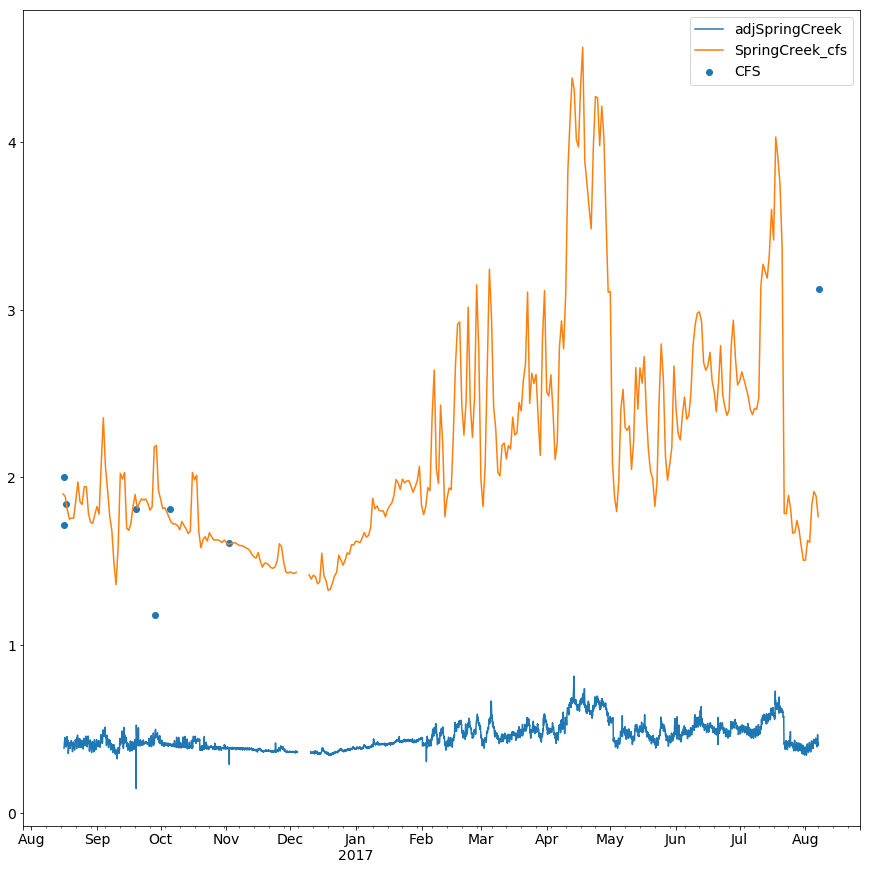

In [138]:
dd['adjSpringCreek'].plot()
dd['SpringCreek_cfs'] = dd['adjSpringCreek'].apply(lambda x: culvertQ(x, diam=19.15),1)
dd.groupby(pd.TimeGrouper('D'))['SpringCreek_cfs'].median().plot()
flow = pd.read_csv(fileplace+'ManualMeasurements.csv',index_col=0,parse_dates=True)
sc_flow = flow[flow.Fork == 'SpringCreek']
x = sc_flow.index
y = sc_flow.CFS

plt.scatter(x,y)
plt.legend()

In [145]:
dd.columns

Index(['UpperMain', 'LowerMain', 'SpringCreek', 'LittleHobble', 'Barometer',
       'StatBaro', 'adjUpperMain', 'adjLowerMain', 'adjSpringCreek',
       'adjLittleHobble', 'LittleHobble_cfs', 'SpringCreek_cfs',
       'LowerMain_cfs'],
      dtype='object')

In [146]:
dd.groupby(pd.Grouper(freq='M')).mean()

UpperMain  LowerMain  SpringCreek  LittleHobble  Barometer  \
2016-08-31   0.400048   0.210904     0.256100      0.835037  27.751628   
2016-09-30   0.602493   0.201219     0.289372      0.839412  27.724902   
2016-10-31   1.029821   0.214345     0.317775      0.818978  27.683407   
2016-11-30   1.410941   0.294855     0.373736      0.846397  27.739751   
2016-12-31        NaN   0.422886     0.462238      0.768765  27.649498   
2017-01-31        NaN   0.570036     0.362355      0.820119  27.610480   
2017-02-28        NaN   1.283071     0.366771      0.860375  27.562613   
2017-03-31        NaN   1.350808     0.504124      1.657240  27.683320   
2017-04-30        NaN   1.421660     0.519341      1.730599  27.589148   
2017-05-31        NaN   1.666011     0.405915      1.611875  27.599087   
2017-06-30        NaN   1.394256     0.498821      1.283019  27.660670   
2017-07-31        NaN   0.783586     0.639937      0.972729  27.808831   
2017-08-31        NaN   0.629768     0.512616      1.001201  27.770643   

             StatBaro  adjUpperMain  adjLowerMain  adjSpringCreek  \
2016-08-31  27.751628      0.637588      0.415295        0.413372   
2016-09-30  27.739969      0.866492      0.465218        0.419898   
2016-10-31  27.700627      1.335315      0.519838        0.403269   
2016-11-30  27.762640      1.703338      0.544316        0.379031   
2016-12-31  27.660860           NaN      0.762288        0.367470   
2017-01-31  27.614631           NaN      0.948456        0.415775   
2017-02-28  27.562910           NaN      1.358577        0.470029   
2017-03-31  27.683320           NaN      1.297010        0.484126   
2017-04-30  27.589148           NaN      1.462478        0.595077   
2017-05-31  27.599087           NaN      1.695824        0.470728   
2017-06-30  27.660670           NaN      1.362486        0.502051   
2017-07-31  27.808831           NaN      0.604019        0.495251   
2017-08-31  27.770643           NaN      0.491429        0.404427   

            adjLittleHobble  LittleHobble_cfs  SpringCreek_cfs  LowerMain_cfs  
2016-08-31         1.076189          0.359697         1.818148       2.281094  
2016-09-30         1.103411          0.494341         1.876693       2.968453  
2016-10-31         1.124284          0.592145         1.734218       3.784228  
2016-11-30         1.095546          0.449338         1.539953       4.193220  
2016-12-31         1.108167          0.569657         1.451503       9.879338  
2017-01-31         1.198539          1.081830         1.837186      17.150360  
2017-02-28         1.195970          0.982816         2.321861      31.170200  
2017-03-31         1.996886         14.128223         2.448864      32.073735  
2017-04-30         2.130914         15.852529         3.561844      39.812469  
2017-05-31         2.001688         12.405042         2.324325      58.147042  
2017-06-30         1.611249          5.284547         2.610156      33.987849  
2017-07-31         1.152803          0.762190         2.582537       6.410770  
2017-08-31         1.218569          1.130393         1.746054       3.335371

### Lower Main Creek

Pull historic DEQ data and Match DEQ flows to those in Daniel's Creek

In [139]:
dans = pd.read_table(fileplace+'USGS_Dans_Crk.txt',usecols=[2,4],low_memory=False,
                     skiprows = 33, header=None, error_bad_lines=False,
                     dtype={'Agcny': np.str_,'Site': np.str_,'Datetime': np.str_,
                            'Timezone': np.str_,'FlowValue':np.float16,'Quality': np.str_},
                     names=['Agcny','Site','Datetime','Timezone','FlowValue','Quality'], 
                     memory_map=True
                    )
dans.set_index('Datetime',inplace=True)
dans.index = pd.to_datetime(dans.index)
dans.columns

Index(['FlowValue'], dtype='object')

connection successful
Gage height, feet skipped!
Gage height, feet skipped!
Gage height, feet skipped!


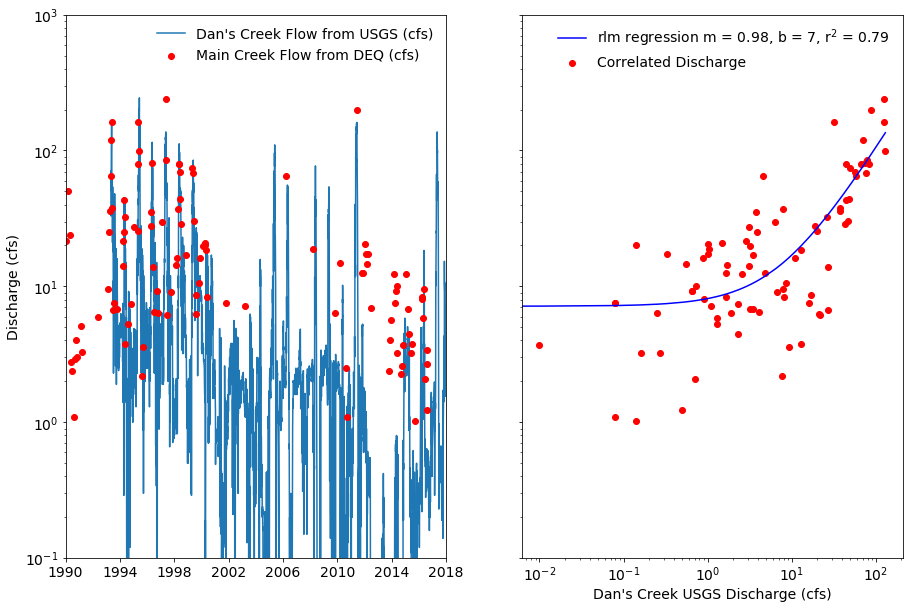

In [140]:
nw = wa.nwis('dv',10157500,'sites',startDT='1991-01-01')
prov = nw.data
prov.reset_index(inplace=True)
for colum in ['qualifiers','site_no']:
    if colum in prov.columns:
        prov.drop(colum,axis=1,inplace=True)
prov.set_index('datetime',inplace=True)
prov['value'] = prov['value']
#plt.plot(prov.index,prov.value)
#plt.scatter(DEQ_long_flow.index,DEQ_long_flow['Flow_cfs'], color='red',
#            zorder=1, label = 'Main Creek Flow from DEQ (cfs)')
#plt.yscale('log')

DEQ_long_flow = pd.read_excel(fileplace+'flow_check_wqp.xlsx','Sheet1')

DEQ_long_flow.set_index('datetime',inplace=True)
DEQ_long_flow.drop_duplicates(inplace=True)
DEQ_long_flow = DEQ_long_flow[DEQ_long_flow['Flow_cfs']>=1.0]
matchQ = DEQ_long_flow.resample('D').first().dropna()
matchQ = matchQ[matchQ.index > pd.datetime(1993,4,1)]


provflow = []

for i in matchQ.index:
    provflow.append(wa.fcl(prov,i))

pflow = pd.DataFrame(provflow)
pflow.index = pd.to_datetime(pflow.index)


matchQ.loc[:,'provQ'] = pflow['value'].values
matchQ.sort_values('provQ',inplace=True)    
matchQ.to_clipboard()
#matchflow = matchQ[matchQ['dansQ']>5.0]
x = matchQ.index
x0 = matchQ['provQ']
y = matchQ['Flow_cfs']


rcParams['figure.figsize'] = 15, 10
f, (ax1, ax2)  = plt.subplots(1, 2, sharey='row')

ax1.plot(prov.index,prov['value'],zorder=0, label='Dan\'s Creek Flow from USGS (cfs)')
ax1.scatter(DEQ_long_flow.index,DEQ_long_flow['Flow_cfs'], color='red',
            zorder=1, label = 'Main Creek Flow from DEQ (cfs)')

ax1.set_xlim('1/1/1990','1/1/2018')

ax2.scatter(x0, y, color='red', label='Correlated Discharge')

xa = sm.add_constant(x0)
est = sm.RLM(y, xa).fit()
r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
slope = est.params[1]
x_prime = np.linspace(np.min(x0), np.max(x0), 100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

const = est.params[0]
x1 = np.arange(np.min(x0), np.max(x0), 0.1)
y2 = [i * slope + const for i in x0]

ax2.plot(x0, y2, c='b', label='rlm regression m = {:.2f}, b = {:.0f}, r$^2$ = {:.2f}'.format(slope, const, r2))
ax1.legend(scatterpoints=1,frameon=False)
ax1.set_yscale('log')
ax2.set_xscale('log')
#ax2.set_xlim(0,160)
ax2.set_xlabel('Dan\'s Creek USGS Discharge (cfs)')
plt.ylim(0.1,1000)
ax1.set_ylabel('Discharge (cfs)')
ax2.legend(scatterpoints=1, frameon=False)
d2m_slope = slope
d2m_const = const
plt.savefig(figplace+'danscreekcorr.pdf')

dans_slope = slope
dans_const = const

Match Daniel's Creek to UGS Transducer Data

14649.8040102
7036.03567305


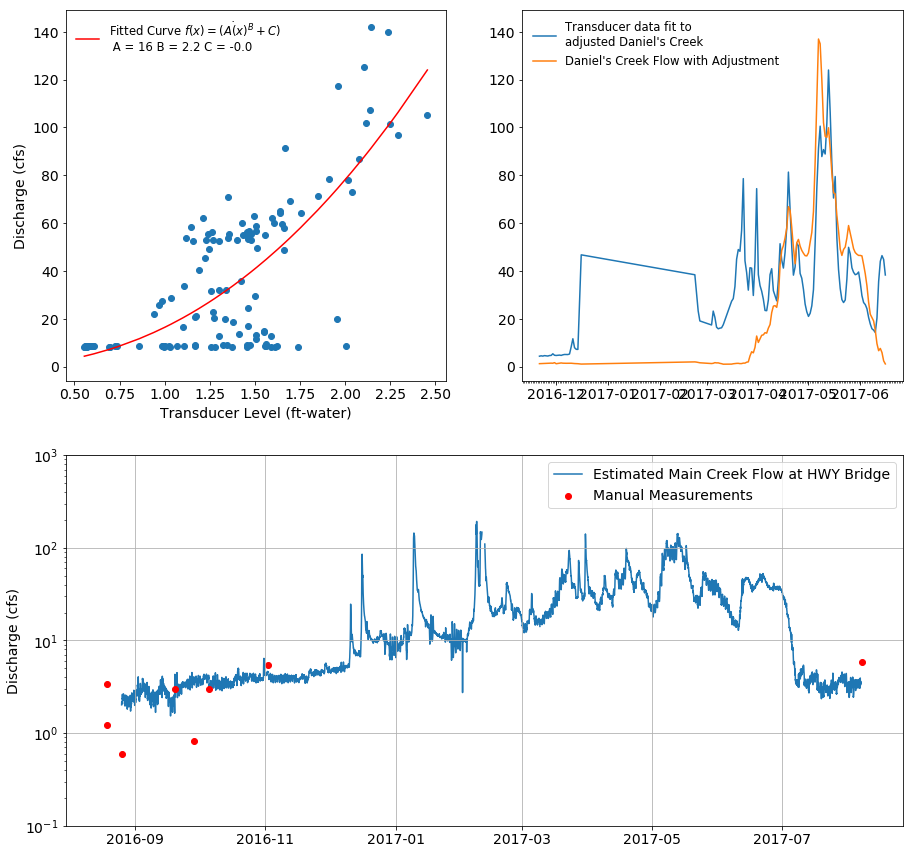

In [141]:
danshrly = prov.resample('1D').mean()
ddday = dd.resample('D').mean().interpolate()
dansmatch = danshrly[(danshrly.index>=pd.datetime(2016,8,25))&(danshrly.index<=pd.datetime(2017,8,7))]
lmQ = ddday.dropna(subset=['adjLowerMain'])['adjLowerMain'].to_frame().resample('D',limit=50).mean().interpolate()
lmQ['dans'] = dansmatch['value'].values
lmQ.dropna(inplace=True)
lmQ = lmQ[lmQ['dans']>=1.0]
lmQ = lmQ.sort_values('adjLowerMain')

y = lmQ.dans
x = lmQ.adjLowerMain
w = lmQ.index.to_julian_date()

lmQ['Daniel\'s Creek Flow with Adjustment'] = lmQ['dans'] # rename for plot
yn = lmQ['Daniel\'s Creek Flow with Adjustment']*d2m_slope + d2m_const
x = lmQ['adjLowerMain']


def func(x, a, b, c):
    return a*(x)**(b) + c



bounds = ([0.01,0.001, -8.0],[30.0,15.0,0.0])

popt, pcov = curve_fit(func, x, yn,bounds=bounds,max_nfev = 800000) #, method='trf')

sterr = np.sqrt(np.diag(pcov))


lal = 'Transducer data fit to\nadjusted Daniel\'s Creek'

equation = 'Fitted Curve ' + r'$f(x)= (A \dot (x)^{B} + C)$ '
eqlab = ' A = {:0.0f} B = {:0.1f} C = {:0.1f}'
lmQ[lal] = lmQ['adjLowerMain'].apply(lambda x: func(x,*popt),1)


#f, (ax1, ax2, ax3)  = plt.subplots(2, 2, sharey='row')

gs = gridspec.GridSpec(2, 2)
rcParams['figure.figsize'] = 15, 15
plt.figure()
ax1 = plt.subplot(gs[0, 0])

ax1.scatter(x,yn,label=None)
ax1.plot(x, [func(i,*popt) for i in x],color='red',label=equation+'\n'+eqlab.format(*popt))
ax1.set_xlabel('Transducer Level (ft-water)')
ax1.legend(loc=2,fontsize='small',scatterpoints=1,frameon=False)
ax1.set_ylabel('Discharge (cfs)')

lmQ = lmQ.sort_index()
ax2 = plt.subplot(gs[0, 1], sharey=ax1)
ax2.plot(lmQ.index, lmQ[lal], label=lal)
ax2.plot(lmQ.index, lmQ['Daniel\'s Creek Flow with Adjustment'],label='Daniel\'s Creek Flow with Adjustment')
#lmQ[[lal,'Daniel\'s Creek Flow with Adjustment']].plot()
#plt.yscale('log')

#ax1.set_xticklabels(rotation=45)
months = mdates.MonthLocator() 
days = mdates.DayLocator()
monthsFmt = mdates.DateFormatter('%Y-%m')
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(monthsFmt)
ax2.xaxis.set_minor_locator(days)

ax2.legend(fontsize='small',frameon=False)


dd['LowerMain_cfs'] = dd['adjLowerMain'].apply(lambda x: func(x,*popt),1)
dd.loc['2017-02-10 12:00:00':'2017-02-11 18:00:00','LowerMain_cfs'] = None

flow = pd.read_csv(fileplace+'ManualMeasurements.csv',index_col=0,parse_dates=True)
mc_flow = flow[flow.Fork == 'LowerMain']

x = dd.index
y = dd['LowerMain_cfs']

x1 = mc_flow.index
y1 = mc_flow.CFS
#plt.figure()
ax3 = plt.subplot(gs[1, :])
ax3.plot(x,y,label='Estimated Main Creek Flow at HWY Bridge',zorder=0)

ax3.scatter(x1,y1,label='Manual Measurements',color='red',zorder=1)

ax3.grid()
ax3.set_yscale('log')
ax3.set_ylim(0.1,1000)
#ax3.set_yticks(range(0,210,10))
ax3.set_ylabel('Discharge (cfs)')
ax3.legend(scatterpoints=1)
plt.savefig(figplace+'MainCreekModel.pdf')

lmcfs = dd.dropna(subset=['LowerMain_cfs'])['LowerMain_cfs'].resample('1D').mean().to_frame()
mcflow = lmcfs.values
mcindex = lmcfs.index

lmcfs.loc[:,'Eckbaseflow_UGS'] = wa.Eckhardt(mcflow, alpha=0.997, BFI=0.80)

lmcfs.loc[:,'Eckbaseflow_UGS_cfd'] = lmcfs['Eckbaseflow_UGS'] * 86400
lmcfs.loc[:,'LowerMain_cfd'] = lmcfs['LowerMain_cfs'] * 86400 
lmcfs.loc[:,'LowerMain_cms'] = lmcfs['LowerMain_cfs'].apply(lambda x: round(x * 0.0283168,3),1)
lmcfs.loc[:,'Eckbaseflow_UGS_cms'] = lmcfs['Eckbaseflow_UGS'] * 0.0283168
lmcfs.loc[:,'LowerMainSurface_cms'] = lmcfs['LowerMain_cms'] - lmcfs.loc[:,'Eckbaseflow_UGS_cms']

lmcfs.to_pickle(fileplace + 'FLOW_W_BASEFLOW.pickle')


print(lmcfs['LowerMain_cfd'].cumsum()[-1]*2.29569e-5)

print(lmcfs['Eckbaseflow_UGS_cfd'].cumsum()[-1]*2.29569e-5)



In [142]:
lmcfs = dd.dropna(subset=['LowerMain_cfs'])['LowerMain_cfs'].resample('1D').mean().to_frame()
mcflow = lmcfs.values
mcindex = lmcfs.index

lmcfs.loc[:,'Eckbaseflow_UGS'] = wa.Eckhardt(mcflow, alpha=0.997, BFI=0.80)

lmcfs.loc[:,'Eckbaseflow_UGS_cfd'] = lmcfs['Eckbaseflow_UGS'] * 86400
lmcfs.loc[:,'LowerMain_cfd'] = lmcfs['LowerMain_cfs'] * 86400 
lmcfs.loc[:,'LowerMain_cms'] = lmcfs['LowerMain_cfs'].apply(lambda x: round(x * 0.0283168,3),1)
lmcfs.loc[:,'Eckbaseflow_UGS_cms'] = lmcfs['Eckbaseflow_UGS'] * 0.0283168
lmcfs.loc[:,'LowerMainSurface_cms'] = lmcfs['LowerMain_cms'] - lmcfs.loc[:,'Eckbaseflow_UGS_cms']

print(lmcfs['LowerMain_cfd'].cumsum()[-1]*2.29569e-5)

print(lmcfs['Eckbaseflow_UGS_cfd'].cumsum()[-1]*2.29569e-5)



lmcfs.to_csv(fileplace + 'FLOW_W_BASEFLOW.csv')

14649.8040102
7036.03567305


connection successful
365


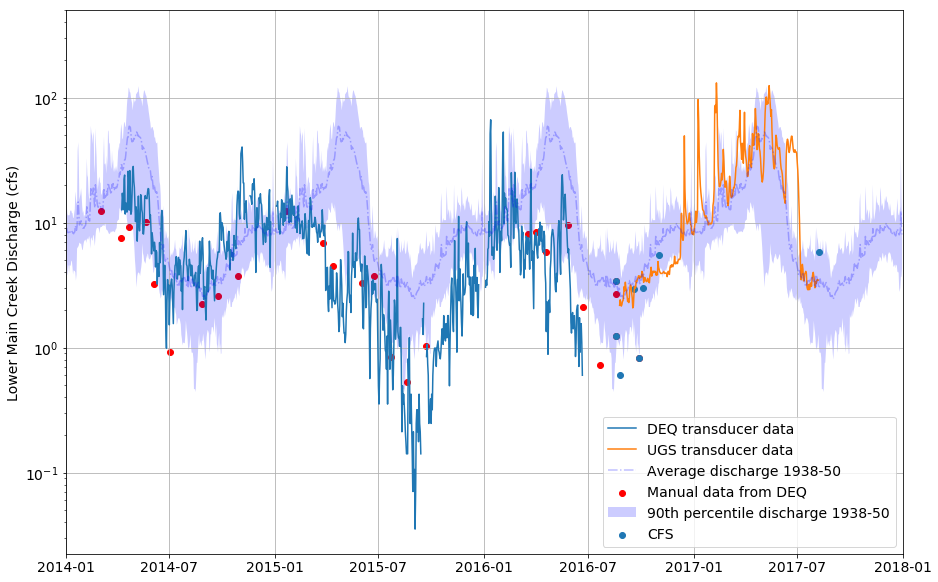

In [172]:
DEQmeandly["LowerMain_cfs"] = DEQmeandly["LowerMain_cms"]*35.3147

plt.plot(DEQmeandly.index,DEQmeandly.LowerMain_cfs,label='DEQ transducer data')
plt.plot(mcindex,lmcfs.loc[:,'LowerMain_cfs'], label='UGS transducer data')

#plt.plot(DEQmeandly.groupby(pd.Grouper(freq='M')).mean().index,DEQmeandly.groupby(pd.Grouper(freq='M'))['LowerMain_cfs'].mean(),label='DEQ transducer data')

lmcfs.loc[:,'Eckbaseflow_UGS_cfs'] = lmcfs.loc[:,'Eckbaseflow_UGS_cfd']*1.15741e-5

#plt.plot(mcindex,lmcfs.loc[:,'Eckbaseflow_UGS_cfs'] ,label='Eckhardt')
lmcfs.loc[:,'LowerMain_cmd'] = lmcfs.loc[:,'LowerMain_cms']*86400.0
lmcfs.loc[:,'LowerMain_cmd'].sum()*0.000810714

DEQ_long_flow['Flow_cms'] = DEQ_long_flow['Flow_cfs']*0.0283168
plt.scatter(DEQ_long_flow.index,DEQ_long_flow['Flow_cfs'], color='red',
            zorder=1, label = 'Manual data from DEQ')

nw = wa.nwis('dv',[10158500],'sites')
MainUSGS = nw.data
MainUSGS.loc[:,'month'] = MainUSGS.index.month
MainUSGS.loc[:,'doy'] = MainUSGS.index.dayofyear
grpd = MainUSGS.groupby(['doy'])['value']
xm = grpd.median().index
ym = grpd.median()
ya = grpd.mean()
y1 = grpd.quantile(q=0.05).values
y2 = grpd.quantile(q=0.95).values
dates2014 = pd.date_range('1/1/2014','12/31/2014',freq='D')
dates2015 = pd.date_range('1/1/2015','12/31/2015',freq='D')
dates2016 = pd.date_range('1/1/2016','12/31/2016',freq='D')
dates2017 = pd.date_range('1/1/2017','12/31/2017',freq='D')
print(len(dates2015))
plt.fill_between(dates2014, y1[0:-1],y2[0:-1],alpha=0.2, facecolor='blue', label='90th percentile discharge 1938-50')
plt.fill_between(dates2015, y1[0:-1],y2[0:-1],alpha=0.2, facecolor='blue')
plt.fill_between(dates2016, y1,y2,alpha=0.2, facecolor='blue')
plt.fill_between(dates2017, y1[0:-1],y2[0:-1], alpha=0.2,  facecolor='blue')

plt.scatter(mc_flow.index, mc_flow.CFS)

plt.plot(dates2014, ya[0:-1], '-.',color='blue', alpha=0.25, label='Average discharge 1938-50')
plt.plot(dates2015, ya[0:-1], '-.', color='blue', alpha=0.25,label='')
plt.plot(dates2016, ya, '-.', color='blue', alpha=0.25,label='')
plt.plot(dates2017, ya[0:-1], '-.', color='blue', alpha=0.25,label='')
plt.ylabel('Lower Main Creek Discharge (cfs)')
plt.xlim('1/1/2014','1/1/2018')
#plt.ylim(0,200)
#plt.yticks(np.arange(0,5.5,.5))
plt.grid()
plt.yscale('log')
plt.legend(loc=4)

In [173]:
lmcfs['sequence'] = range(1,len(lmcfs)+1)
lmcfs['rowlab'] = lmcfs.index.map('FLOW_OUT_{0:%Y}_{0:%j}'.format)
lmcfs[['sequence','rowlab','LowerMain_cms']].to_clipboard(index=False)

In [174]:
pd.datetime(2012,1,1) - pd.datetime(2017,1,1)

datetime.timedelta(-1827)

In [218]:
lmcfs.groupby(pd.Grouper(freq='M')).sum().to_clipboard()

### Compiled Measurements

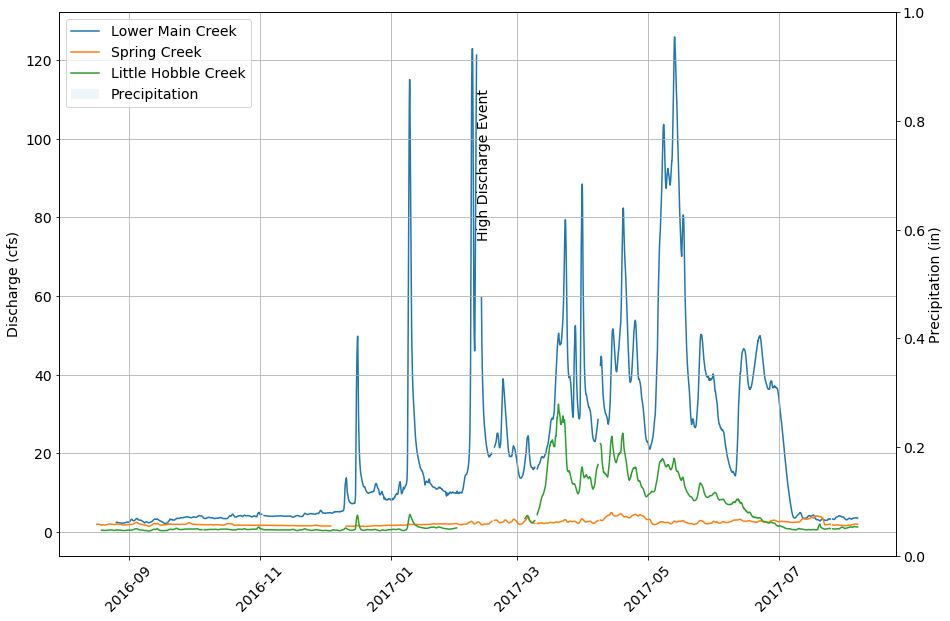

In [175]:

x0 = dd.index
#y1 = dd.UpperMain_cfs
y2 = dd.LowerMain_cfs.rolling(24, center=True).mean()
y3 = dd.SpringCreek_cfs.rolling(24, center=True).mean()
y4 = dd.LittleHobble_cfs.rolling(24, center=True).mean()
#y5 = dd.precip_in.rolling(24, center=True).mean()*0.00001

ys = [y2,y3,y4]
ylabs = ['Lower Main Creek', 'Spring Creek','Little Hobble Creek']

fig, ax1 = plt.subplots()

n = 0
for y in ys:
    ax1.plot(x0,y,label=ylabs[n], zorder=n+1)
    n += 1
plt.xticks(rotation=45)
ax1.text('2/10/2017',110,'High Discharge Event',rotation=90)
ax2 = ax1.twinx()
ax1.bar(np.nan,np.nan, width=0.2, alpha=0.2,linewidth=0, zorder=0, color='lightblue',label='Precipitation')
#ax2.bar(x0,y5, width=0.2, alpha=0.2,linewidth=0, zorder=0, color='lightblue')
ax1.set_zorder(ax2.get_zorder()+1) # put ax in front of ax2 
ax1.patch.set_visible(False) # hide the 'canvas' 

ax1.set_ylabel('Discharge (cfs)')
ax2.set_ylabel('Precipitation (in)')
ax1.legend(loc=2)
ax1.grid()

#ax1.xaxis.set_major_locator(dates.MonthLocator(interval=1))

# set formatter
#ax1.xaxis.set_major_formatter(dates.DateFormatter('%m-%Y'))
#ax1.xaxis.set_tick_params(rotation=45)
plt.savefig(figplace+'all_flows.pdf')

In [176]:
dd.to_pickle(fileplace+'ugs_data_out.pickle')
dd.to_csv(fileplace+'ugs_data_out.csv')

UGS Total Cumulative Flow: 14649.804010193173 acft/yr
USGS Total Cumulative Flow: 9626.015665263272 acft/yr
6086.3249664
7904.50100213162


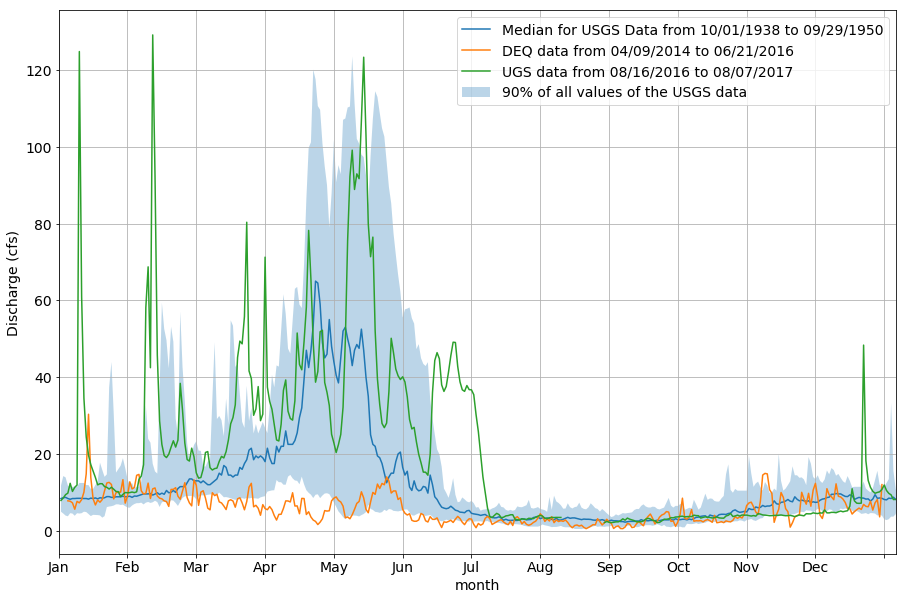

In [177]:

grpd = MainUSGS.groupby(['doy'])['value']
xm = grpd.median().index
ym = grpd.median()
x1 = grpd.quantile(q=0.05).index
y1 = grpd.quantile(q=0.05)
x2 = grpd.quantile(q=0.95).index
y2 = grpd.quantile(q=0.95)

DEQflClip['doy'] = DEQflClip.index.dayofyear
grpd2 = DEQflClip.groupby(['doy'])['flow']
xm2 = grpd2.median().index
ym2 = grpd2.median()

dd['doy'] = dd.index.dayofyear
grpd3 = dd.groupby(['doy'])['LowerMain_cfs']
x3 = grpd3.median().index
y3 = grpd3.median()
rcParams['figure.figsize'] = 15, 10

plt.plot(xm,ym, label='Median for USGS Data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(MainUSGS.index.min(),MainUSGS.index.max()))
plt.fill_between(x1,y1,y2,label='90% of all values of the USGS data',alpha=0.3,linewidth=0 )
plt.plot(xm2,ym2, label='DEQ data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(DEQflClip.index.min(),DEQflClip.index.max())) 
plt.plot(x3,y3, label = 'UGS data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(dd.index.min(),dd.index.max())) 

#plt.title("Monthly Summary of Discharge Data at Mouth of Main Creek")
ugs_cfd = grpd3.mean()*86400.0
ugs_acft = ugs_cfd.cumsum().iloc[-1]*2.29569e-5
usgs_cfd = grpd.mean()*86400.0
usgs_acft = usgs_cfd.cumsum().iloc[-1]*2.29569e-5

print('UGS Total Cumulative Flow: {:} acft/yr'.format(ugs_acft))
print('USGS Total Cumulative Flow: {:} acft/yr'.format(usgs_acft))
print(ym.median()*365.25*24*60*60*2.296E-5)
print(y3.median()*365.25*24*60*60*2.296E-5)
plt.legend()
plt.grid()

plt.xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)

plt.ylabel('Discharge (cfs)')
plt.savefig(figplace + 'MainCreekMonthlyHydroGraphAllData.svg')
plt.savefig(figplace + 'MainCreekMonthlyHydroGraphAllData.pdf')

In [178]:
ugs_cfd.cumsum().iloc[-1]

638143826.48324347

USGS Flow Out: 8420 ac-ft/yr
DEQ Flow Out: 4036 ac-ft/yr
UGS Flow Out: 14343 ac-ft/yr


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning:

pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)



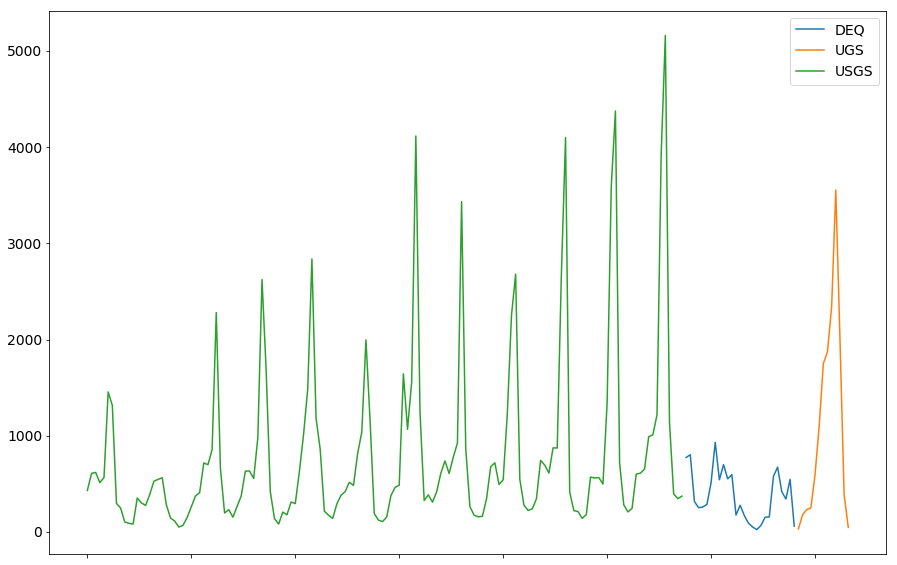

In [179]:
grpd = MainUSGS.groupby(['doy'])['value']

def get_stats(df,flow):
    grpd = df.groupby(['doy'])[flow] #cfs
    medQ = grpd.median()*86400.00 #cfd

    dailyQ = df.groupby(pd.TimeGrouper('D')).median()*86400.00 #cfd
    monQ = dailyQ.groupby([dailyQ.index.year,dailyQ.index.month])[flow].sum()*2.29569e-5 #ac-ft/mo
    yearQ = dailyQ.groupby(dailyQ.index.year)[flow].sum()*2.29569e-5 #ac-ft/year
    cumul = medQ.cumsum().values[-1] #cfyr
    return medQ, cumul, monQ, yearQ

datasets = [[MainUSGS,'value','USGS'],[DEQflClip,'flow','DEQ'],[dd,'LowerMain_cfs','UGS']]
medQ, sumQ, monQ, yrQ = {},{},{},{}
for i in datasets:
    medQ[i[2]],sumQ[i[2]],monQ[i[2]],yrQ[i[2]] = get_stats(i[0], i[1])
    print('{:} Flow Out: {:0.0f} ac-ft/yr'.format(i[2], sumQ[i[2]]*2.29569e-5))
yearlyQ = pd.DataFrame(yrQ)
monthlyQ = pd.DataFrame(monQ)
doymedQ = pd.DataFrame(medQ)
monthlyQ.plot()

In [180]:
lmugs = dd.dropna(subset=['LowerMain_cfs'])['LowerMain_cfs'].to_frame()


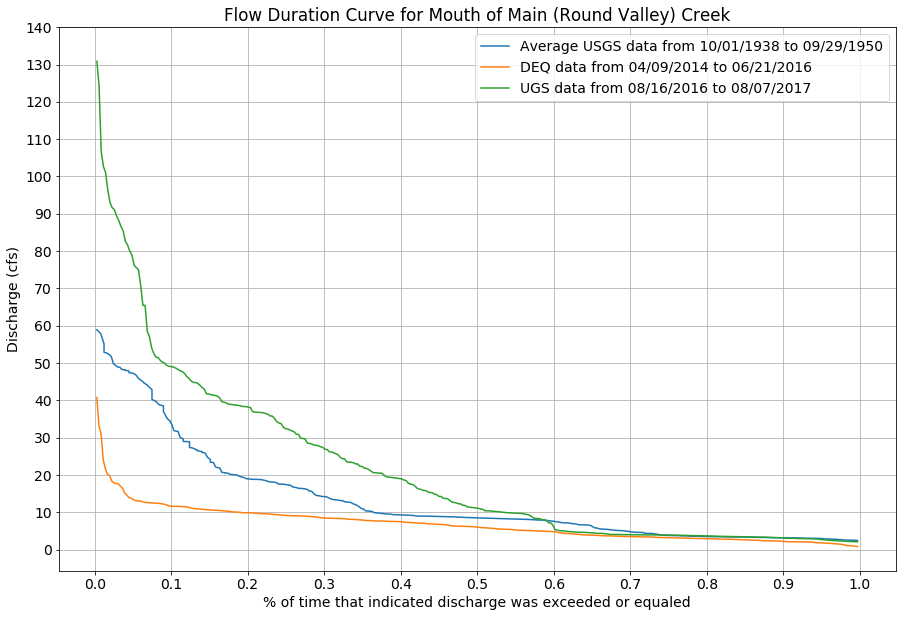

In [181]:
p1, d1, stdp1, stdm1, med1 = fdc_simple(MainUSGS,'value',plot=False)
p2, d2, stdp2, stdm2, med2 = fdc_simple(DEQflClip,'flow',plot=False)
p3, d3, stdp3, stdm3, med3 = fdc_simple(lmugs,'LowerMain_cfs',plot=False)

rcParams['figure.figsize'] = 15, 10
plt.title('Flow Duration Curve for Mouth of Main (Round Valley) Creek')
plt.plot(p1,d1,label='Average USGS data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(MainUSGS.index.min(),MainUSGS.index.max()))
plt.plot(p2,d2,label='DEQ data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(DEQflClip.index.min(),DEQflClip.index.max()))
plt.plot(p3,d3,label='UGS data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(dd.index.min(),dd.index.max()))
#plt.fill_between(p1,stdm1,stdp1,alpha=.3)
plt.grid()
plt.legend()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.xticks(np.arange(0,1.1,0.1))

plt.yticks(range(0,150,10))
plt.savefig(figplace + 'fdc_all_MainCreek.svg')
plt.savefig(figplace + 'fdc_all_MainCreek.pdf')

connection successful
Gage height, feet skipped!
Gage height, feet skipped!
Gage height, feet skipped!


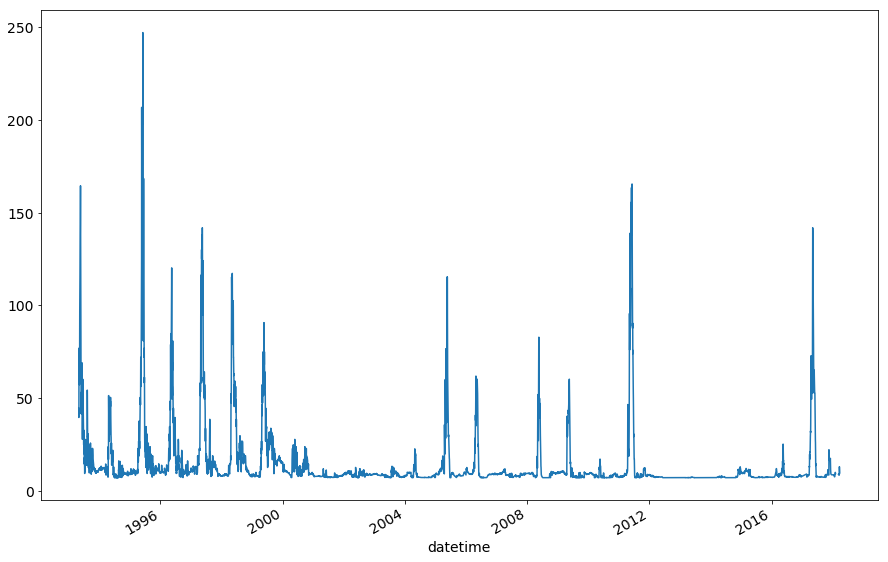

In [182]:
dans_creek = wa.nwis('dv','10157500','sites')
dans_creek.data.index = dans_creek.data.index.droplevel(0)
dans_creek.data['correct'] = dans_creek.data.value.apply(lambda x: x*dans_slope + dans_const, 1)
dans_creek.data['correct'].plot()

In [209]:
ddd = dd.resample('1D').mean()


for col in dd.columns:
    if "_cfs" in col:
        ddd[col[:-3]+'cfd'] = ddd[col]*86400
        
cfdlist=[]
for col in ddd.columns:
    if '_cfd' in col:
        cfdlist.append(col)
        
cfds = ddd[cfdlist]
cfmo = cfds.groupby(pd.Grouper(freq='M')).sum()
for col in cfmo:
    cfmo[col[:-3]+'acft'] = 2.29569e-5*cfmo[col]
cfmo = cfmo.round(0)
afmo = cfmo.drop(cfdlist,axis=1)

In [214]:
afmo.to_clipboard()

In [212]:
afmo.sum()

LittleHobble_acft     3070.0
SpringCreek_acft      1529.0
LowerMain_acft       14651.0
dtype: float64

### Manual Data

In [13]:
af = 2130.56
cms = [.5751,5.26,25.59,63.18,30.06,11.9,4.679,1.173,7.067,5.525,4.41,8.114]
af_mo = [af*i for i in cms]
np.sum(af_mo)

356939.32153599994

In [ ]:
xlfile = r"H:\Google Drive\WORK\Round_Valley\Data\Hydrology_Data\Flow_Meas_Sites.xlsx"
SeepRun = xl2PntFt(xlfile, "X","Y",shpplace, 'SeepRun', 'MapData.gdb',4326)

<img src=http://i.ajdesigner.com/h/pipe_less.png>


<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/6daaf8ee00378e432eb6529c803344b3af6f43e6'>

In [ ]:
h = 0.4
R = 1.5
angle = 2*np.arccos(1-(h/R))
angle

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/390a83ea04c50c37e2bb2a9a75e2c674d517202d">

In [ ]:
c = 2*R*np.sin(angle/2)
c

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/c9ce62a002997277a68db1b9b75d26550025a4cf'>

In [ ]:
area = (R*R)/2*(angle-np.sin(angle))
area #ft sq
flow = 3.29 #ft/s
discharge = area*flow
print("the discharge is %f cfs" % discharge)

## Allred Data

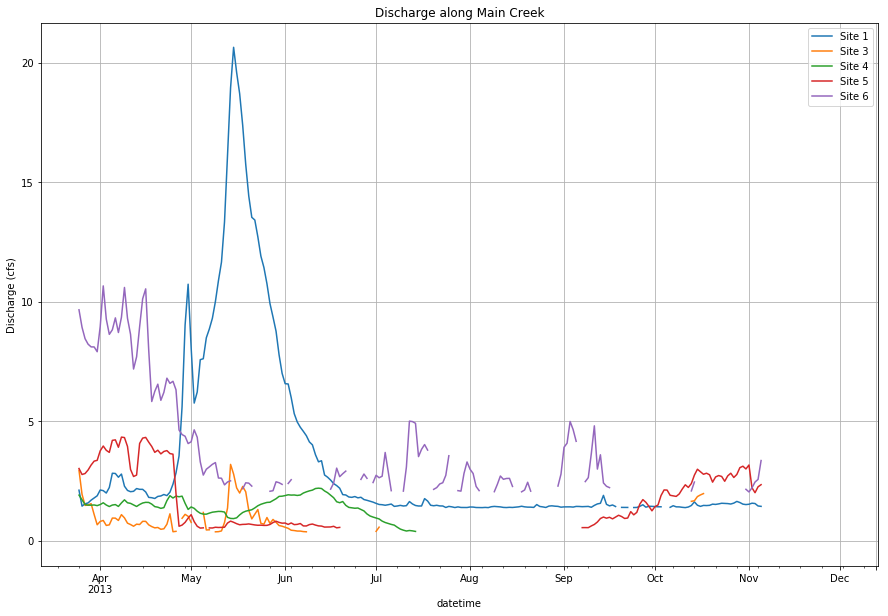

In [11]:
sitelist = [1,3,4,5,6]
sited = {}

for site in sitelist:
    df = pd.read_excel(drive+"Round_Valley/Data/Budget.xlsx","site{:}".format(site),index_col="datetime")
    sited[site] = df.resample('1D').mean()#.interpolate(method='time',limit=10)


sites = pd.concat(sited,axis=1)
sites.columns = sites.columns.droplevel(0)


newcols = []
for col in sites.columns:
    col1 = str(col).replace("site","Site ")[:-3]
    newcols.append(col1)

sites.columns = newcols


sites['Reach A'] = sites['Site 3'].interpolate(method='time') - sites['Site 1'].interpolate(method='time')
sites['Reach B'] = sites['Site 4'].interpolate(method='time') - sites['Site 3'].interpolate(method='time')
sites['Reach C'] = sites['Site 6'].interpolate(method='time') - (sites['Site 4'].interpolate(method='time') + sites['Site 5'].interpolate(method='time'))



sites[['Site {:}'.format(i) for i in sitelist]].plot()
plt.grid()
plt.ylabel('Discharge (cfs)')
plt.title('Discharge along Main Creek')

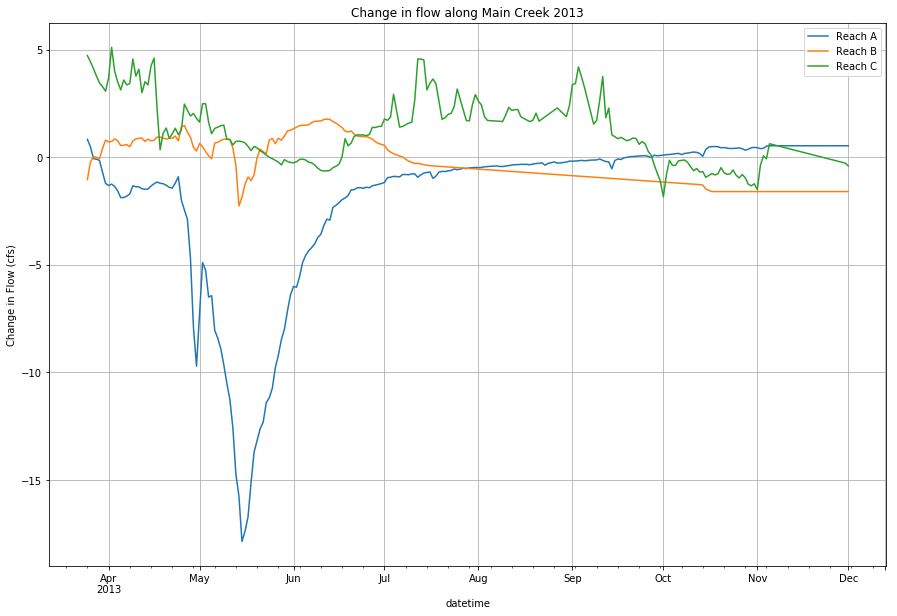

In [12]:
sites[['Reach A','Reach B','Reach C']].plot()
plt.grid()
plt.ylabel('Change in Flow (cfs)')
plt.title('Change in flow along Main Creek 2013')

In [13]:
for col in sites.columns:
    sites[col+" ac-ft"] = sites[col]*86400
    sites.drop(col,inplace=True,axis=1)
monthly_acft = sites.groupby(pd.Grouper(freq='M')).sum()*2.29569e-5

In [25]:
month_short = monthly_acft.drop([monthly_acft.index[9],monthly_acft.index[0]],axis=0)

In [26]:
month_short.loc['average',:] = month_short.mean()
month_short.loc['average_all',:] = 

In [27]:
month_short

Site 1 ac-ft  Site 3 ac-ft  Site 4 ac-ft  Site 5 ac-ft  \
datetime                                                                      
2013-04-30 00:00:00    169.952149     43.215423     93.405671    198.735566   
2013-05-31 00:00:00    725.935188     62.130129     80.926986     40.439261   
2013-06-30 00:00:00    190.495969      7.856113    102.424880     24.204404   
2013-07-31 00:00:00     91.238220      3.458543     17.919551      0.011593   
2013-08-31 00:00:00     87.117028      0.000000      0.000000      0.045070   
2013-09-30 00:00:00     81.015239      0.000000      0.000000     49.682813   
2013-10-31 00:00:00     85.950391     17.980948      0.000000    150.696703   
2013-11-30 00:00:00     14.985401      0.000000      0.000000     23.791292   
sum                   5882.505363    627.329990   1266.706622   2120.509525   
average                799.766147     83.325864    170.532764    284.908322   

                     Site 6 ac-ft  Reach A ac-ft  Reach B ac-ft  Reach C ac-ft  
datetime                                                                        
2013-04-30 00:00:00    455.001228    -125.412813      48.866336     162.859992  
2013-05-31 00:00:00    128.925538    -657.168982      12.160779      42.048650  
2013-06-30 00:00:00     66.613484    -165.444580      77.373490      15.859824  
2013-07-31 00:00:00    154.267085     -45.290623     -15.969419     153.452198  
2013-08-31 00:00:00     86.949330     -20.880360     -42.894836     121.267685  
2013-09-30 00:00:00    101.318629      -4.545822     -59.449533      88.547276  
2013-10-31 00:00:00     17.454681      19.001721     -87.206709     -43.668679  
2013-11-30 00:00:00     25.069922      31.087934     -94.865030       5.502316  
sum                   4613.517993   -3877.356121    -661.355450    2393.568972  
average                617.338130    -528.661829     -89.849440     321.143471

In [169]:
617*12

7404

# PRISM

http://www.prism.oregonstate.edu/documents/PRISM_downloads_web_service.pdf


http://www.esrl.noaa.gov/psd/data/gridded/tables/precipitation.html

# Snotel

http://wcc.sc.egov.usda.gov/nwcc/site?sitenum=435

## hourly

In [186]:
dt = datetime.datetime.today()
SNOTEL_hr_url = 'http://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/hourly/435:UT:SNTL%7Cid=%22%22%7Cname/'+\
'2010-08-01,' + str(dt.year) + '-' + str(dt.month) + '-' +str(dt.day)+\
'/WTEQ::value,SNWD::value,PREC::value,TOBS::value,PRCP::value,SMS:-2:value,SMS:-8:value,SMS:-20:value'
SNTL_hr = pd.read_csv(SNOTEL_hr_url,comment='#',index_col='Date',error_bad_lines=False, parse_dates=True)

In [187]:
x0 = dd.index
#y1 = dd.UpperMain_cfs
y2 = dd.LowerMain_cfs.rolling(24, center=True).mean()
y3 = dd.SpringCreek_cfs.rolling(24, center=True).mean()
y4 = dd.LittleHobble_cfs.rolling(24, center=True).mean()
y5 = dd.precip_in.rolling(24, center=True).mean()*0.00001

In [207]:
SNTL_hr_short = SNTL_hr[(SNTL_hr.index >= dd.index[0])&(SNTL_hr.index <= dd.index[-1])].resample('1H').mean().interpolate()

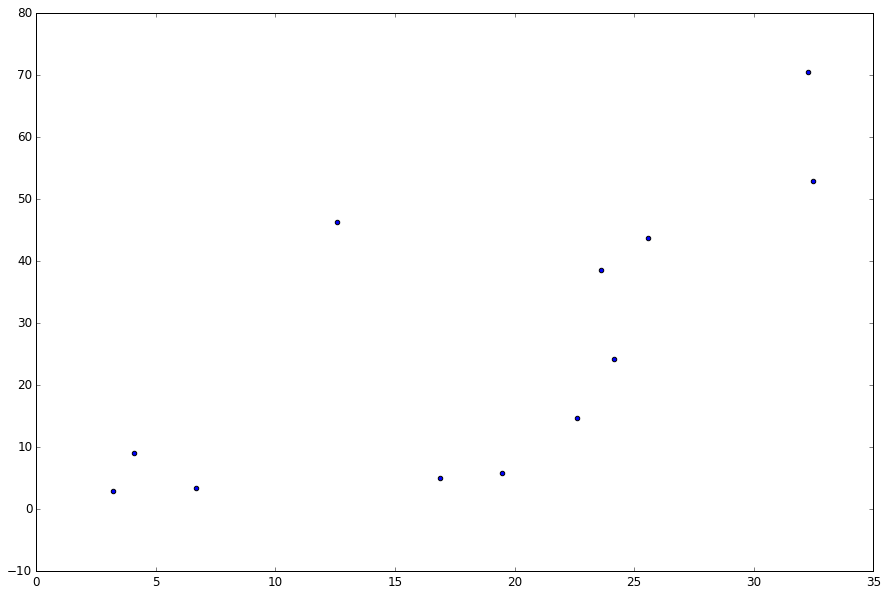

In [220]:
sn_var = 'Soil Moisture Percent -8in (pct)'
plt.scatter(SNTL_hr_short[sn_var].groupby(SNTL_hr_short.index.month).median(),y2.groupby(y2.index.month).median())

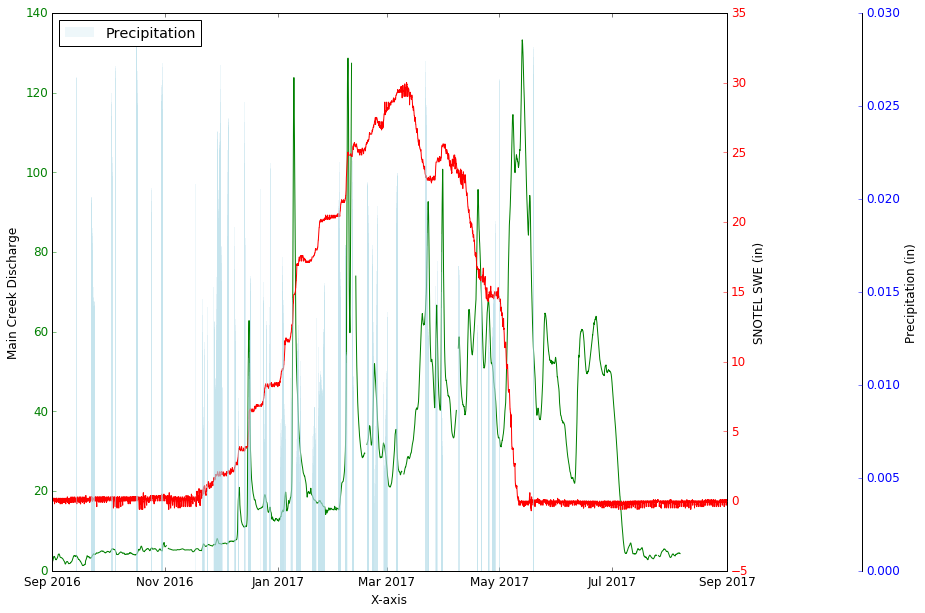

In [201]:

x1 = SNTL_hr.index 
y3 = SNTL_hr[u'Snow Water Equivalent (in)']
y5 = dd.precip_in.rolling(24, center=True).mean()*0.00001


xs = [x0, x1, x0]
ys = [y2, y3, y5]
labs = ['Main Creek Discharge (cfs)','SNOTEL SWE (in)','Precipitation (in)']

fig, ax = plt.subplots()

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx(), ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# Move the last y-axis spine over to the right by 20% of the width of the axes
axes[-1].spines['right'].set_position(('axes', 1.2))

# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

# And finally we get to plot things...
colors = ('Green', 'Red', 'Blue')
i= 0 
for ax, color,x,y,lab in zip(axes, colors, xs,ys,labs):
    i +=1
    if i == 3:
        ax.bar(np.nan,np.nan, width=0.2, alpha=0.2,linewidth=0, zorder=0, color='lightblue',label='Precipitation')
        ax.bar(x0,y5, width=0.2, alpha=0.2,linewidth=0, zorder=0, color='lightblue')
        ax.set_zorder(ax2.get_zorder()+1) # put ax in front of ax2 
        ax.patch.set_visible(False) # hide the 'canvas' 
    else:
        ax.plot(x, y, color=color)
    ax.set_ylabel('{:}'.format(lab))
    ax.tick_params(axis='y', colors=color)
axes[0].set_xlabel('X-axis')



axes[-1].legend(loc=2)

axes[0].set_xlim(pd.datetime(2016,9,1),pd.datetime(2017,9,1))

plt.show()

Index(['Snow Water Equivalent (in)', 'Snow Depth (in)',
       'Precipitation Accumulation (in)', 'Air Temperature Observed (degF)',
       'Precipitation Increment (in)', 'Soil Moisture Percent -2in (pct)',
       'Soil Moisture Percent -8in (pct)',
       'Soil Moisture Percent -20in (pct)'],
      dtype='object')

Index(['Snow Water Equivalent (in)', 'Snow Depth (in)',
       'Precipitation Accumulation (in)', 'Air Temperature Observed (degF)',
       'Precipitation Increment (in)', 'Soil Moisture Percent -2in (pct)',
       'Soil Moisture Percent -8in (pct)',
       'Soil Moisture Percent -20in (pct)'],
      dtype='object')


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Index(['Snow Water Equivalent (in)', 'Snow Depth (in)',
       'Precipitation Accumulation (in)', 'Air Temperature Observed (degF)',
       'Precipitation Increment (in)', 'Soil Moisture Percent -2in (pct)',
       'Soil Moisture Percent -8in (pct)',
       'Soil Moisture Percent -20in (pct)'],
      dtype='object')


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyd

0.000885230378695 3.00000000019 0.999999996633


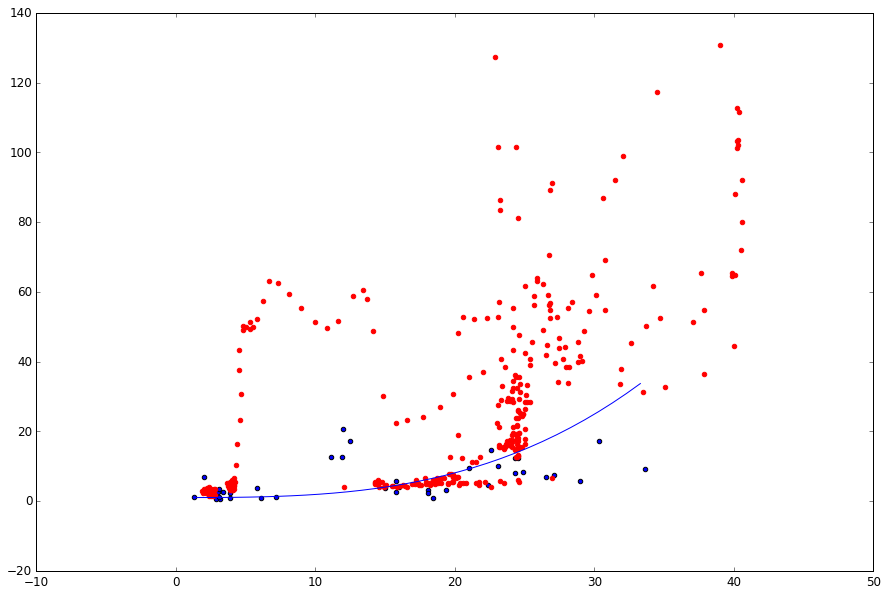

In [223]:
print(SNTL_hr.columns)
sn_var = 'Soil Moisture Percent -8in (pct)'

DEQ_long_flow = pd.read_excel(fileplace+'flow_check_wqp.xlsx','Sheet1')
DEQ_long_flow.set_index('datetime',inplace=True)
DEQ_long_flow.drop_duplicates(inplace=True)
matchflow = DEQ_long_flow[DEQ_long_flow.index >= SNTL_hr.index[0]]

sntl=[]

for ind in matchflow.index:
    sntl.append(wa.fcl(SNTL_hr[sn_var], ind))
    
matchflow['Snotel'] = sntl
matchflow.dropna(inplace=True)

y = matchflow['Flow_cfs']
x = matchflow['Snotel']

w = matchflow.index.to_julian_date()

df = matchflow[matchflow['Flow_cfs'] < 200]
plt.scatter(df.Snotel, df.Flow_cfs)


def func(x, a,b, c):
    return a*(x)**b + c

bounds = ([0.0,3.0, -60.0],[30.0,10.0,1.0])

popt, pcov = curve_fit(func, x, y, bounds=bounds, max_nfev = 800000) #, method='trf')

sterr = np.sqrt(np.diag(pcov))


lal = 'Measured data fit to Snotel'

equation = 'Fitted Curve ' + r'$f(x)= (A \dot (x)^{B} + C)$ '
eqlab = ' A = {:0.0f} B = {:0.1f} C = {:0.1f}'

df[lal] = df['Snotel'].apply(lambda x: func(x,*popt),1)
g = np.arange(df['Snotel'].min(),df['Snotel'].max())
plt.scatter(SNTL_hr_short[sn_var].groupby(SNTL_hr_short.index.dayofyear).median(),y2.groupby(y2.index.dayofyear).median(),color='red')
plt.plot(g, [func(i,*popt) for i in g] )
print(*popt)

## Daily

In [125]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

dt = datetime.datetime.today()
SNOTEL_dly_url = 'https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/daily'+\
'/435:UT:SNTL|id=%22%22|name/POR_BEGIN,POR_END/WTEQ::value,PREC::value,TMAX::value,TMIN::value,TAVG::value,PRCP::value,SMS::value'
#SNOTEL_dly_url = SNOTEL_dly_url_text.format(dt.year, dt.month, dt.day)
print(SNOTEL_dly_url)
SNTL_dy = pd.read_csv(SNOTEL_dly_url,index_col='Date',parse_dates=True,comment='#')

https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/daily/435:UT:SNTL|id=%22%22|name/POR_BEGIN,POR_END/WTEQ::value,PREC::value,TMAX::value,TMIN::value,TAVG::value,PRCP::value,SMS::value


Snow Water Equivalent (in) Start of Day Values  \
Water Year                                                   
1979                                          91186.588100   
1980                                          96418.605450   
1981                                          41482.423275   
1982                                          79601.406825   
1983                                         103519.200425   
1984                                          92681.450200   
1985                                          77732.829200   
1986                                         107630.071200   
1987                                          32513.250675   
1988                                          56804.759800   
1989                                          62410.492675   
1990                                          51572.742450   
1991                                          46340.725100   
1992                                          29523.526475   
1993                                          74369.389475   
1994                                          47461.871675   
1995                                          56431.044275   
1996                                          89318.010475   
1997                                         104640.347000   
1998                                          68763.656600   
1999                                          50825.311400   
2000                                          67642.510025   
2001                                          39240.130125   
2002                                          44472.147475   
2003                                          42977.285375   
2004                                          63157.923725   
2005                                          85580.855225   
2006                                          93802.596775   
2007                                          43724.716425   
2008                                          87449.432850   
2009                                          73248.242900   
2010                                          47835.587200   
2011                                         111740.941975   
2012                                          32513.250675   
2013                                          40361.276700   
2014                                          54936.182175   
2015                                          39613.845650   
2016                                          39987.561175   
2017                                         110246.079875   
2018                                          30644.673050   

            Precipitation Accumulation (in) Start of Day Values  \
Water Year                                                        
1979                                            118094.105900     
1980                                            154718.227350     
1981                                             82591.131025     
1982                                            164434.831000     
1983                                            154344.511825     
1984                                            144627.908175     
1985                                            128558.140600     
1986                                            149112.494475     
1987                                             79227.691300     
1988                                             79975.122350     
1989                                            105761.493575     
1990                                            100155.760700     
1991                                            108751.217775     
1992                                             78853.975775     
1993                                            136406.166625     
1994                                             95297.458875     
1995                                            148365.063425     
1996                                            122952.407725     
1997                                            168919.417300     


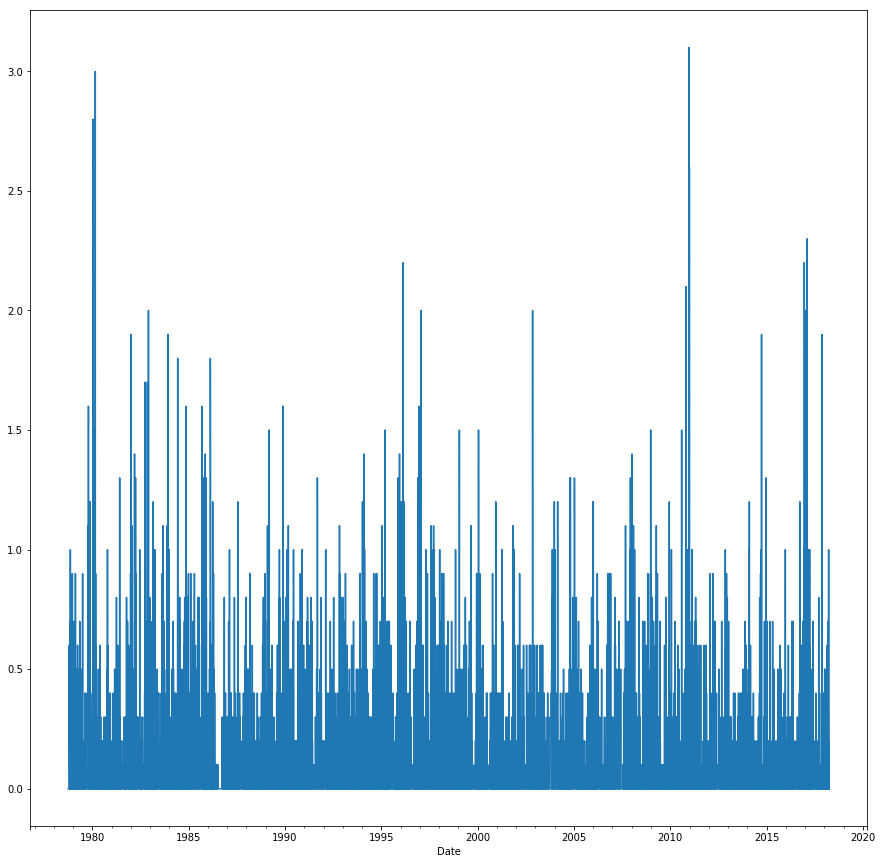

In [126]:
SNTL_dy['Precipitation Increment (in)'].plot()
SNTL_dy['Water Year'] = SNTL_dy.index.shift(-9,freq='M').year+1
SNTL_dy['SWEdiff'] = SNTL_dy['Snow Water Equivalent (in) Start of Day Values'].diff()
SNTL_dy.groupby('Water Year').max()/12*44845.863

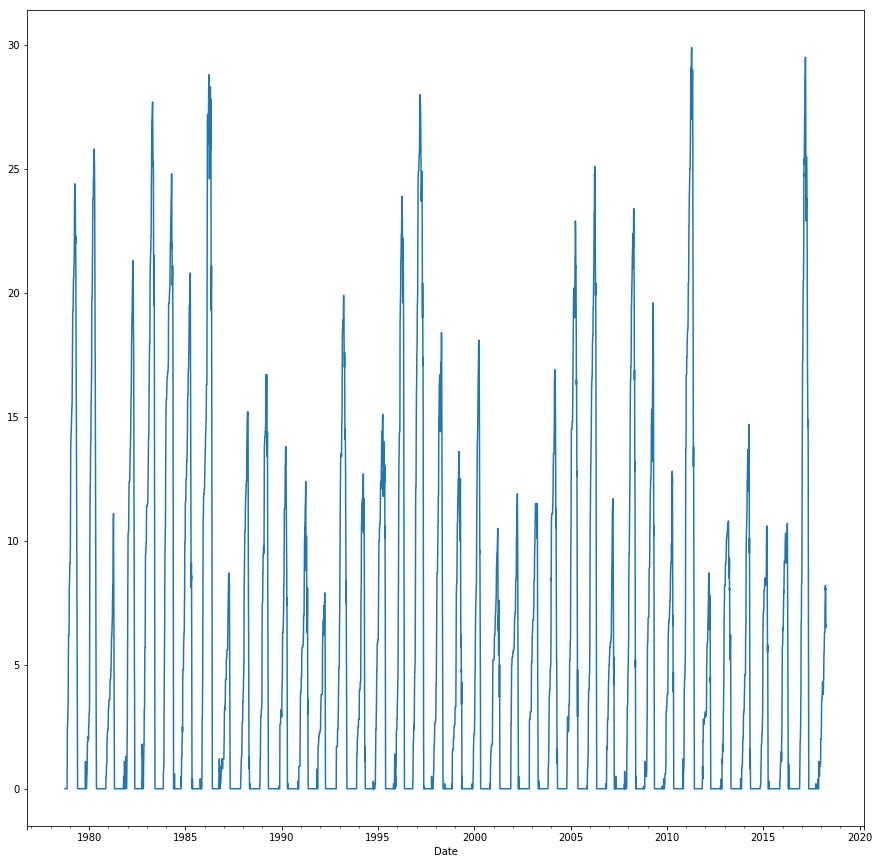

In [127]:
SNTL_dy['Snow Water Equivalent (in) Start of Day Values'].plot()
#plt.twinx()
#DEQ_long_flow['Flow_cfs'].plot(color='red')

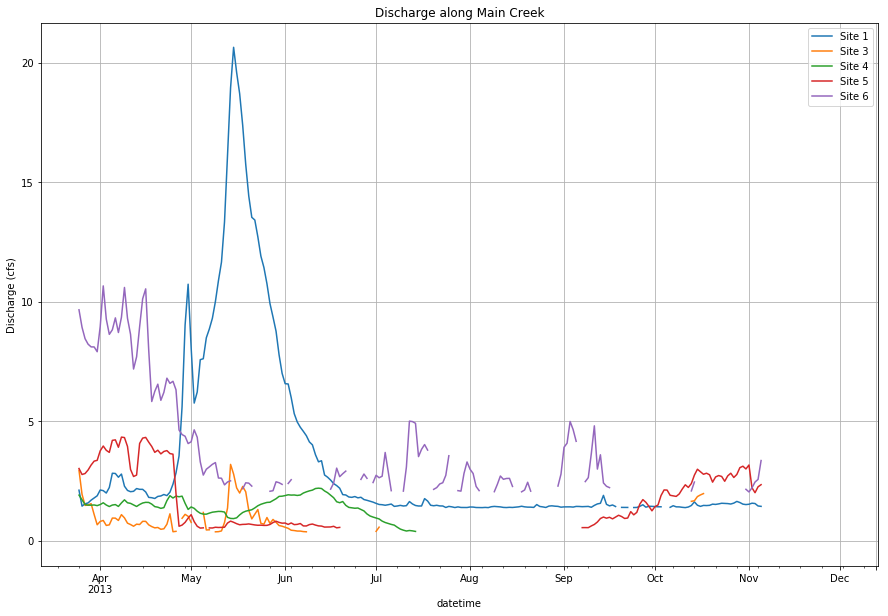

In [46]:
sitelist = [1,3,4,5,6]
sited = {}

for site in sitelist:
    df = pd.read_excel(drive+"Round_Valley/Data/Budget.xlsx","site{:}".format(site),index_col="datetime")
    sited[site] = df.resample('1D').mean()#.interpolate(method='time',limit=10)


sites = pd.concat(sited,axis=1)
sites.columns = sites.columns.droplevel(0)


newcols = []
for col in sites.columns:
    col1 = str(col).replace("site","Site ")[:-3]
    newcols.append(col1)

sites.columns = newcols


sites['Reach A'] = sites['Site 3'].interpolate(method='time') - sites['Site 1'].interpolate(method='time')
sites['Reach B'] = sites['Site 4'].interpolate(method='time') - sites['Site 3'].interpolate(method='time')
sites['Reach C'] = sites['Site 6'].interpolate(method='time') - (sites['Site 4'].interpolate(method='time') + sites['Site 5'].interpolate(method='time'))



sites[['Site {:}'.format(i) for i in sitelist]].plot()
plt.grid()
plt.ylabel('Discharge (cfs)')
plt.title('Discharge along Main Creek')

In [134]:
dd = pd.read_pickle(fileplace+'ugs_data_out.pickle').resample('1D').mean()

In [154]:
dd.head()

UpperMain  LowerMain  SpringCreek  LittleHobble  Barometer  \
2016-08-16   0.637128        NaN     0.279023           NaN  27.768751   
2016-08-17   0.736468        NaN     0.292982           NaN  27.780489   
2016-08-18   0.339026        NaN     0.236988      0.761097  27.740336   
2016-08-19  -0.042288        NaN     0.190468      0.782968  27.692720   
2016-08-20   0.018876        NaN     0.211539      0.797668  27.721284   

             StatBaro  adjUpperMain  adjLowerMain  adjSpringCreek  \
2016-08-16  27.768751      0.864154           NaN        0.419172   
2016-08-17  27.780489      0.944879           NaN        0.421393   
2016-08-18  27.740336      0.587590           NaN        0.405552   
2016-08-19  27.692720      0.253892           NaN        0.406648   
2016-08-20  27.721284      0.286492           NaN        0.399155   

            adjLittleHobble  LittleHobble_cfs  SpringCreek_cfs  LowerMain_cfs  
2016-08-16              NaN               NaN         1.865708            NaN  
2016-08-17              NaN               NaN         1.883979            NaN  
2016-08-18         1.073056          0.342453         1.755414            NaN  
2016-08-19         1.079148          0.371095         1.760672            NaN  
2016-08-20         1.065283          0.311360         1.701008            NaN

(array([-100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,  -90,
         -89,  -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,  -79,
         -78,  -77,  -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,  -68,
         -67,  -66,  -65,  -64,  -63,  -62,  -61,  -60,  -59,  -58,  -57,
         -56,  -55,  -54,  -53,  -52,  -51,  -50,  -49,  -48,  -47,  -46,
         -45,  -44,  -43,  -42,  -41,  -40,  -39,  -38,  -37,  -36,  -35,
         -34,  -33,  -32,  -31,  -30,  -29,  -28,  -27,  -26,  -25,  -24,
         -23,  -22,  -21,  -20,  -19,  -18,  -17,  -16,  -15,  -14,  -13,
         -12,  -11,  -10,   -9,   -8,   -7,   -6,   -5,   -4,   -3,   -2,
          -1,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
          10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,
          21,   22,   23,   24,   25,   26,   27,   28,   29,   30,   31,
          32,   33,   34,   35,   36,   37,   38,   39,   40,   41,   42,
          43,   44,   45,   46,   47, 

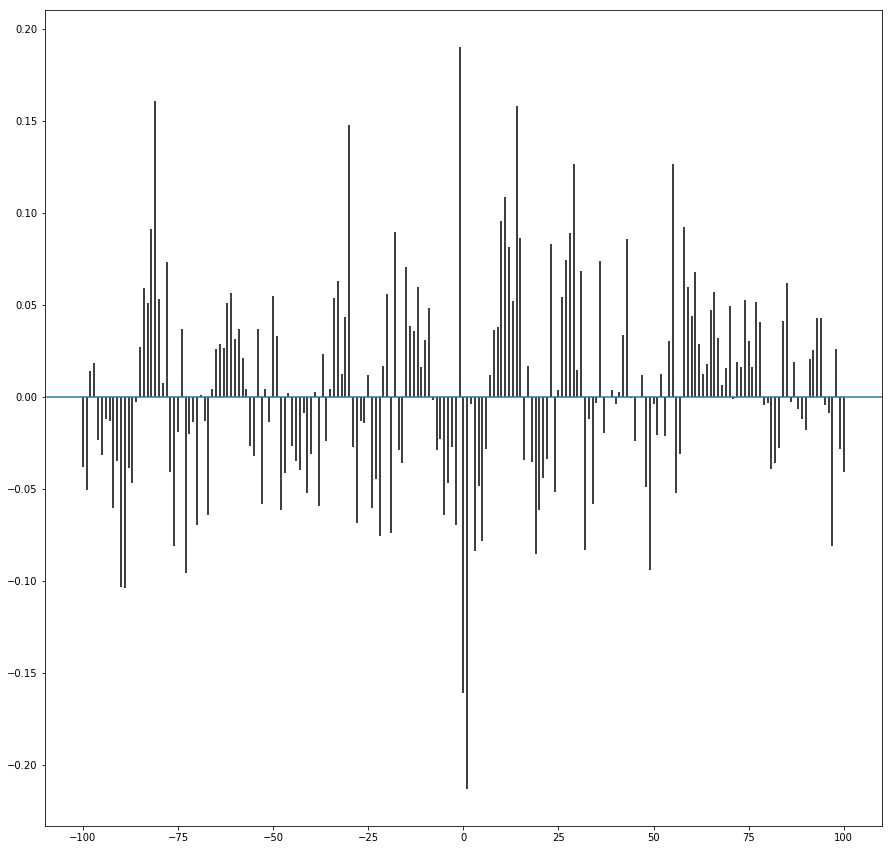

In [168]:
dd = pd.read_pickle(fileplace+'ugs_data_out.pickle').resample('1D').mean()
mind = dd.index.min()
maxd = dd.index.max()
#SNTL = SNTL_dy[(SNTL_dy.index > mind) & (SNTL_dy.index < maxd)]
x = SNTL_dy.loc[mind:maxd,'Snow Water Equivalent (in) Start of Day Values']
y = dd['LowerMain_cfs']
xdiff = x.diff()

ydiff = y.diff()
df = pd.concat([x,y,xdiff,ydiff],axis=1).dropna()

df.columns = ['x','y','xdiff','ydiff']


plt.xcorr(df['ydiff'],df['xdiff'],maxlags=100)

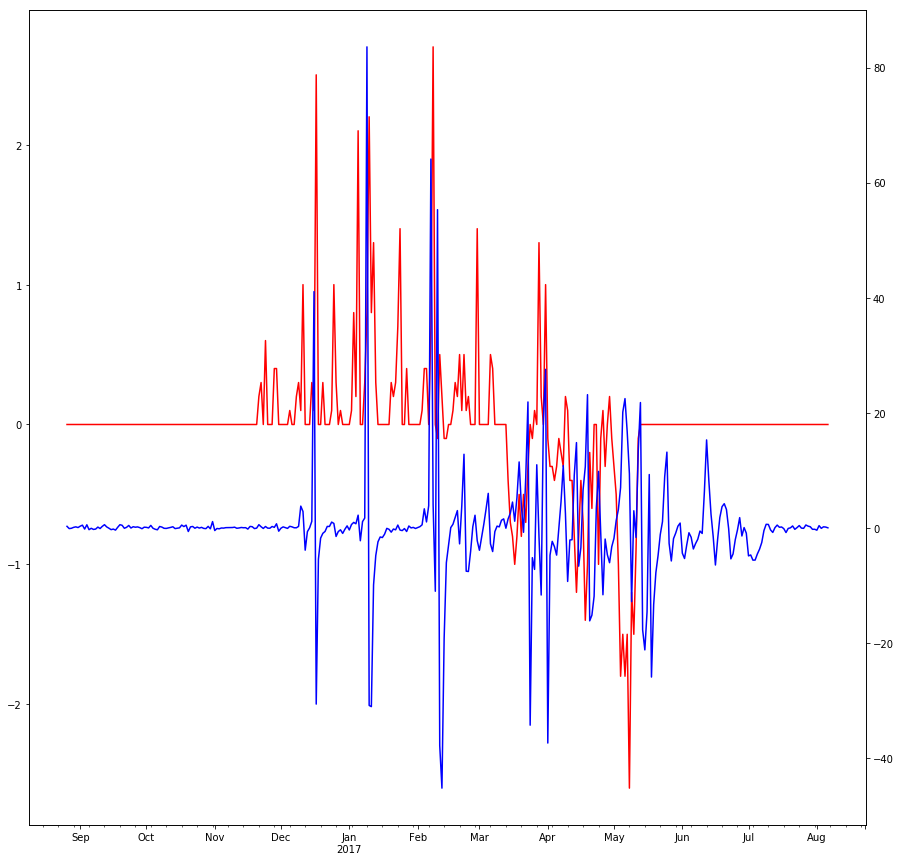

In [167]:
df.xdiff.plot(color='red')
plt.twinx()
df.ydiff.plot(color='blue')

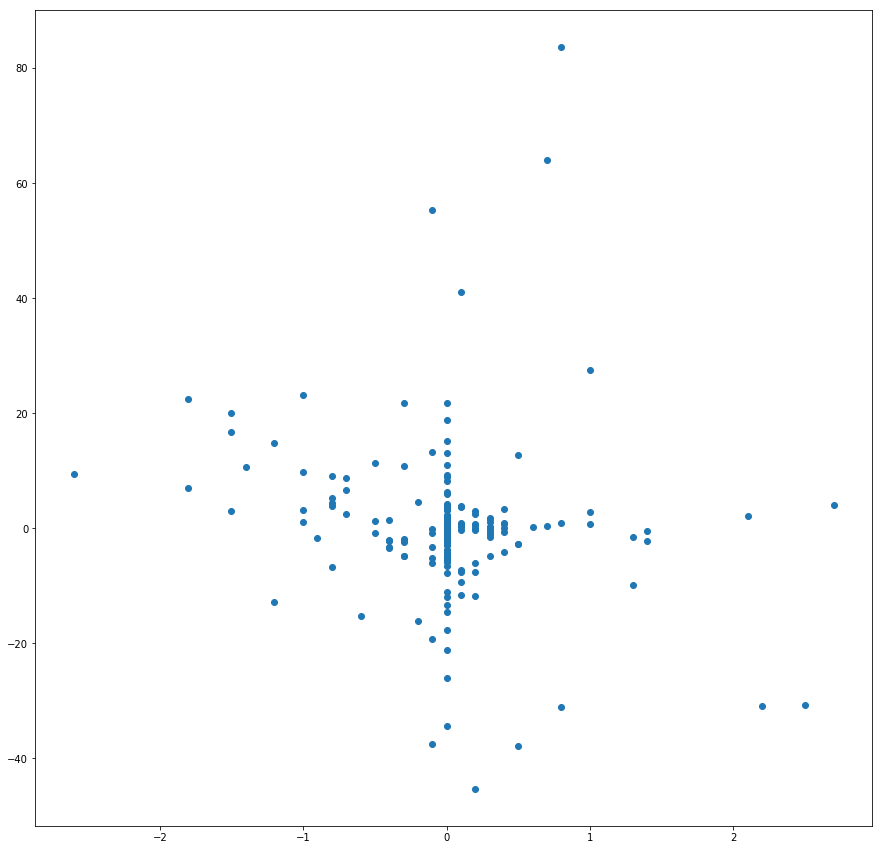

In [161]:
plt.scatter(df.xdiff,df.ydiff)

In [110]:
SNTL2013 = pd.read_csv(fileplace+"435_ALL_YEAR=2013.csv",skiprows=2,index_col='Date',parse_dates=True)
SNTL2013['SMS.I-1:-8 (pct)  (silt)']


x = SNTL2013.loc[sites['Site 1'].index.min():sites['Site 1'].index.max(),'SMS.I-1:-8 (pct)  (silt)']
z = SNTL_dy.loc[sites['Site 1'].index.min():sites['Site 1'].index.max(),'Snow Water Equivalent (in) Start of Day Values']
y = sites['Site 1']
xdiff = x.diff()
ydiff = y.diff()
zdiff = z.diff()


df = pd.concat([x,y,z,xdiff,ydiff,zdiff],axis=1).dropna()
df.columns = ['x','y','z','xdiff','ydiff','zdiff']
df.head()

x         y    z  xdiff     ydiff  zdiff
2013-03-26  22.3  1.448610  9.3   -0.4 -0.667815    0.2
2013-03-27  22.1  1.546527  9.3   -0.2  0.097917    0.0
2013-03-28  22.2  1.583712  9.2    0.1  0.037184   -0.1
2013-03-29  23.9  1.700000  8.8    1.7  0.116288   -0.4
2013-03-30  26.8  1.791468  9.3    2.9  0.091469    0.5

(array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20]),
 array([-0.00487106, -0.00523888,  0.04416973,  0.02854746,  0.02694879,
         0.01070851, -0.00349307,  0.0207929 ,  0.00224279,  0.02357122,
         0.0435444 ,  0.01803126, -0.00797688, -0.02211041,  0.01574585,
        -0.00986093, -0.02024395, -0.02609182, -0.03923119, -0.07794344,
        -0.16478599, -0.25031386, -0.3755573 , -0.30768047,  0.03085028,
         0.19367826,  0.05895036, -0.11135589, -0.03167827, -0.02285117,
        -0.0639625 , -0.0744584 , -0.06864837, -0.06365096, -0.14274606,
        -0.29902725, -0.45103492, -0.45354341, -0.27015671, -0.05531241,
        -0.03451384]),
 <matplotlib.lines.Line2D at 0x20670eef0b8>)

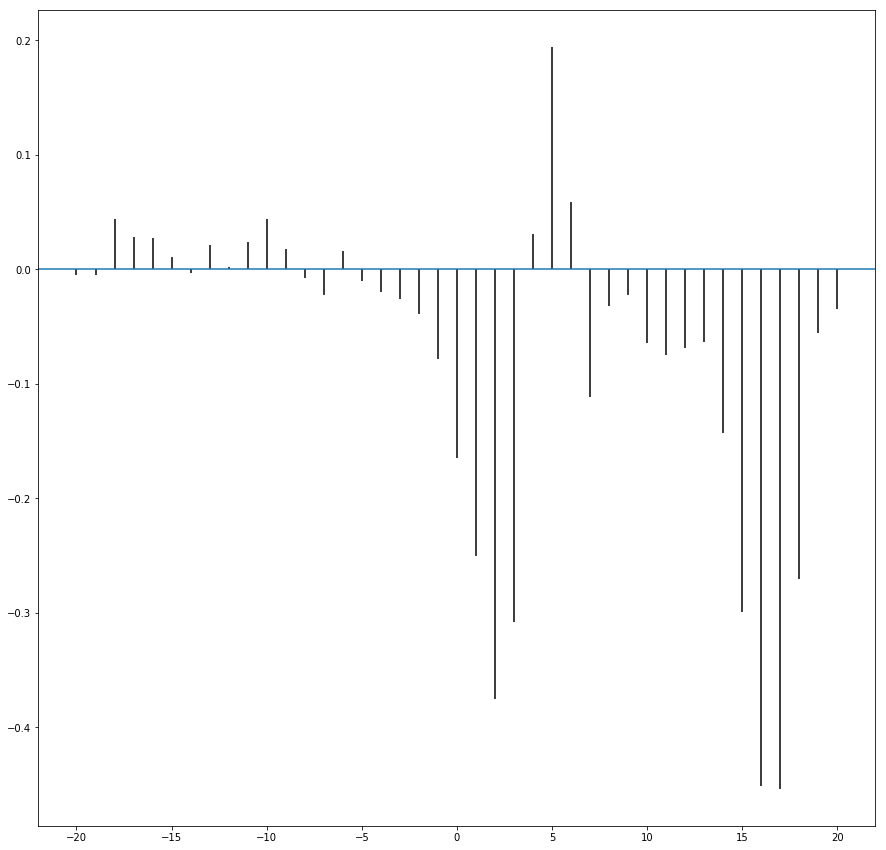

In [113]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 15

#df.y.plot(color='red')
#plt.twinx()
#df.z.plot(color='blue')

plt.figure()
plt.xcorr(df['ydiff'],df['zdiff'],maxlags=20)

In [83]:
fileplace

'G:/My Drive/WORK/Round_Valley/Data/Hydrology_Data/'

Index(['Site Id', 'Time', 'WTEQ.I-1 (in) ', 'PREC.I-1 (in) ',
       'TOBS.I-1 (degC) ', 'TMAX.D-1 (degC) ', 'TMIN.D-1 (degC) ',
       'TAVG.D-1 (degC) ', 'SNWD.I-1 (in) ', 'SMS.I-1:-2 (pct)  (silt)',
       'SMS.I-1:-8 (pct)  (silt)', 'SMS.I-1:-20 (pct)  (silt)',
       'STO.I-1:-2 (degC) ', 'STO.I-1:-8 (degC) ', 'STO.I-2:-20 (degC) ',
       'SAL.I-1:-2 (gram) ', 'SAL.I-1:-8 (gram) ', 'SAL.I-1:-20 (gram) ',
       'RDC.I-1:-2 (unit) ', 'RDC.I-1:-8 (unit) ', 'RDC.I-1:-20 (unit) ',
       'BATT.I-1 (volt) ', 'WDIRV.D-1 (degr) ', 'WSPDX.D-1 (mph) ',
       'WSPDV.D-1 (mph) '],
      dtype='object')

In [33]:
DEQ_long_flow = pd.read_excel(fileplace+'flow_check_wqp.xlsx','Sheet1')
DEQ_long_flow.set_index('datetime',inplace=True)
DEQ_long_flow.drop_duplicates(inplace=True)


In [39]:
sntl=[]
for ind in DEQ_long_flow.index:
    sntl.append(wa.fcl(SNTL_dy['Snow Water Equivalent (in) Start of Day Values'],ind))
DEQ_long_flow['Snotel'] = sntl

In [41]:
y = DEQ_long_flow['Flow_cfs']
x = DEQ_long_flow['Snotel']

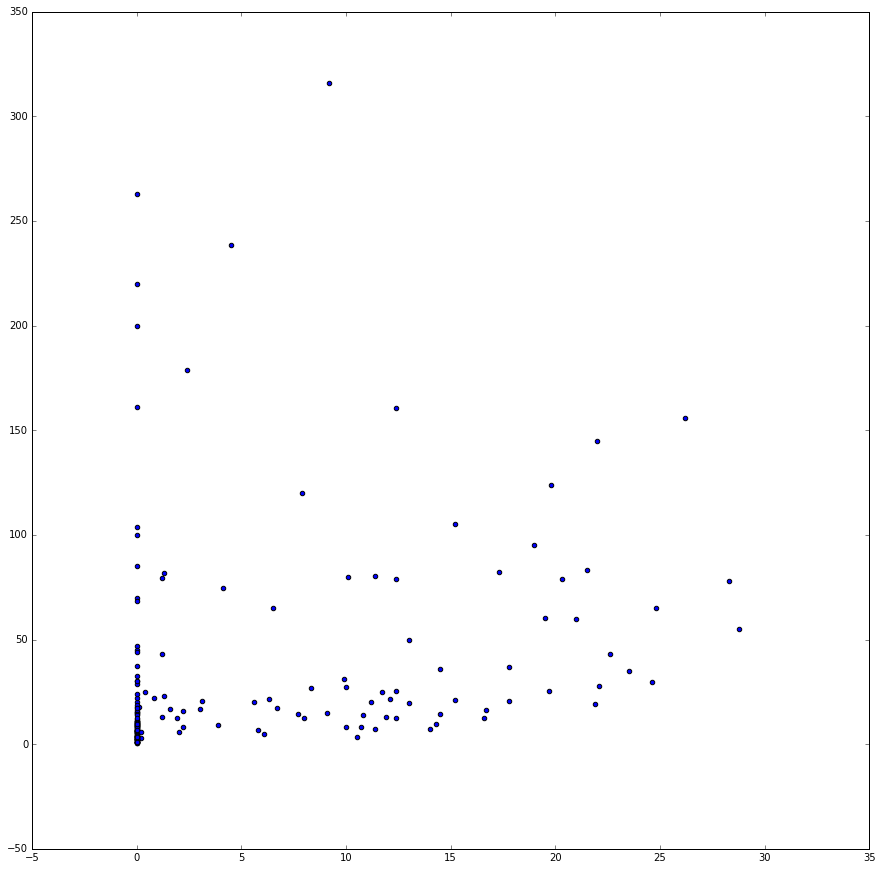

In [48]:

w = DEQ_long_flow.index.to_julian_date()


def func(x, a, b, c):
    return a*(x)**(b) + c

bounds = ([0.0,1.0, -600.0],[30.0,10.0,500.0])

popt, pcov = curve_fit(func, x, y, bounds=bounds, max_nfev = 800000) #, method='trf')

sterr = np.sqrt(np.diag(pcov))


lal = 'Measured data fit to\Snotel'

equation = 'Fitted Curve ' + r'$f(x)= (A \dot (x)^{B} + C)$ '
eqlab = ' A = {:0.0f} B = {:0.1f} C = {:0.1f}'
DEQ_long_flow[lal] = DEQ_long_flow['Snotel'].apply(lambda x: func(x,*popt),1)
plt.scatter(x,y)

# Potentiometric Surface Data

## UGS

### Levels

In [ ]:
UGSDTW = pd.read_excel(fileplace+'UGS_WL_Data.xlsx', index_col='Datetime')

In [ ]:
p1 = Proj(init='epsg:32612')
p2 = Proj(init='epsg:4326')
p3 = Proj(init='epsg:26912')

UGSDTW['dec_long_va'] = UGSDTW[['X','Y']].apply(lambda x: pyproj.transform(p1,p2,x[0],x[1])[0],1)
UGSDTW['dec_lat_va'] = UGSDTW[['X','Y']].apply(lambda x: pyproj.transform(p1,p2,x[0],x[1])[1],1)

UGSDTW['UTM_X'] = UGSDTW[['X','Y']].apply(lambda x: pyproj.transform(p1,p3,x[0],x[1])[0],1)
UGSDTW['UTM_Y'] = UGSDTW[['X','Y']].apply(lambda x: pyproj.transform(p1,p3,x[0],x[1])[1],1)
UGSDTW['DTW_FGS'] = UGSDTW[['DTW','Stickup']].apply(lambda x: x[0]-x[1],1)
UGSDTW['Elev'] = UGSDTW[['dec_long_va','dec_lat_va']].apply(lambda x: USGS.getelev(x),1)
UGSDTW['WL_Elev'] = UGSDTW[['DTW_FGS','Elev']].apply(lambda x: x[1]*3.2808-x[0],1)

def stupidUSGS(x):
    x = float(x)
    if x is None or x == np.NaN or x==np.nan or np.isnan(x):
        pass
    else:
        return str(int(float(x)))

UGSDTW['USGSnum'] = UGSDTW['USGSnum'].apply(lambda x: stupidUSGS(x),1)

In [ ]:
kml = simplekml.Kml()

wellstyle = simplekml.Style()
wellstyle.iconstyle.color = simplekml.Color.blue  # Make the text red
wellstyle.iconstyle.scale = 0.75  # Make the text twice as big
wellstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'


for i in list(UGSDTW.index):
    pnt = kml.newpoint()
    pnt.name = str(UGSDTW.ix[i,'ID'])
    pnt.description = str(UGSDTW.ix[i,'Name']) + ' ' + str(UGSDTW.ix[i,'WIN'])
    pnt.coords = [(UGSDTW.ix[i,'dec_long_va'], UGSDTW.ix[i,'dec_lat_va'])]
    pnt.style = wellstyle

kml.save(fileplace+"ugssites.kml")

In [ ]:
map_5 = folium.Map(location=[UGSDTW.dec_lat_va.median(), UGSDTW.dec_long_va.median()],tiles='Stamen Terrain',
                   zoom_start=13, width=u'100%', height=u'70%')

for i in range(len(UGSDTW)):
    
    folium.CircleMarker(
        [UGSDTW.ix[i,'dec_lat_va'],UGSDTW.ix[i,'dec_long_va']],
        popup=str(UGSDTW.ix[i,'Name']) + ' WL Elev:' + str(UGSDTW.ix[i,'WL_Elev']), color='#ff0000',
        radius=12
        ).add_to(map_5)

#map_5.click_for_marker(popup='Your Custom Text')
    
map_5



In [ ]:
UGSDTW.to_excel(fileplace+'UGS_WL_Data_out.xlsx')

### Screens

In [ ]:
UGSScrn = pd.read_excel(fileplace+'UGS_WL_Data.xlsx','screen')

In [ ]:
print(UGSDTW.columns)
print(UGSScrn.columns)

In [ ]:
ScrnEl = pd.merge(UGSScrn, UGSDTW, on='ID', how='left')

In [ ]:
ScrnEl['FromEl'] = ScrnEl['Elev']*3.2808 - ScrnEl['From_ft']
ScrnEl['ToEl'] = ScrnEl['Elev']*3.2808 - ScrnEl['To_ft']

### Gradient

In [ ]:
UGSGrad = xl2PntFt(fileplace+'UGS_WL_Data.xlsx', 'x2', 'y2', shpplace, 'UGSGrad', 'MapData.gdb',32612, sheetname='Vert_Gradient')

### UGS Data Create Feature Class

In [ ]:

    
shpnm = 'UGSWLS_utm1'
shpnm2 = 'UGSScrn_utm'
#df2PntShpAP(UGSDTW,'UTM_X','UTM_Y',shpplace + shpnm,26912)
df2PntShpAP(ScrnEl,'UTM_X','UTM_Y',shpplace + shpnm2,26912)
arcpy.env.workspace = fileplace
arcpy.FeatureClassToFeatureClass_conversion(shpplace + shpnm2 +'.shp', shpplace+'MapData.gdb', shpnm2)

## USGS

### Watershed-Wide USGS

The purpose of this section is to determine long-term variations in the regional groundwater levels, as well as produce a dataset to observe regional median groundwater levels.

First download all data from the Provo Watershed HUC.

In [ ]:
HUCName = {16020203:'Provo'}

USGSgwl = wa.nwis('gwlevels',16020203, 'huc')
allsites = USGSgwl.sites
alldata = USGSgwl.data
siteList = list(allsites.site_no.unique())
allsites.to_csv(fileplace+'usgs_well_locals.csv')
alldata.reset_index(inplace=True)
print('{:} measurements from {:} sites imported!'.format(len(alldata), len(allsites)))

In [ ]:
sitesinfo = USGSgwl.get_info()

In [ ]:
sites = get_station_info('16020203',sitetype='huc',datatype=['gw'])

Reproject USGS station data to local projection (NAD83 UTM Zone 12). Procure elevation from USGS service, based on the National Elevation Dataset, which generally has a 10-meter horizontal resolution and high vertical accuracy.

In [ ]:
p3 = Proj(init='epsg:26912') #NAD83 UTM Z12
p4 = Proj(init='epsg:4269') #NAD83 http://spatialreference.org/ref/epsg/4269/

allsites['UTM_X'] = allsites[['dec_long_va','dec_lat_va']].apply(lambda x: pyproj.transform(p4,p3,x[0],x[1])[0],1)
allsites['UTM_Y'] = allsites[['dec_long_va','dec_lat_va']].apply(lambda x: pyproj.transform(p4,p3,x[0],x[1])[1],1)
print('Reprojection Complete!')
allsites['Elev'] = allsites[['dec_long_va','dec_lat_va']].apply(lambda x: wa.get_elev(x),1)
print('Elevation assignment complete!')

In [ ]:
def get_huc(x):
    import requests
    """Receive the content of ``url``, parse it as JSON and return the object.
    :param x: [longitude, latitude]
    :returns: HUC12, HUC12_Name - 12 digit hydrologic unit code of location and the name associated with that code
    """
    values = {
        'geometry': '{:},{:}'.format(x[0], x[1]),
        'geometryType': 'esriGeometryPoint',
        'inSR': '4326',
        'spatialRel': 'esriSpatialRelIntersects',
        'returnGeometry': 'false',
        'outFields': 'HUC12,Name',
        'returnDistinctValues': 'true',
        'f': 'pjson'}

    huc_url = 'https://services.nationalmap.gov/arcgis/rest/services/wbd/MapServer/7/query?'
    # huc_url = 'https://services.nationalmap.gov/arcgis/rest/services/USGSHydroNHDLarge/MapServer/10/query?'
    # huc_url2 = 'https://services.nationalmap.gov/arcgis/rest/services/nhd/mapserver/8/query?'
    response = requests.get(huc_url, params=values).json()
    try:
        huc,name =  response['features'][0]['attributes']['HUC12'], response['features'][0]['attributes']['NAME']
    except KeyError:
        print("Key error for {:},{:}".format(x[0],x[1]))
        huc,name =  np.nan, np.nan
    return huc,name

In [ ]:
allsites['HUC12'] = allsites[['dec_long_va','dec_lat_va']].apply(lambda x: get_huc(x),1)

Count wells with multiple measurements.

In [ ]:
adg = alldata.groupby('site_no').size()
g = 0
h = 0
one = len(adg[adg == 1])
two = len(adg[adg == 2])
for i in range(max(adg)):
    if i > 30:
        g = g + len(adg[adg == i])
    elif i <= 30 and i > 1:
        h = h + len(adg[adg == i])

print("{:} of the {:} wells had 2 or more measurements. Of the {:} with 2 or more measurements \
{:} had just 2 and {:} had more than 30 measurements.".format(h+g, h + g + one, h + g, two, g))

In [ ]:
moretwo = list(adg[adg>2].index.values)
morethirty = list(adg[adg>30].index.values)

Normalize water level data by station so that changes at all stations can be compared.

In [ ]:
for site in siteList:
    mean = alldata.ix[alldata.site_no==site, 'value'].mean()
    std = alldata.ix[alldata.site_no==site, 'value'].std()
    meandiff = alldata.ix[alldata.site_no==site, 'value'].diff().mean()
    stddiff = alldata.ix[alldata.site_no==site, 'value'].diff().std()
    alldata.ix[alldata.site_no==site, 'diff'] = alldata.ix[alldata.site_no==site, 'value'].diff()
    alldata.ix[alldata.site_no==site, 'avgDiffWL'] = alldata.ix[alldata.site_no==site, 'value'] - mean
    alldata.ix[alldata.site_no==site, 'cdm'] = alldata.ix[alldata.site_no==site, 'avgDiffWL'].cumsum()
    alldata.ix[alldata.site_no==site, 'avgDiff_dWL'] = alldata.ix[alldata.site_no==site, 'diff'] - meandiff    
    alldata.ix[alldata.site_no==site, 'stdWL'] = alldata.ix[alldata.site_no==site, 'avgDiffWL']/std
    alldata.ix[alldata.site_no==site, 'std_dWL'] = alldata.ix[alldata.site_no==site, 'avgDiff_dWL']/stddiff

Prepare data for easy sorting and indexing.

In [ ]:
alldata.reset_index(inplace=True)
alldata['datetime'] = pd.to_datetime(alldata['datetime'])
alldata.set_index(['datetime'],inplace=True)

In [ ]:
#alldata.drop(['index'], axis=1, inplace=True)
alldata['year'] = alldata.index.year
alldata['month'] = alldata.index.month
alldata['doy'] = alldata.index.dayofyear
alldata['julian'] = alldata.index.to_julian_date()    

Pivot data to create a column for each site. Sort and resample.

In [ ]:
balldata = alldata.reset_index()
balldata.drop_duplicates(subset = ['site_no','datetime'], inplace=True)
provopivdata = balldata.pivot(index= 'datetime', columns = 'site_no', values = 'stdWL').sort_index()
pivdataAll = balldata.pivot(index= 'datetime', columns = 'site_no', values = 'value')
pivdataAll.sort_index(inplace=True)
pivdata = pivdataAll.resample('A').mean()

Plot availability of long-term depth to water measurements for Provo watershed. Summarized available measurements.

In [ ]:
SIZE = 11
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

gntAll = wa.gantt(pivdataAll)
infoAll = gntAll.sitestats #summary statistics for original data
gnt = wa.gantt(pivdata)
info = gnt.sitestats #summary statistics for annual data
infoless = info[info['count']>4] #select only sites having more than 4 years of data; non-consecutive, one sample per year
provolist = list(infoless.StationId.values)
df = alldata[alldata['site_no'].isin(provolist)]
print(len(provolist))
gntshort = wa.gantt(pivdata, provolist)
numsites = len(gntshort.sitestats)
rcParams['figure.figsize'] = 20, 20
gntshort.ganttPlotter() #plot data
plt.ylabel('USGS Site Number')
plt.xlim(pd.datetime(1935,1,1),pd.datetime(2017,1,1))
date_range = pd.date_range('1935-01-01', '2017-01-01', freq='36M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
plt.xticks(date_range)
plt.title('Measurement Intervals for USGS Wells in Provo Watershed')
plt.tight_layout()

plt.savefig(figplace+'ProvoGantt_long.pdf')

In [ ]:
dataXY = pd.merge(infoAll, allsites, right_on='site_no', left_on='StationId', how='left')
dataXY['WL_Elev'] = dataXY[['median','Elev']].apply(lambda x: x[1]*3.2808-x[0],1)

#df2PntFt(dataXY,'UTM_X','UTM_Y',shpplace,'USGS_Provo_Lev','MapData.gdb',26912)

In [ ]:
#infoless
sitesused = allsites

kml = simplekml.Kml()

wellstyle = simplekml.Style()
wellstyle.iconstyle.color = simplekml.Color.red  # Make the text red
wellstyle.iconstyle.scale = 0.5  # Make the text twice as big
wellstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'


for i in list(sitesused.index):
    pnt = kml.newpoint()
    pnt.name = str(sitesused.ix[i,'site_no'])
    pnt.description = str(sitesused.ix[i,'station_nm'])
    pnt.coords = [(sitesused.ix[i,'dec_long_va'], sitesused.ix[i,'dec_lat_va'])]
    pnt.style = wellstyle

kml.save(fileplace+"usgssites.kml")

Code below lumps data into 6 month intervals. As it is now, it has the potential to bias the levels to more-frequently monitored wells, which may or may not be representative of the system as a whole.

In [ ]:
grp = pd.TimeGrouper("12M")
data = 'stdWL'#'avgDiffWL'#'diff'#'std_dWL'
title = 'Average Difference from Mean Water Level (ft)'
wid = 4
cen = True

def confintpls(x):
    return np.mean(x)+(np.std(x)*2.0)#/np.sqrt(np.size(x)))*1.96

def confintmin(x):
    return np.mean(x)-(np.std(x)*2.0)#/np.sqrt(np.size(x)))*1.96

df = alldata[alldata['site_no'].isin(provolist)]

#grpd = df.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})
dd = df.groupby(['site_no',pd.Grouper(freq='12MS')]).mean()
dd.reset_index(inplace=True)
dg = dd.set_index('datetime')
grpd = dg.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})
x2 = grpd.index
y2 = grpd['mean']
y3 = grpd['median']
snakegrp = grpd.median().to_frame()

SIZE = 11
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(x2, y3, '+-', color = 'green', label = 'Median' )
ax.plot(x2, y2, '+-', color = 'red', label = 'Average' )
ax.fill_between(x2,grpd['confmin'],grpd['confpls'],alpha=0.2,label='2 Standard Deviations',linewidth=0)

#ax1.set_ylim(3.5,-3.5)
ax.set_ylabel(title, color='red')
ax.invert_yaxis()
ax.grid()
ax2 = ax.twinx()
ax2.plot(x2,grpd['count'],label='Observations count')
ax2.set_ylim(0,1000)
ax2.set_yticks(range(0,420,20))
ax2.set_ylabel('Number of Observations',color='blue')
ax2.yaxis.set_label_coords(1.03,0.2)
ax.set_xlim(pd.datetime(1950,1,1),pd.datetime(2017,1,1))
date_range = pd.date_range('1950-01-01', '2017-01-01', freq='36M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
ax.set_xticks(date_range)
ax.set_xlabel('date')
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.title('Average Deviation from Mean of Depth to Water for {:} Wells in the Provo Watershed (16020203)'.format(len(provolist)))
plt.savefig(figplace+'Provo_USGS_avg_stdev.pdf')

In [ ]:
grp = pd.TimeGrouper("12M")
data = 'avgDiffWL'#'diff'#'std_dWL'
title = 'Difference from Mean Water Level (ft)'
wid = 4
cen = True

def confintpls(x):
    return np.mean(x)+(np.std(x)*2.0)#/np.sqrt(np.size(x)))*1.96

def confintmin(x):
    return np.mean(x)-(np.std(x)*2.0)#/np.sqrt(np.size(x)))*1.96

df = alldata[alldata['site_no'].isin(provolist)]

grpd = df.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})

x2 = grpd.index
y2 = grpd['mean']
y3 = grpd['median']
snakegrp = grpd.median().to_frame()

SIZE = 11
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(x2, y3, '+-', color = 'green', label = 'Median' )
ax.plot(x2, y2, '+-', color = 'red', label = 'Average' )
ax.fill_between(x2,grpd['confmin'],grpd['confpls'],alpha=0.2,label='2 Standard Deviations',linewidth=0)

#ax1.set_ylim(3.5,-3.5)
ax.set_ylabel(title, color='red')
ax.invert_yaxis()
ax.grid()
ax2 = ax.twinx()
ax2.plot(x2,grpd['count'],label='Observations count')
ax2.set_ylim(0,1000)
ax2.set_yticks(range(0,420,20))
ax2.set_ylabel('Number of Observations',color='blue')
ax2.yaxis.set_label_coords(1.03,0.2)
ax.set_xlim(pd.datetime(1950,1,1),pd.datetime(2017,1,1))
date_range = pd.date_range('1950-01-01', '2017-01-01', freq='36M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
ax.set_xticks(date_range)
ax.set_xlabel('date')
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.title('Deviation from Mean of Depth to Water for {:} Wells in the Provo Watershed (16020203)'.format(len(provolist)))
plt.savefig(figplace+'Provo_USGS_dev_avg.pdf')

In [ ]:
grp = 'month'
data = "avgDiffWL"
title = 'Average Difference from Mean Water Level (ft)'
wid = 4
cen = True
seas = alldata[alldata['site_no'].isin(moretwo)]

df1 = seas.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'std':np.std,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})

SIZE = 14
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

plt.plot(df1.index,df1['mean'],'-o',label='Mean')
plt.plot(df1.index,df1['median'],'-o',label='Median')
medlist = df1['median'].values
for i in range(len(df1.index)):
    plt.text(df1.index[i],medlist[i]-3.2, 'n = ' + str(int(list(df1['count'].values)[i])),horizontalalignment='center')
plt.fill_between(df1.index,df1['mean']-df1['std']*1,df1['mean']+df1['std']*1,alpha=0.2,label='2 Standard Deviations')
ax = plt.gca()
ax.invert_yaxis()
plt.xlim(0,13)
plt.xticks(range(1,13,1))
plt.legend()
plt.grid()
plt.xlabel('Month')
plt.ylabel( 'Average Difference from Mean Water Level (ft)')
plt.title('Monthly Average Difference from Mean Water Level in the Provo Watershed (16020203)')

plt.savefig(figplace+'Provo_USGS_Monthly_WL_diff_from_avg.pdf')

In [ ]:
grp = 'month'
data = "stdWL"
title = 'Average Standardized Water Level'
wid = 4
cen = True
seas = alldata[alldata['site_no'].isin(moretwo)]

df1 = seas.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'std':np.std,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})

SIZE = 14
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

plt.plot(df1.index,df1['mean'],'-o',label='Mean')
plt.plot(df1.index,df1['median'],'-o',label='Median')
medlist = df1['median'].values
for i in range(len(df1.index)):
    plt.text(df1.index[i],medlist[i]-0.5, 'n = ' + str(int(list(df1['count'].values)[i])),horizontalalignment='center')
plt.fill_between(df1.index,df1['mean']-df1['std']*1,df1['mean']+df1['std']*1,alpha=0.2,label='2 Standard Deviations')
ax = plt.gca()
ax.invert_yaxis()
plt.xlim(0,13)
plt.xticks(range(1,13,1))
plt.legend()
plt.grid()
plt.xlabel('Month')
plt.ylabel(title)
plt.title('Monthly Average Standardized Water Level in the Provo Watershed (16020203)')

plt.savefig(figplace+'Provo_USGS_Monthly_dev_stdAvg.pdf')

In [ ]:
gibb = pd.read_excel('H:/Google Drive/WORK/Round_Valley/Data/Hydrology_Data/Edwin Well - Sheet1.xlsx',index_col=0)

In [ ]:
gibb['month'] = gibb.index.month

In [ ]:
gibb['ft below ground'].plot()

In [ ]:
grp = 'month'
data = 'ft below ground'
title = 'Water Level (ft below ground surface)'
wid = 4
cen = True
seas = alldata[alldata['site_no'].isin(moretwo)]

df1 = gibb.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'std':np.std,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})

SIZE = 14
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

plt.plot(df1.index,df1['mean'],'-o',label='Mean')
plt.plot(df1.index,df1['median'],'-o',label='Median')
medlist = df1['median'].values
for i in range(len(df1.index)):
    plt.text(df1.index[i],medlist[i]-0.5, 'n = ' + str(int(list(df1['count'].values)[i])),horizontalalignment='center')
plt.fill_between(df1.index,df1['mean']-df1['std']*1,df1['mean']+df1['std']*1,alpha=0.2,label='2 Standard Deviations')
ax = plt.gca()
ax.invert_yaxis()
plt.xlim(0,13)
plt.xticks(range(1,13,1))
plt.legend()
plt.grid()
plt.xlabel('Month')
plt.ylabel(title)
plt.title('Monthly Average Standardized Water Level in the Gibbs Well')

plt.savefig(figplace+'Gibb_Monthly_dev_stdAvg.pdf')

### Round Valley USGS

USGS Water Level Data for Lat Long Box around Round Valley <br>
http://waterservices.usgs.gov/nwis/gwlevels/?format=rdb&bBox=-111.540000,40.260000,-111.250000,40.470000&startDT=1850-01-01&endDT=2016-08-21

USGS Water Level Site Data for Lat Long Box around Round Valley <br> http://waterservices.usgs.gov/nwis/site/?format=rdb,1.0&bBox=-111.540000,40.260000,-111.250000,40.470000&outputDataTypeCd=gw

In [ ]:
wlData_url = 'https://waterservices.usgs.gov/nwis/gwlevels/?format=rdb,1.0&bBox=-111.540000,40.260000,-111.250000,40.470000&startDT=1850-01-01&endDT=2016-08-21'
wlSiteData_url = 'https://waterservices.usgs.gov/nwis/site/?format=rdb,1.0&bBox=-111.540000,40.260000,-111.250000,40.470000&outputDataTypeCd=gw'
USGS_RV_Levels = USGS.getInfo(wlData_url)
USGS_RV_Sites = USGS.getInfo(wlSiteData_url)

In [ ]:
USGSrv = wa.nwis('gwlevels',[-111.540000,40.260000,-111.250000,40.470000], 'bBox')

In [ ]:
USGS_RV_Sites = USGSrv.sites

In [ ]:
USGS_RV_Levels = USGSrv.dataata

In [ ]:
USGS_RV_Sites['huc12'] = USGS_RV_Sites[['dec_long_va','dec_lat_va']].apply(lambda x: get_huc(x)[0],1)
USGS_RV_Sites['huc12_nm'] = USGS_RV_Sites[['dec_long_va','dec_lat_va']].apply(lambda x: get_huc(x)[1],1)

In [ ]:
HUCnames = {u'160202030402':'Little Hobble Creek',u'160202030403':'Upper Main Creek',u'160202030404':'Lower Main Creek',
            u'160202030405':'Deer Creek Reservoir-Provo River'}

In [ ]:
USGS_RV_Sites = USGS_RV_Sites[USGS_RV_Sites.huc12.isin([u'160202030403', u'160202030402', u'160202030404'])]
USGS_RV_Levels = USGS_RV_Levels[USGS_RV_Levels.index.get_level_values(0).isin(list(USGS_RV_Sites.site_no.unique()))]

In [ ]:
p3 = Proj(init='epsg:26912') #NAD83 UTM Z12
p4 = Proj(init='epsg:4269') #NAD83 http://spatialreference.org/ref/epsg/4269/

USGS_RV_Sites['UTM_X'] = USGS_RV_Sites[['dec_long_va','dec_lat_va']].apply(lambda x: pyproj.transform(p4,p3,x[0],x[1])[0],1)
USGS_RV_Sites['UTM_Y'] = USGS_RV_Sites[['dec_long_va','dec_lat_va']].apply(lambda x: pyproj.transform(p4,p3,x[0],x[1])[1],1)
print('Reprojection Complete!')
USGS_RV_Sites['Elev'] = USGS_RV_Sites[['dec_long_va','dec_lat_va']].apply(lambda x: wa.get_elev(x),1)
print('Elevation assignment complete!')

In [ ]:
USGS_RV_Levels = USGSrv.cleanGWL(USGS_RV_Levels)

In [ ]:
USGS_RV_Sites.set_index('site_no',inplace=True)

In [ ]:
stationWL = pd.merge(USGS_RV_Levels, USGS_RV_Sites, left_index=True, right_index=True, how='left')

In [ ]:
stationWL['wlelev'] = stationWL[['value','Elev']].apply(lambda x: x[1]-x[0],1)

In [ ]:
USGS_RV_Lev = USGS_RV_Levels.reset_index()
USGS_RV_Lev['lev_dt'] = pd.to_datetime(USGS_RV_Lev['datetime'])
USGS_RV_Lev.set_index(['lev_dt'],inplace=True)
#USGS_RV_Lev.drop(['index'], axis=1, inplace=True)
USGS_RV_Lev['year'] = USGS_RV_Lev.index.year
USGS_RV_Lev['month'] = USGS_RV_Lev.index.month
USGS_RV_Lev['doy'] = USGS_RV_Lev.index.dayofyear
USGS_RV_Lev['julian'] = USGS_RV_Lev.index.to_julian_date()

In [ ]:
balldata = USGS_RV_Lev.reset_index()
balldata.drop_duplicates(subset = ['site_no','datetime'], inplace=True)
snakepivdata = balldata.pivot(index= 'datetime', columns = 'site_no', values = 'value').sort_index()
pivdata = balldata.pivot(index= 'datetime', columns = 'site_no', values = 'value')
pivdata.sort_index(inplace=True)
pivdata = pivdata.resample('M').mean()

In [ ]:
SIZE = 14
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

fig = wa.gantt(pivdata)
#fig.ganttPlotter()
info = fig.sitestats
infoless = info[info['count']>3]
snakelist = list(infoless.StationId.values)
df = balldata[balldata['site_no'].isin(snakelist)]
print(len(snakelist))
fig2 = wa.gantt(pivdata, snakelist)
fig2.ganttPlotter()
plt.ylabel('USGS Site Number')
plt.title('Measurement Intervals for USGS Wells in Round Valley')
plt.tight_layout()
plt.savefig(figplace+'RoundValleyGantt.pdf')

In [ ]:
USGS_RV_Sites.head()

In [ ]:
SIZE = 12
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

statList = infoless.StationId.values
f, ax = plt.subplots(len(statList), sharex=True)

for i in range(len(statList)):
    stLev = USGS_RV_Lev[USGS_RV_Lev['site_no']==statList[i]]
    stInf = USGS_RV_Sites[USGS_RV_Sites.index==statList[i]]
    
    ax[i].plot(stLev.index,stLev['value'],'o-')
    ax[i].invert_yaxis()
    ax[i].grid()
    ax[i].set_title('{:} in {:} area'.format(statList[i],stInf['huc12_nm'].values[0]))
f.text(-0.02,.5,'Depth to Water (ft)',ha='center', va='center', rotation='vertical', size='large')

plt.xlim(pd.datetime(1988,9,1),pd.datetime(1989,9,1))
date_rng = pd.date_range('1988-09-01', '1989-09-01', freq='1M')
date_range = date_rng.map(lambda t: t.strftime('%Y-%m-%d'))
date_labs = date_rng.map(lambda t: t.strftime('%Y-%m'))
plt.xticks(date_range,date_labs)
plt.tight_layout()


plt.savefig(figplace+'RoundValleySeasonal.pdf')

In [ ]:
kml = simplekml.Kml()

wellstyle = simplekml.Style()
wellstyle.iconstyle.color = simplekml.Color.red  # Make the text red
wellstyle.iconstyle.scale = 0.5  # Make the text twice as big
wellstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'


for i in list(USGS_RV_Sites.index):
    pnt = kml.newpoint()
    pnt.name = str(USGS_RV_Sites.ix[i,'site_no'])
    pnt.description = str(USGS_RV_Sites.ix[i,'begin_date'])+', ' + str(USGS_RV_Sites.ix[i,'begin_date'])+', n = ' + str(USGS_RV_Sites.ix[i,'count_nu']) 
    pnt.coords = [(USGS_RV_Sites.ix[i,'dec_long_va'], USGS_RV_Sites.ix[i,'dec_lat_va'])]
    pnt.style = wellstyle

kml.save(fileplace+"usgs_rv_sites.kml")

In [ ]:
RV_Seasonal = USGS_RV_Sites[USGS_RV_Sites['site_no'].isin(statList)]
RV_Seasonal.columns

In [ ]:
RV_Seasonal.drop([u'agency_cd', u'site_tp_cd', u'coord_acy_cd', u'dec_coord_datum_cd', u'alt_va',
                  u'alt_acy_va', u'alt_datum_cd', u'huc_cd', u'data_type_cd', u'parm_cd',
                  u'stat_cd', u'ts_id', u'loc_web_ds', u'medium_grp_cd', u'parm_grp_cd',
                  u'srs_id', u'access_cd', u'begin_date', u'end_date', u'count_nu',
                  ], axis=1, inplace=True)

In [ ]:
RV_Seasonal

In [ ]:
RV_Seasonal

map_5 = folium.Map(location=[RV_Seasonal.dec_lat_va.median(), RV_Seasonal.dec_long_va.median()],tiles='Stamen Terrain',
                   zoom_start=13, width=u'100%', height=u'70%')

indnum = [3,5,27,32,34,35,38,43,48]

for i in range(len(RV_Seasonal)):
    
    folium.CircleMarker(
        [RV_Seasonal.ix[indnum[i],'dec_lat_va'],RV_Seasonal.ix[indnum[i],'dec_long_va']],
        popup=str(RV_Seasonal.ix[indnum[i],'site_no']), color='#ff0000',
        radius=12
        ).add_to(map_5)

#map_5.click_for_marker(popup='Your Custom Text')
    
map_5



In [ ]:
type(RV_Seasonal)

In [ ]:
ep = 26912
arcpy.env.workspace = shpplace+'MapData.gdb'

df2PntFt(RV_Seasonal,RV_Seasonal.UTM_X,RV_Seasonal.UTM_Y,shpplace,'SeasonalUSGS',shpplace+'MapData.gdb',ep)


In [ ]:
stationWL.lev_dt = stationWL.lev_dt.apply(lambda x: pd.to_datetime(x),1)

In [ ]:
map_6 = folium.Map(location=[USGS_RV_Sites.dec_lat_va.median(), USGS_RV_Sites.dec_long_va.median()],
                   tiles='Stamen Terrain',
                   zoom_start=13)
import vincent
for i in USGS_RV_Sites.index:
    vincent.core.initialize_notebook()
    num = USGS_RV_Sites.ix[i,'site_no']
    df = stationWL[stationWL.site_no == num]
    df.set_index(['lev_dt'],inplace=True)
    #print(df)
    line = vincent.Scatter([df.index.to_julian_date(), df['lev_va'].values])
    line.axis_titles(x='Date', y='Level (ft)')
    line.width = 200
    line.height = 100
    g =str(num) +'.json'
    line.to_json(g)
    folium.CircleMarker(
        [USGS_RV_Sites.ix[i,'dec_lat_va'], USGS_RV_Sites.ix[i,'dec_long_va']],
        popup= folium.Popup(max_width=450).add_child(
        folium.Vega(json.load(open(g)), width=250, height=150)),
        color='#ff0000', radius=12
        ).add_to(map_6)
map_6
